In [1]:
#Import libraries
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,RandomizedSearchCV,KFold,GridSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from tqdm.notebook import tqdm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.svm import LinearSVR,SVR
from mlxtend.regressor import StackingCVRegressor
from sklearn.utils import resample
from sklearn.externals import joblib

In [2]:
import os 
import random
import datetime
import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

<h2>1. Data Preparation

<h3>1.1. Import dataset</h3>

In [3]:
data = pd.read_csv('train.csv')
data.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [4]:
data.shape

(4209, 378)

<h3>1.2. Removing outliers</h3>

In [5]:
#Remove outliers
data = data[data['y']<=150]

In [6]:
data.shape

(4194, 378)

<h3>1.3. Split the dataset</h3>

In [7]:
X = data.drop(columns=['y'])
Y = data['y']

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=25) 

In [9]:
print(X_train.shape)
print(X_val.shape)

(3355, 377)
(839, 377)


In [10]:
train_data = pd.merge(X_train,y_train.to_frame(),left_index=True, right_index=True)

In [11]:
train_data.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X376,X377,X378,X379,X380,X382,X383,X384,X385,y
1468,2917,ak,s,n,g,d,ac,j,n,0,...,0,0,0,0,0,0,0,0,0,111.09
3654,7320,z,aa,as,c,d,v,d,m,0,...,0,0,0,0,0,0,0,0,0,93.39
3130,6268,z,b,m,a,d,q,i,j,0,...,0,1,0,0,0,0,0,0,0,94.62
257,513,j,a,as,f,d,i,k,l,0,...,0,0,0,0,0,0,0,0,0,107.90
781,1533,z,b,ai,c,d,af,l,t,0,...,0,1,0,0,0,0,0,0,0,93.43


In [12]:
train_data.shape

(3355, 378)

<h3>1.4. Label encoding of categorical features</h3>

In [13]:
def label_encoding(dataset):
    """
    Returns dictionary of Label encoding of categorical features
    """
    a = dataset.value_counts()
    
    #Get categories which occur more than 5 times in dataset
    b = list(filter(lambda x:x>5,a.values))    
    c = list(a.index[0:len(b)])

    return {j:i+1 for i,j in enumerate(c)}  #Dictionary of labels, unknown categories are assigned label 0

In [14]:
x0_labels = label_encoding(train_data['X0'])
x1_labels = label_encoding(train_data['X1'])
x2_labels = label_encoding(train_data['X2'])
x3_labels = label_encoding(train_data['X3'])
x5_labels = label_encoding(train_data['X5'])
x6_labels = label_encoding(train_data['X6'])
x8_labels = label_encoding(train_data['X8'])

In [15]:
train_data['X0'] = [x0_labels[i] if x0_labels.get(i) is not None else 0 for i in train_data['X0']]
train_data['X1'] = [x1_labels[i] if x1_labels.get(i) is not None else 0 for i in train_data['X1']]
train_data['X2'] = [x2_labels[i] if x2_labels.get(i) is not None else 0 for i in train_data['X2']]
train_data['X3'] = [x3_labels[i] if x3_labels.get(i) is not None else 0 for i in train_data['X3']]
train_data['X5'] = [x5_labels[i] if x5_labels.get(i) is not None else 0 for i in train_data['X5']]
train_data['X6'] = [x6_labels[i] if x6_labels.get(i) is not None else 0 for i in train_data['X6']]
train_data['X8'] = [x8_labels[i] if x8_labels.get(i) is not None else 0 for i in train_data['X8']]

<h3>1.5. Numerical Features</h3>

In [16]:
num_features = np.load('num_features.npy',allow_pickle=True)

<h3>1.6. Feature Engineering</h3>

In [17]:
feature_engg = np.load('feature_engg.npy',allow_pickle=True)

In [18]:
def feature_engineering(data,feature_engg):
    """
    Adding new features to dataset
    """
    for i in tqdm(feature_engg):
        if len(i.split('_'))==2:
            a,b = i.split('_')
            data[i] = data[a] + data[b]
        else:
            a,b,c = i.split('_')
            data[i] = data[a] + data[b] + data[c]
    return data

In [19]:
train_data = feature_engineering(train_data,feature_engg)

<h3>1.7. Combining all features

In [20]:
final_features = ['ID','X0','X1','X2','X3','X5','X6','X8'] + list(num_features) + list(feature_engg)

In [21]:
X_train = train_data[final_features]

In [22]:
X_train.head()

,ID,X0,X1,X2,X3,X5,X6,X8,X10,X12,...,X314_X315_X322,X314_X315_X326,X314_X315_X340,X314_X315_X342,X314_X315_X345,X314_X315_X359,X314_X315_X361,X314_X315_X368,X314_X315_X373,X314_X315_X376
1468,2917,2,4,7,5,12,1,4,0,0,...,1,1,1,1,1,1,2,1,1,1
3654,7320,1,1,1,1,1,3,14,0,0,...,0,0,0,0,0,0,1,0,0,0
3130,6268,1,3,4,3,2,4,1,0,0,...,0,0,0,0,0,0,1,0,0,0
257,513,10,8,1,2,5,8,23,0,0,...,1,1,1,1,1,1,1,1,1,1
781,1533,1,3,3,1,10,5,16,0,0,...,0,0,0,0,0,0,1,1,0,0


In [23]:
X_train.shape

(3355, 517)

In [24]:
y_train = train_data['y']

<h3>1.8. Normalise non-binary features</h3>

In [25]:
#Features from feature engineering which are non-binary
scale_features = ['ID','X0','X1','X2','X3','X5','X6','X8']

In [26]:
scaler = MinMaxScaler()
scaler.fit(X_train[scale_features])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [27]:
scale_features_min = {i:j for i,j in zip(scale_features,scaler.data_min_)}
scale_features_max = {i:j for i,j in zip(scale_features,scaler.data_max_)}

In [28]:
def normalizer(obs,min_value,max_value):
    """
    This function normalises the input value.
    """
    return (obs - min_value)/(max_value-min_value)

In [29]:
for i in tqdm(scale_features):
    X_train.loc[:,i] = X_train.loc[:,i].apply(normalizer,min_value=scale_features_min[i],max_value=scale_features_max[i])

In [30]:
X_train.head()

,ID,X0,X1,X2,X3,X5,X6,X8,X10,X12,...,X314_X315_X322,X314_X315_X326,X314_X315_X340,X314_X315_X342,X314_X315_X345,X314_X315_X359,X314_X315_X361,X314_X315_X368,X314_X315_X373,X314_X315_X376
1468,0.346561,0.051282,0.181818,0.259259,0.666667,0.500000,0.000000,0.125000,0,0,...,1,1,1,1,1,1,2,1,1,1
3654,0.869669,0.025641,0.045455,0.037037,0.000000,0.041667,0.181818,0.541667,0,0,...,0,0,0,0,0,0,1,0,0,0
3130,0.744683,0.025641,0.136364,0.148148,0.333333,0.083333,0.272727,0.000000,0,0,...,0,0,0,0,0,0,1,0,0,0
257,0.060948,0.256410,0.363636,0.037037,0.166667,0.208333,0.636364,0.916667,0,0,...,1,1,1,1,1,1,1,1,1,1
781,0.182131,0.025641,0.136364,0.111111,0.000000,0.416667,0.363636,0.625000,0,0,...,0,0,0,0,0,0,1,1,0,0


<h3>1.9. Preprocess unseen data</h3>

In [31]:
def preprocess(dataset,categ_mapping,feature_engg,num_features,norm_features):
    
    #Encode Categorical variables
    x0_labels,x1_labels,x2_labels,x3_labels,x5_labels,x6_labels,x8_labels = categ_mapping
    dataset['X0'] = [x0_labels[i] if x0_labels.get(i) is not None else 0 for i in dataset['X0']]
    dataset['X1'] = [x1_labels[i] if x1_labels.get(i) is not None else 0 for i in dataset['X1']]
    dataset['X2'] = [x2_labels[i] if x2_labels.get(i) is not None else 0 for i in dataset['X2']]
    dataset['X3'] = [x3_labels[i] if x3_labels.get(i) is not None else 0 for i in dataset['X3']]
    dataset['X5'] = [x5_labels[i] if x5_labels.get(i) is not None else 0 for i in dataset['X5']]
    dataset['X6'] = [x6_labels[i] if x6_labels.get(i) is not None else 0 for i in dataset['X6']]
    dataset['X8'] = [x8_labels[i] if x8_labels.get(i) is not None else 0 for i in dataset['X8']]

    #Feature engineering
    dataset = feature_engineering(dataset,feature_engg)
    
    #Combine features
    final_features = ['ID','X0','X1','X2','X3','X5','X6','X8'] + list(num_features) + list(feature_engg)
    dataset = dataset[final_features]
    
    #Normalise features
    scale_features, scale_features_min, scale_features_max = norm_features
    for i in tqdm(scale_features):
        dataset.loc[:,i] = dataset.loc[:,i].apply(normalizer,min_value=scale_features_min[i],max_value=scale_features_max[i])
    
    return dataset

In [32]:
categ_mapping = [x0_labels,x1_labels,x2_labels,x3_labels,x5_labels,x6_labels,x8_labels]
norm_features = [scale_features, scale_features_min, scale_features_max]
X_val = preprocess(X_val,categ_mapping,feature_engg,num_features,norm_features)

In [33]:
X_val.head()

,ID,X0,X1,X2,X3,X5,X6,X8,X10,X12,...,X314_X315_X322,X314_X315_X326,X314_X315_X340,X314_X315_X342,X314_X315_X345,X314_X315_X359,X314_X315_X361,X314_X315_X368,X314_X315_X373,X314_X315_X376
3186,0.756208,0.282051,0.090909,0.259259,0.166667,0.333333,0.090909,0.000000,0,0,...,0,0,0,0,0,0,1,0,0,0
1507,0.357491,0.282051,0.681818,0.259259,0.166667,0.708333,0.363636,0.083333,0,0,...,0,0,0,0,0,0,1,0,0,0
694,0.160508,0.128205,0.045455,0.037037,0.500000,0.416667,0.272727,0.041667,0,0,...,1,1,1,1,1,1,2,1,1,2
2898,0.690270,0.410256,0.045455,0.037037,0.000000,0.541667,0.181818,0.125000,0,0,...,1,1,1,1,1,1,2,1,1,1
1356,0.318641,0.666667,0.909091,0.111111,0.000000,0.500000,0.272727,0.000000,0,0,...,1,1,0,0,0,0,1,0,0,0


<h2>2. Feature Selection using Random Forest algorithm

<h3>2.1. Hyperparmeter tuning</h3>

<h3>2.1.1. n_estimators Vs max_depth</h3>

In [35]:
alpha = [100,500,1000,1500]
max_depth = [3,5,7,10,15,20]
train_r2_score_list = []
val_r2_score_list = []

for i in tqdm(max_depth):
    train_a=[]
    val_a=[]
    for j in alpha:
        clf = RandomForestRegressor(n_estimators=j,max_depth=i,random_state=42,n_jobs=-1)
        clf.fit(X_train,y_train)
        train_a.append(clf.score(X_train,y_train))
        val_a.append(clf.score(X_val,y_val))
    train_r2_score_list.append(train_a)
    val_r2_score_list.append(val_a)

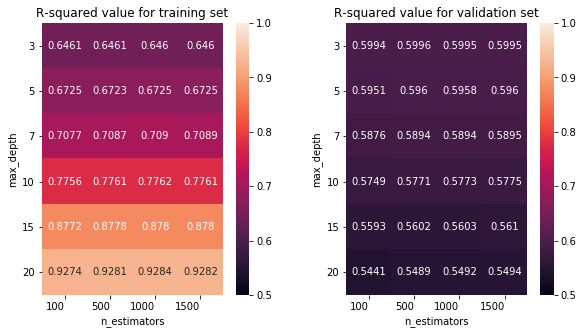

In [38]:
plt.figure(figsize=(10,5))
plt.subplot(121)
ax=sns.heatmap(train_r2_score_list,annot=True,square=True,fmt='.4g',vmin=0.5,vmax=1)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.title('R-squared value for training set')
ax.set_xticklabels(alpha,rotation=0, horizontalalignment='right');
ax.set_yticklabels(max_depth,rotation=0, horizontalalignment='right');
plt.subplot(122)
ax=sns.heatmap(val_r2_score_list,annot=True,square=True,fmt='.4g',vmin=0.5,vmax=1)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.title('R-squared value for validation set')
ax.set_xticklabels(alpha,rotation=0, horizontalalignment='right');
ax.set_yticklabels(max_depth,rotation=0, horizontalalignment='right');

R-squared value for train and validation set are nearly same for different values of n_estimators for fixed value of max_depth.


Best value of hyperparameters:
n_estimators = 500, max_depth = 3 

<h3>2.1.2. min_samples_split Vs max_depth</h3>

In [54]:
alpha = [100,200,300,400,450,500,550,600,700,800]  #min_samples_split
max_depth = [3,5,7,10,15,20]
train_r2_score_list = []
val_r2_score_list = []

for i in tqdm(max_depth):
    train_a=[]
    val_a=[]
    for j in alpha:
        clf = RandomForestRegressor(min_samples_split=j,n_estimators=500,max_depth=i,random_state=42,n_jobs=-1)
        clf.fit(X_train,y_train)
        train_a.append(clf.score(X_train,y_train))
        val_a.append(clf.score(X_val,y_val))
    train_r2_score_list.append(train_a)
    val_r2_score_list.append(val_a)

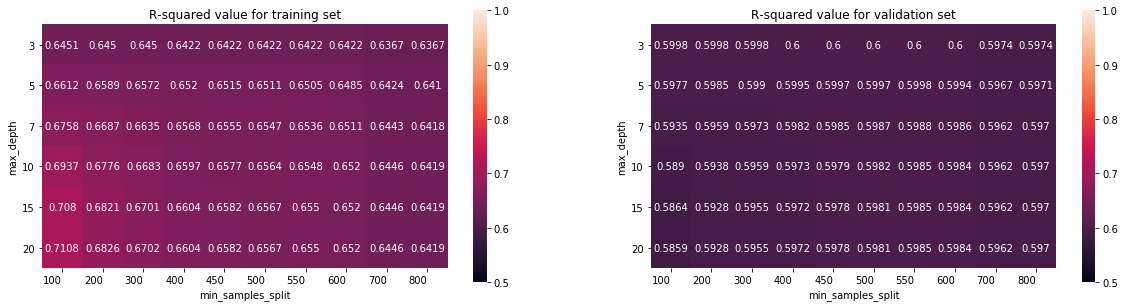

In [55]:
plt.figure(figsize=(20,5))
plt.subplot(121)
ax=sns.heatmap(train_r2_score_list,annot=True,square=True,fmt='.4g',vmin=0.5,vmax=1)
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')
plt.title('R-squared value for training set')
ax.set_xticklabels(alpha,rotation=0, horizontalalignment='right');
ax.set_yticklabels(max_depth,rotation=0, horizontalalignment='right');
plt.subplot(122)
ax=sns.heatmap(val_r2_score_list,annot=True,square=True,fmt='.4g',vmin=0.5,vmax=1)
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')
plt.title('R-squared value for validation set')
ax.set_xticklabels(alpha,rotation=0, horizontalalignment='right');
ax.set_yticklabels(max_depth,rotation=0, horizontalalignment='right');

In [58]:
alpha[np.argmax(val_r2_score_list[0])]

600

Best value of hyperparameters:
max_depth = 3, min_samples_split = 600

<h3>2.1.3 RandomSearchCV</h3>

In [59]:
clf = RandomForestRegressor()
params = {'n_estimators':[100,500,1000,1200],'max_depth':[3,5,7,10,15,20],
          'min_samples_split':[100,200,300,400,450,500,550,600,700,800],'min_samples_leaf':[10,20,30,40,50,80]}
random_clf = RandomizedSearchCV(clf,param_distributions=params,verbose=5,n_jobs=-1,
                                return_train_score=True,n_iter=30,scoring='r2',cv=5)
random_clf.fit(X_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] min_samples_split=700, n_estimators=100, max_depth=15, min_samples_leaf=80 
[CV] min_samples_split=700, n_estimators=100, max_depth=15, min_samples_leaf=80 
[CV] min_samples_split=700, n_estimators=100, max_depth=15, min_samples_leaf=80 
[CV] min_samples_split=700, n_estimators=100, max_depth=15, min_samples_leaf=80 
[CV] min_samples_split=700, n_estimators=100, max_depth=15, min_samples_leaf=80 
[CV] min_samples_split=800, n_estimators=500, max_depth=5, min_samples_leaf=30 
[CV] min_samples_split=800, n_estimators=500, max_depth=5, min_samples_leaf=30 
[CV] min_samples_split=800, n_estimators=500, max_depth=5, min_samples_leaf=30 
[CV]  min_samples_split=700, n_estimators=100, max_depth=15, min_samples_leaf=80, score=0.6650943593853729, total=   3.0s
[CV] min_samples_split=800, n_estimators=500, max_depth=5, min_samples_leaf=30 
[CV]  min_samples_split=700, n_estimators=100, max_depth=15, min_samples_leaf=80, score=0.5

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.2s


[CV]  min_samples_split=800, n_estimators=500, max_depth=5, min_samples_leaf=30, score=0.5685927902896035, total=  12.5s
[CV] min_samples_split=800, n_estimators=500, max_depth=5, min_samples_leaf=80 
[CV]  min_samples_split=800, n_estimators=500, max_depth=5, min_samples_leaf=30, score=0.6288386105990089, total=  12.7s
[CV] min_samples_split=800, n_estimators=500, max_depth=5, min_samples_leaf=80 
[CV]  min_samples_split=800, n_estimators=500, max_depth=5, min_samples_leaf=30, score=0.5500065481246675, total=  12.7s
[CV] min_samples_split=100, n_estimators=500, max_depth=20, min_samples_leaf=40 
[CV]  min_samples_split=800, n_estimators=500, max_depth=5, min_samples_leaf=80, score=0.6094157668444474, total=  12.0s
[CV] min_samples_split=100, n_estimators=500, max_depth=20, min_samples_leaf=40 
[CV]  min_samples_split=800, n_estimators=500, max_depth=5, min_samples_leaf=80, score=0.5411884493533494, total=  12.0s
[CV] min_samples_split=100, n_estimators=500, max_depth=20, min_samples_l

[CV] min_samples_split=550, n_estimators=500, max_depth=10, min_samples_leaf=10 
[CV]  min_samples_split=700, n_estimators=500, max_depth=15, min_samples_leaf=80, score=0.573467172765276, total=  14.9s
[CV] min_samples_split=550, n_estimators=500, max_depth=10, min_samples_leaf=10 
[CV]  min_samples_split=700, n_estimators=500, max_depth=15, min_samples_leaf=80, score=0.628436534936927, total=  15.2s
[CV] min_samples_split=300, n_estimators=1000, max_depth=20, min_samples_leaf=20 
[CV]  min_samples_split=700, n_estimators=500, max_depth=15, min_samples_leaf=80, score=0.5786275606508338, total=  14.6s
[CV] min_samples_split=300, n_estimators=1000, max_depth=20, min_samples_leaf=20 
[CV]  min_samples_split=700, n_estimators=500, max_depth=15, min_samples_leaf=80, score=0.6503112972070072, total=  14.9s
[CV] min_samples_split=300, n_estimators=1000, max_depth=20, min_samples_leaf=20 
[CV]  min_samples_split=550, n_estimators=500, max_depth=10, min_samples_leaf=10, score=0.6835249736283013

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.4min


[CV]  min_samples_split=450, n_estimators=500, max_depth=15, min_samples_leaf=80, score=0.578727185221185, total=  19.4s
[CV] min_samples_split=450, n_estimators=500, max_depth=15, min_samples_leaf=80 
[CV]  min_samples_split=450, n_estimators=500, max_depth=15, min_samples_leaf=80, score=0.6324961948787959, total=  19.6s
[CV] min_samples_split=400, n_estimators=100, max_depth=5, min_samples_leaf=30 
[CV]  min_samples_split=400, n_estimators=100, max_depth=5, min_samples_leaf=30, score=0.6868321884534854, total=   4.4s
[CV] min_samples_split=400, n_estimators=100, max_depth=5, min_samples_leaf=30 
[CV]  min_samples_split=400, n_estimators=100, max_depth=5, min_samples_leaf=30, score=0.5881019394786646, total=   4.2s
[CV] min_samples_split=400, n_estimators=100, max_depth=5, min_samples_leaf=30 
[CV]  min_samples_split=300, n_estimators=1000, max_depth=20, min_samples_leaf=20, score=0.5892709719790601, total=  48.5s
[CV] min_samples_split=400, n_estimators=100, max_depth=5, min_samples_

[CV] min_samples_split=200, n_estimators=100, max_depth=10, min_samples_leaf=50 
[CV]  min_samples_split=200, n_estimators=100, max_depth=10, min_samples_leaf=50, score=0.5872607578222595, total=   5.0s
[CV] min_samples_split=400, n_estimators=100, max_depth=5, min_samples_leaf=20 
[CV]  min_samples_split=200, n_estimators=100, max_depth=10, min_samples_leaf=50, score=0.6453126922400043, total=   5.2s
[CV] min_samples_split=400, n_estimators=100, max_depth=5, min_samples_leaf=20 
[CV]  min_samples_split=200, n_estimators=100, max_depth=10, min_samples_leaf=50, score=0.6023366485844445, total=   5.3s
[CV] min_samples_split=400, n_estimators=100, max_depth=5, min_samples_leaf=20 
[CV]  min_samples_split=400, n_estimators=100, max_depth=5, min_samples_leaf=20, score=0.6877744251741995, total=   4.5s
[CV] min_samples_split=400, n_estimators=100, max_depth=5, min_samples_leaf=20 
[CV]  min_samples_split=200, n_estimators=100, max_depth=10, min_samples_leaf=50, score=0.6697687163181423, tota

[CV] min_samples_split=100, n_estimators=1200, max_depth=20, min_samples_leaf=40 
[CV]  min_samples_split=100, n_estimators=1200, max_depth=7, min_samples_leaf=80, score=0.5881237044543665, total= 1.0min
[CV] min_samples_split=100, n_estimators=1200, max_depth=20, min_samples_leaf=40 
[CV]  min_samples_split=100, n_estimators=1200, max_depth=7, min_samples_leaf=80, score=0.651428544474725, total= 1.1min
[CV] min_samples_split=100, n_estimators=1200, max_depth=20, min_samples_leaf=40 
[CV]  min_samples_split=600, n_estimators=1200, max_depth=7, min_samples_leaf=40, score=0.5826057748230602, total=  40.2s
[CV] min_samples_split=100, n_estimators=1200, max_depth=20, min_samples_leaf=40 
[CV]  min_samples_split=600, n_estimators=1200, max_depth=7, min_samples_leaf=40, score=0.6838693700128656, total=  40.7s
[CV] min_samples_split=100, n_estimators=1200, max_depth=20, min_samples_leaf=40 
[CV]  min_samples_split=600, n_estimators=1200, max_depth=7, min_samples_leaf=40, score=0.6405120221485

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  8.3min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=30, n_jobs=-1,
          param_distributions={'min_samples_split': [100, 200, 300, 400, 450, 500, 550, 600, 700, 800], 'n_estimators': [100, 500, 1000, 1200], 'max_depth': [3, 5, 7, 10, 15, 20], 'min_samples_leaf': [10, 20, 30, 40, 50, 80]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='r2', verbose=5)

In [60]:
best_params = random_clf.best_params_
best_params

{'max_depth': 5,
 'min_samples_leaf': 20,
 'min_samples_split': 200,
 'n_estimators': 1200}

In [61]:
clf = RandomForestRegressor(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth'],
                        min_samples_split=best_params['min_samples_leaf'],min_samples_leaf=best_params['min_samples_leaf'],
                        n_jobs=-1,random_state=25)
clf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=20, min_samples_split=20,
           min_weight_fraction_leaf=0.0, n_estimators=1200, n_jobs=-1,
           oob_score=False, random_state=25, verbose=0, warm_start=False)

In [62]:
#R2 value
print('Train R-squared value:',clf.score(X_train,y_train))
print('Val R-squared value:',clf.score(X_val,y_val))

Train R-squared value: 0.660194130528589
Val R-squared value: 0.5975484689565893


<h3>2.2. Best Random Forest model</h3>

In [68]:
best_params = {'max_depth': 3, 'min_samples_leaf': 20, 'min_samples_split': 600, 'n_estimators': 500}

In [69]:
clf = RandomForestRegressor(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth'],
                        min_samples_split=best_params['min_samples_leaf'],min_samples_leaf=best_params['min_samples_leaf'],
                        n_jobs=-1,random_state=25)
clf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=20, min_samples_split=20,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=25, verbose=0, warm_start=False)

In [70]:
#R2 value
print('Train R-squared value:',clf.score(X_train,y_train))
print('Val R-squared value:',clf.score(X_val,y_val))

Train R-squared value: 0.642961209238161
Val R-squared value: 0.6010991422097172


Text(0.5, 0, 'Relative Importance')

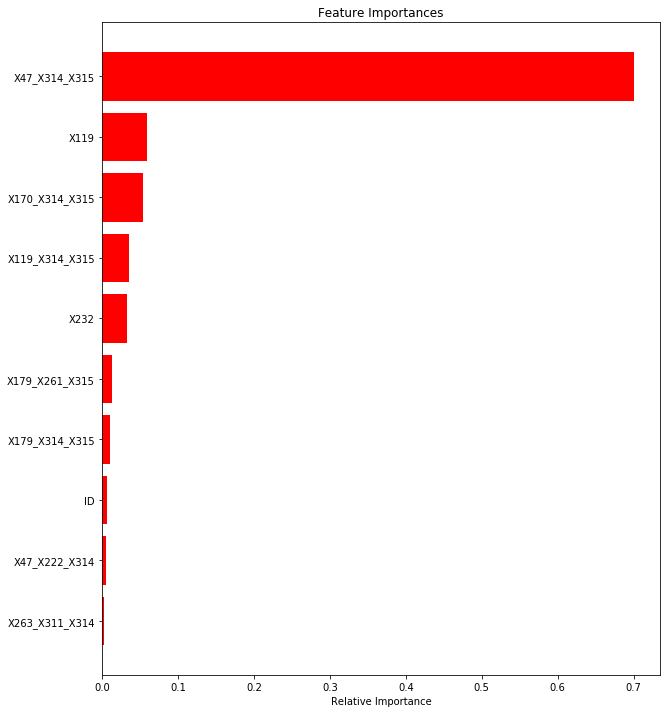

In [71]:
features = X_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-10:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')

In [72]:
indices2 = np.argsort(importances)[::-1] #Sort importances in descending order, get indices

In [73]:
for i,j in enumerate(np.cumsum(importances[indices2])):
    if j>0.99:
        indices3 = np.argsort(importances)[::-1][:i]
        break

In [74]:
rf_features_selected = [features[i] for i in indices3]
len(rf_features_selected)

76

In [75]:
rf_features_selected

['X47_X314_X315',
 'X119',
 'X170_X314_X315',
 'X119_X314_X315',
 'X232',
 'X179_X261_X315',
 'X179_X314_X315',
 'ID',
 'X47_X222_X314',
 'X263_X311_X314',
 'X263_X305_X314',
 'X82_X261_X263',
 'X255_X261_X263',
 'X261_X263_X376',
 'X47_X261_X263',
 'X261_X263_X275',
 'X41_X263_X314',
 'X263_X314_X379',
 'X261_X263_X306',
 'X69_X263_X314',
 'X261_X263_X284',
 'X263_X284_X314',
 'X261_X263_X340',
 'X255_X263_X314',
 'X197_X263_X314',
 'X263_X314_X315',
 'X203_X261_X263',
 'X261_X263_X264',
 'X47_X263_X314',
 'X57_X261_X263',
 'X263_X264_X314',
 'X5',
 'X263_X314_X345',
 'X175_X261_X263',
 'X263_X306_X314',
 'X203_X263_X314',
 'X10_X263_X314',
 'X231_X261_X263',
 'X130_X263_X314',
 'X131_X263_X314',
 'X222_X263_X314',
 'X13_X263_X314',
 'X263_X314_X342',
 'X263_X314_X333',
 'X263_X314_X340',
 'X44_X261_X263',
 'X173_X263_X314',
 'X198_X261_X263',
 'X52_X189_X314',
 'X130_X261_X263',
 'X263',
 'X189_X264_X314',
 'X77_X261_X263',
 'X263_X314_X376',
 'X263_X275_X314',
 'X189_X261_X264',
 'X

In [77]:
#Random Forest algorithm is used for feature selection 
top_features = rf_features_selected

In [78]:
#Save top_features
np.save('top_features.npy',top_features)

<h2>3. Modeling

<h3>3.1. Linear Regression

In [106]:
top_features = np.load('top_features.npy')

In [107]:
#Considering top 5 features
top_features = top_features[:5]

<h3>3.1.1. Hyperparameter tuning

<h3>3.1.1.1. L1 Regularisation</h3>

In [141]:
alpha = [1e-3,5e-3,0.01,0.05,0.1,0.5,1,5]
train_r2_score_list=[]
val_r2_score_list=[]
for i in tqdm(alpha):
    clf = SGDRegressor(loss='squared_loss',penalty='l1',alpha=i,random_state=42)
    clf.fit(X_train[top_features],y_train)
    train_r2_score_list.append(clf.score(X_train[top_features],y_train))
    val_r2_score_list.append(clf.score(X_val[top_features],y_val))

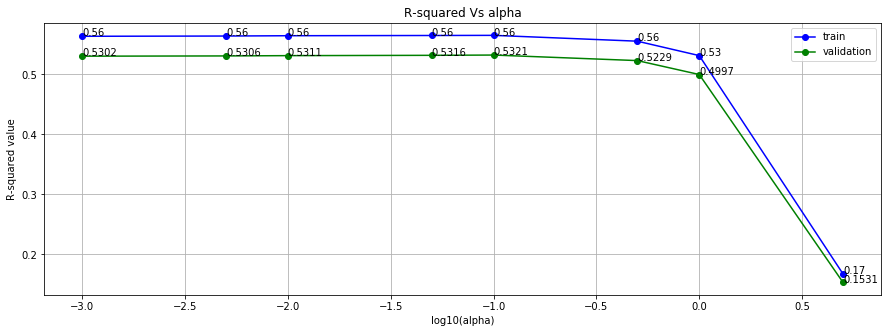

In [142]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(np.log10(alpha),train_r2_score_list,'bo-',label='train')
ax.plot(np.log10(alpha),val_r2_score_list,'go-',label='validation')
for i in range(len(alpha)):
    ax.text(np.log10(alpha[i]),train_r2_score_list[i],s=np.round(train_r2_score_list[i],2))
    ax.text(np.log10(alpha[i]),val_r2_score_list[i],s=np.round(val_r2_score_list[i],4))
plt.xlabel('log10(alpha)')
plt.grid()
plt.ylabel('R-squared value')
plt.title('R-squared Vs alpha')
plt.legend()

Best value of hyperparameters: alpha = 0.1

<h3>3.1.1.2 L2 Regularisation</h3>

In [143]:
alpha = [1e-3,5e-3,0.01,0.05,0.1,0.5,1,5,10,15,20]
train_r2_score_list=[]
val_r2_score_list=[]
for i in tqdm(alpha):
    clf = SGDRegressor(loss='squared_loss',penalty='l2',alpha=i,random_state=42)
    clf.fit(X_train[top_features],y_train)
    train_r2_score_list.append(clf.score(X_train[top_features],y_train))
    val_r2_score_list.append(clf.score(X_val[top_features],y_val))

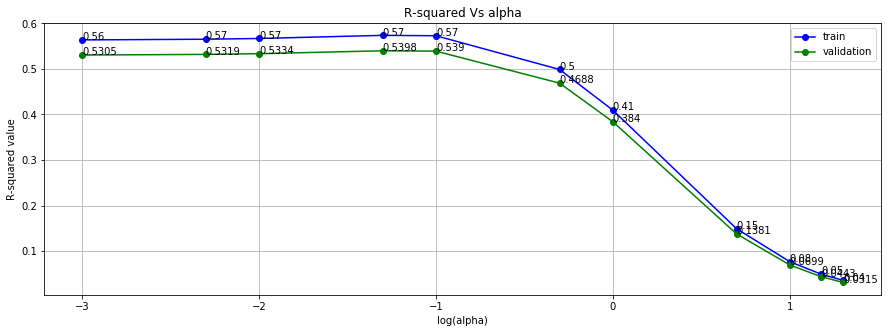

In [145]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(np.log10(alpha),train_r2_score_list,'bo-',label='train')
ax.plot(np.log10(alpha),val_r2_score_list,'go-',label='validation')
for i in range(len(alpha)):
    ax.text(np.log10(alpha[i]),train_r2_score_list[i],s=np.round(train_r2_score_list[i],2))
    ax.text(np.log10(alpha[i]),val_r2_score_list[i],s=np.round(val_r2_score_list[i],4))
plt.xlabel('log(alpha)')
plt.grid()
plt.ylabel('R-squared value')
plt.title('R-squared Vs alpha')
plt.legend()

Best value of hyperparameters: alpha = 0.05

<h3>3.1.1.3 ElasticNet Regularisation</h3>

In [146]:
alpha = [1e-3,5e-3,0.01,0.05,0.1,0.5,1,5,10]
l1_ratio = [1e-3,5e-3,0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.4,0.5,0.6,0.7]
train_r2_score_list=[]
val_r2_score_list=[]
for i in tqdm(alpha):
    train_a = []
    val_a = []
    for j in (l1_ratio):
        clf = SGDRegressor(loss='squared_loss',penalty='elasticnet',alpha=i,l1_ratio=j,random_state=42)
        clf.fit(X_train[top_features],y_train)
        train_a.append(clf.score(X_train[top_features],y_train))
        val_a.append(clf.score(X_val[top_features],y_val))
    train_r2_score_list.append(train_a)
    val_r2_score_list.append(val_a)

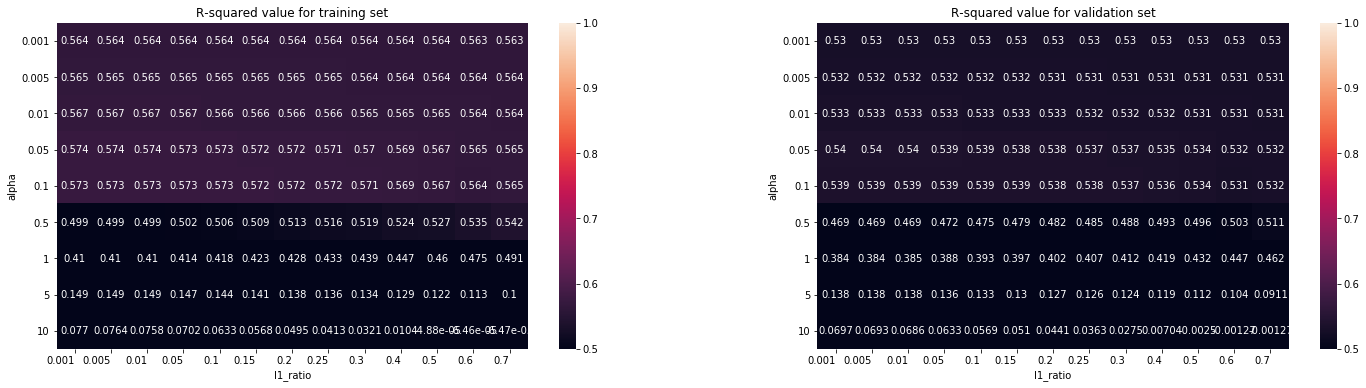

In [147]:
plt.figure(figsize=(25,6))
plt.subplot(121)
ax=sns.heatmap(train_r2_score_list,annot=True,square=True,fmt='.3g',vmin=0.5,vmax=1)
plt.xlabel('l1_ratio')
plt.ylabel('alpha')
plt.title('R-squared value for training set')
ax.set_xticklabels(l1_ratio,rotation=0, horizontalalignment='right');
ax.set_yticklabels(alpha,rotation=0, horizontalalignment='right');
plt.subplot(122)
ax=sns.heatmap(val_r2_score_list,annot=True,square=True,fmt='.3g',vmin=0.5,vmax=1)
plt.xlabel('l1_ratio')
plt.ylabel('alpha')
plt.title('R-squared value for validation set')
ax.set_xticklabels(l1_ratio,rotation=0, horizontalalignment='right');
ax.set_yticklabels(alpha,rotation=0, horizontalalignment='right');

In [148]:
l1_ratio[np.argmax(val_r2_score_list[3])]

0.001

Best value of hyperparameters: alpha = 0.05, l1_ratio = 0.001

<h3>3.1.2 Best Linear Regression model

In [150]:
#Best params
best_params={'penalty':'elasticnet','alpha':0.05,'l1_ratio':0.001}

In [151]:
clf = SGDRegressor(loss='squared_loss',penalty=best_params['penalty'],alpha=best_params['alpha'],
                   l1_ratio=best_params['l1_ratio'], random_state=25)
clf.fit(X_train[top_features],y_train)    

SGDRegressor(alpha=0.05, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.001, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=None,
       penalty='elasticnet', power_t=0.25, random_state=25, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [152]:
#R2 value
print('Train R-squared value:',clf.score(X_train[top_features],y_train))
print('Val R-squared value:',clf.score(X_val[top_features],y_val))

Train R-squared value: 0.5741995815385684
Val R-squared value: 0.5412320965246644


In [1]:
#Dictionary with algorithm as key and r2 value as value
algo_val={}
algo_val['LR'] =  0.541

<h3>3.2. Linear SVM</h3>

In [194]:
top_features = np.load('top_features.npy')

In [195]:
#Considering top 15 features
top_features = top_features[:15]

<h3>3.2.1. Hyperparameter tuning

<h3>3.2.1.1 L1 regularisation

In [196]:
alpha = [0.1,0.5,5,10,25,30,35,40,50]
epsilon = [0.01,0.05,0.1,0.5,5,10]
train_r2_score_list=[]
val_r2_score_list=[]
for i in tqdm(alpha):
    train_a = []
    val_a = []
    for j in epsilon:
        clf = LinearSVR(loss='epsilon_insensitive',C=i,epsilon=j,random_state=42)
        clf.fit(X_train[top_features],y_train)
        train_a.append(clf.score(X_train[top_features],y_train))
        val_a.append(clf.score(X_val[top_features],y_val))
    train_r2_score_list.append(train_a)
    val_r2_score_list.append(val_a)

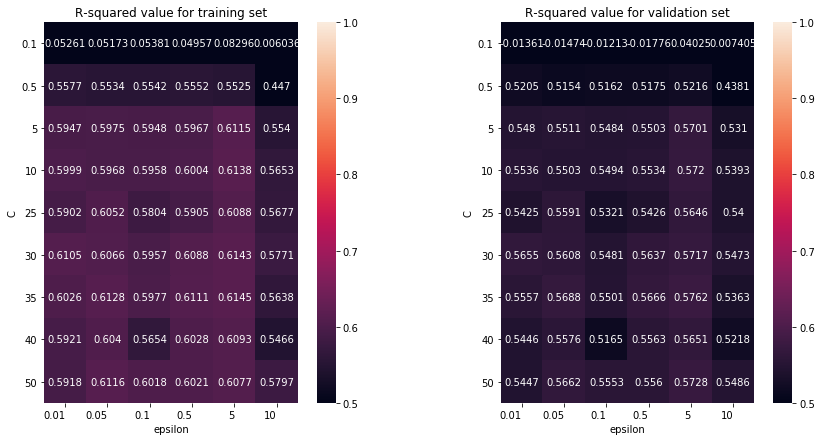

In [197]:
plt.figure(figsize=(15,7))
plt.subplot(121)
ax=sns.heatmap(train_r2_score_list,annot=True,square=True,fmt='.4g',vmin=0.5,vmax=1)
plt.xlabel('epsilon')
plt.ylabel('C')
plt.title('R-squared value for training set')
ax.set_xticklabels(epsilon,rotation=0, horizontalalignment='right');
ax.set_yticklabels(alpha,rotation=0, horizontalalignment='right');
plt.subplot(122)
ax=sns.heatmap(val_r2_score_list,annot=True,square=True,fmt='.4g',vmin=0.5,vmax=1)
plt.xlabel('epsilon')
plt.ylabel('C')
plt.title('R-squared value for validation set')
ax.set_xticklabels(epsilon,rotation=0, horizontalalignment='right');
ax.set_yticklabels(alpha,rotation=0, horizontalalignment='right');

Best value of hyperparameters: C = 35, epsilon = 5

<h3>3.2.1.2 L2 regularisation

In [198]:
alpha = [0.1,0.5,5,10,25,30,35,40,50]
epsilon = [0.01,0.05,0.1,0.5,5,10]
train_r2_score_list=[]
val_r2_score_list=[]
for i in tqdm(alpha):
    train_a = []
    val_a = []
    for j in epsilon:
        clf = LinearSVR(loss='squared_epsilon_insensitive',C=i,epsilon=j,random_state=42)
        clf.fit(X_train[top_features],y_train)
        train_a.append(clf.score(X_train[top_features],y_train))
        val_a.append(clf.score(X_val[top_features],y_val))
    train_r2_score_list.append(train_a)
    val_r2_score_list.append(val_a)

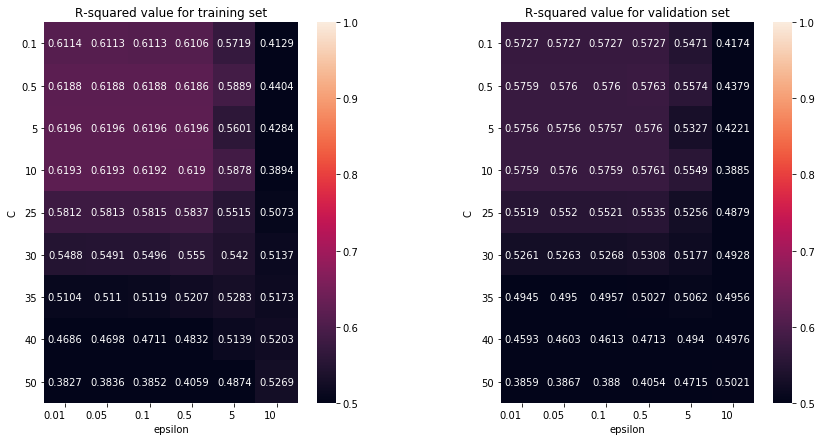

In [199]:
plt.figure(figsize=(15,7))
plt.subplot(121)
ax=sns.heatmap(train_r2_score_list,annot=True,square=True,fmt='.4g',vmin=0.5,vmax=1)
plt.xlabel('epsilon')
plt.ylabel('C')
plt.title('R-squared value for training set')
ax.set_xticklabels(epsilon,rotation=0, horizontalalignment='right');
ax.set_yticklabels(alpha,rotation=0, horizontalalignment='right');
plt.subplot(122)
ax=sns.heatmap(val_r2_score_list,annot=True,square=True,fmt='.4g',vmin=0.5,vmax=1)
plt.xlabel('epsilon')
plt.ylabel('C')
plt.title('R-squared value for validation set')
ax.set_xticklabels(epsilon,rotation=0, horizontalalignment='right');
ax.set_yticklabels(alpha,rotation=0, horizontalalignment='right');

Best value of hyperparameters: C = 0.5, epsilon = 0.5

<h3>3.2.2. Best model for SVR

In [200]:
#Best params
best_params={'loss':'squared_epsilon_insensitive','C':0.5,'epsilon':0.5}

In [201]:
clf = LinearSVR(loss=best_params['loss'],C=best_params['C'],epsilon=best_params['epsilon'],random_state=50)
clf.fit(X_train[top_features],y_train)    

LinearSVR(C=0.5, dual=True, epsilon=0.5, fit_intercept=True,
     intercept_scaling=1.0, loss='squared_epsilon_insensitive',
     max_iter=1000, random_state=50, tol=0.0001, verbose=0)

In [202]:
#R2 value
print('Train R-squared value:',clf.score(X_train[top_features],y_train))
print('Val R-squared value:',clf.score(X_val[top_features],y_val))

Train R-squared value: 0.6186193722142268
Val R-squared value: 0.5762803746222586


In [2]:
algo_val['Linear SVR'] =  0.576

<h3>3.3. Kernel SVM</h3>

In [230]:
top_features = np.load('top_features.npy')

In [231]:
#Considering top 10 features
top_features = top_features[:10]

<h3>3.3.1. Hyperparameter tuning

<h3>3.3.1.1 C Vs gamma

In [235]:
alpha = [0.1,0.5,5,10,25,30,35,40,50]
gamma = [0.01,0.05,0.1,0.5,1,5,10]
train_r2_score_list=[]
val_r2_score_list=[]
for i in tqdm(alpha):
    train_a = []
    val_a = []
    for j in gamma:
        clf = SVR(kernel='rbf',C=i,gamma=j)
        clf.fit(X_train[top_features],y_train)
        train_a.append(clf.score(X_train[top_features],y_train))
        val_a.append(clf.score(X_val[top_features],y_val))
    train_r2_score_list.append(train_a)
    val_r2_score_list.append(val_a)

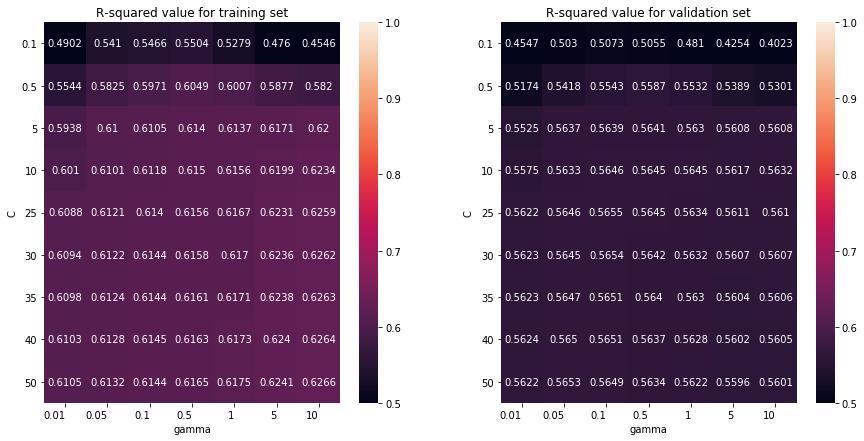

In [236]:
plt.figure(figsize=(15,7))
plt.subplot(121)
ax=sns.heatmap(train_r2_score_list,annot=True,square=True,fmt='.4g',vmin=0.5,vmax=1)
plt.xlabel('gamma')
plt.ylabel('C')
plt.title('R-squared value for training set')
ax.set_xticklabels(gamma,rotation=0, horizontalalignment='right');
ax.set_yticklabels(alpha,rotation=0, horizontalalignment='right');
plt.subplot(122)
ax=sns.heatmap(val_r2_score_list,annot=True,square=True,fmt='.4g',vmin=0.5,vmax=1)
plt.xlabel('gamma')
plt.ylabel('C')
plt.title('R-squared value for validation set')
ax.set_xticklabels(gamma,rotation=0, horizontalalignment='right');
ax.set_yticklabels(alpha,rotation=0, horizontalalignment='right');

Best value of hyperparameters: C = 25, gamma = 0.1

<h3>3.3.1.2 C Vs epsilon

In [237]:
alpha = [0.1,0.5,5,10,25,30,35,40,50]
epsilon = [0.01,0.05,0.1,0.5,5,10]
train_r2_score_list=[]
val_r2_score_list=[]
for i in tqdm(alpha):
    train_a = []
    val_a = []
    for j in epsilon:
        clf = SVR(C=i,gamma=0.1,epsilon=j)
        clf.fit(X_train[top_features],y_train)
        train_a.append(clf.score(X_train[top_features],y_train))
        val_a.append(clf.score(X_val[top_features],y_val))
    train_r2_score_list.append(train_a)
    val_r2_score_list.append(val_a)

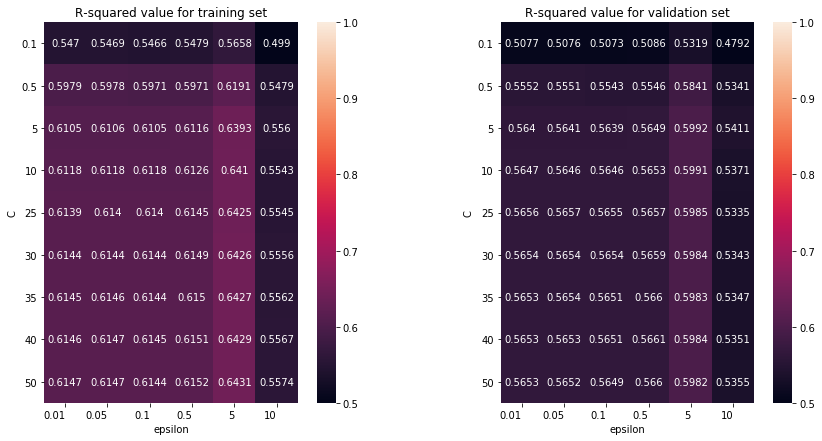

In [238]:
plt.figure(figsize=(15,7))
plt.subplot(121)
ax=sns.heatmap(train_r2_score_list,annot=True,square=True,fmt='.4g',vmin=0.5,vmax=1)
plt.xlabel('epsilon')
plt.ylabel('C')
plt.title('R-squared value for training set')
ax.set_xticklabels(epsilon,rotation=0, horizontalalignment='right');
ax.set_yticklabels(alpha,rotation=0, horizontalalignment='right');
plt.subplot(122)
ax=sns.heatmap(val_r2_score_list,annot=True,square=True,fmt='.4g',vmin=0.5,vmax=1)
plt.xlabel('epsilon')
plt.ylabel('C')
plt.title('R-squared value for validation set')
ax.set_xticklabels(epsilon,rotation=0, horizontalalignment='right');
ax.set_yticklabels(alpha,rotation=0, horizontalalignment='right');

Best value of hyperparameters: C = 5, epsilon = 5

<h3>3.3.1.3 RandomSearchCV</h3>

In [239]:
clf = SVR()
params = {'C':[0.1,0.5,5,10,25,30,35,40,50],'epsilon':[0.01,0.05,0.1,0.5,5,10],
          'gamma':[0.01,0.05,0.1,0.5,1,5,10]}
random_clf = RandomizedSearchCV(clf,param_distributions=params,verbose=5,n_jobs=-1,
                                return_train_score=True,n_iter=30,scoring='r2',cv=5)
random_clf.fit(X_train,y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] C=0.1, epsilon=0.05, gamma=0.05 .................................
[CV] C=0.1, epsilon=0.05, gamma=0.05 .................................
[CV] C=0.1, epsilon=0.05, gamma=0.05 .................................
[CV] C=0.1, epsilon=0.05, gamma=0.05 .................................
[CV] C=0.1, epsilon=0.05, gamma=0.05 .................................
[CV] C=40, epsilon=10, gamma=10 ......................................
[CV] C=40, epsilon=10, gamma=10 ......................................
[CV] C=40, epsilon=10, gamma=10 ......................................
[CV]  C=40, epsilon=10, gamma=10, score=0.08474393083593723, total=   3.8s
[CV] C=40, epsilon=10, gamma=10 ......................................
[CV]  C=40, epsilon=10, gamma=10, score=0.10172335832844936, total=   3.8s
[CV]  C=40, epsilon=10, gamma=10, score=0.10759966200288329, total=   3.8s
[CV] C=40, epsilon=10, gamma=10 ......................................
[CV

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.0s


[CV]  C=40, epsilon=10, gamma=10, score=0.07331109008938141, total=   3.8s
[CV] C=0.5, epsilon=0.5, gamma=0.5 ...................................
[CV]  C=40, epsilon=10, gamma=10, score=0.10408893432712185, total=   3.9s
[CV] C=0.5, epsilon=0.5, gamma=0.5 ...................................
[CV]  C=0.1, epsilon=0.05, gamma=0.05, score=0.3990138915073772, total=   8.9s
[CV] C=0.5, epsilon=0.5, gamma=0.5 ...................................
[CV]  C=0.1, epsilon=0.05, gamma=0.05, score=0.34803147891222885, total=   9.0s
[CV] C=0.5, epsilon=0.5, gamma=0.5 ...................................
[CV]  C=0.1, epsilon=0.05, gamma=0.05, score=0.37749882918430866, total=   9.3s
[CV] C=5, epsilon=0.1, gamma=10 ......................................
[CV]  C=0.1, epsilon=0.05, gamma=0.05, score=0.348851262751131, total=   9.4s
[CV] C=5, epsilon=0.1, gamma=10 ......................................
[CV]  C=0.1, epsilon=0.05, gamma=0.05, score=0.3272279386117617, total=   9.5s
[CV] C=5, epsilon=0.1, gamma

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.8min


[CV]  C=10, epsilon=0.5, gamma=0.01, score=0.6101846419515752, total=   8.4s
[CV] C=5, epsilon=0.1, gamma=1 .......................................
[CV]  C=50, epsilon=0.1, gamma=0.01, score=0.6273081995576919, total=   9.2s
[CV] C=0.5, epsilon=0.5, gamma=1 .....................................
[CV]  C=10, epsilon=0.5, gamma=0.01, score=0.56861425111231, total=   8.3s
[CV] C=0.5, epsilon=0.5, gamma=1 .....................................
[CV]  C=10, epsilon=0.5, gamma=0.01, score=0.6453026936081376, total=   8.3s
[CV] C=0.5, epsilon=0.5, gamma=1 .....................................
[CV]  C=5, epsilon=0.1, gamma=1, score=0.24990957027276484, total=   9.2s
[CV] C=0.5, epsilon=0.5, gamma=1 .....................................
[CV]  C=5, epsilon=0.1, gamma=1, score=0.22715988430721323, total=   9.1s
[CV] C=0.5, epsilon=0.5, gamma=1 .....................................
[CV]  C=5, epsilon=0.1, gamma=1, score=0.2645258901505916, total=   9.1s
[CV] C=10, epsilon=0.5, gamma=5 ...............

[CV]  C=10, epsilon=0.05, gamma=5, score=0.20856454620745846, total=   9.2s
[CV] C=30, epsilon=0.05, gamma=0.5 ...................................
[CV]  C=10, epsilon=0.05, gamma=5, score=0.16507267389097136, total=   9.2s
[CV]  C=10, epsilon=0.05, gamma=5, score=0.20957066320961615, total=   9.1s
[CV] C=30, epsilon=0.05, gamma=0.5 ...................................
[CV] C=30, epsilon=0.05, gamma=0.5 ...................................
[CV]  C=5, epsilon=0.5, gamma=10, score=0.13454809004675816, total=   8.8s
[CV] C=30, epsilon=0.05, gamma=0.5 ...................................
[CV]  C=5, epsilon=0.5, gamma=10, score=0.11073566770166643, total=   8.7s
[CV] C=30, epsilon=0.05, gamma=0.5 ...................................
[CV]  C=5, epsilon=0.5, gamma=10, score=0.16119881663477686, total=   8.7s
[CV] C=0.5, epsilon=0.01, gamma=0.01 .................................
[CV]  C=5, epsilon=0.5, gamma=10, score=0.11775607877829097, total=   8.6s
[CV] C=0.5, epsilon=0.01, gamma=0.01 .........

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  4.7min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=30, n_jobs=-1,
          param_distributions={'C': [0.1, 0.5, 5, 10, 25, 30, 35, 40, 50], 'epsilon': [0.01, 0.05, 0.1, 0.5, 5, 10], 'gamma': [0.01, 0.05, 0.1, 0.5, 1, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='r2', verbose=5)

In [240]:
best_params = random_clf.best_params_
best_params

{'C': 30, 'epsilon': 5, 'gamma': 0.01}

In [242]:
clf = SVR(C=best_params['C'],epsilon=best_params['epsilon'],gamma=best_params['gamma'])
clf.fit(X_train[top_features],y_train)

SVR(C=30, cache_size=200, coef0=0.0, degree=3, epsilon=5, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [243]:
#R2 value
print('Train R-squared value:',clf.score(X_train[top_features],y_train))
print('Val R-squared value:',clf.score(X_val[top_features],y_val))

Train R-squared value: 0.6346905729080136
Val R-squared value: 0.5958784685484613


<h3>3.3.2. Best model for SVR

In [245]:
#Best params
best_params={'C':5,'epsilon':5,'gamma':0.1}

In [246]:
clf = SVR(C=best_params['C'],epsilon=best_params['epsilon'],gamma=best_params['gamma'])
clf.fit(X_train[top_features],y_train)

SVR(C=5, cache_size=200, coef0=0.0, degree=3, epsilon=5, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [247]:
#R2 value
print('Train R-squared value:',clf.score(X_train[top_features],y_train))
print('Val R-squared value:',clf.score(X_val[top_features],y_val))

Train R-squared value: 0.6392756479721328
Val R-squared value: 0.5992239422864967


In [3]:
algo_val['Kernel SVR'] =  0.599

<h3>3.4. k-Nearest Neighbour

In [287]:
top_features = np.load('top_features.npy')

In [288]:
#Considering top 10 features
top_features = top_features[:5]

In [289]:
alpha = [5,9,25,55,75,85,95,101,121,131,151,171] #No of neighbours
train_r2_score_list = []
val_r2_score_list = []

for i in tqdm(alpha):
    clf = KNeighborsRegressor(n_neighbors=i,n_jobs=-1)
    clf.fit(X_train[top_features],y_train)
    train_r2_score_list.append(clf.score(X_train[top_features],y_train))
    val_r2_score_list.append(clf.score(X_val[top_features],y_val))

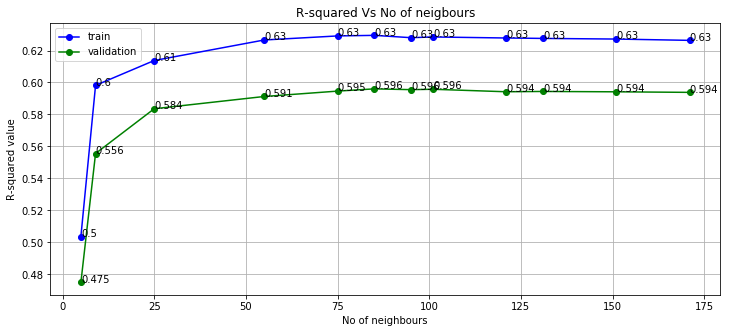

In [292]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(alpha,train_r2_score_list,'bo-',label='train')
ax.plot(alpha,val_r2_score_list,'go-',label='validation')
for i in range(len(alpha)):
    ax.text(alpha[i],train_r2_score_list[i],s=np.round(train_r2_score_list[i],2))
    ax.text(alpha[i],val_r2_score_list[i],s=np.round(val_r2_score_list[i],3))
plt.xlabel('No of neighbours')
plt.grid()
plt.ylabel('R-squared value')
plt.title('R-squared Vs No of neigbours')
plt.legend()

In [294]:
best_alpha = alpha[np.argmax(val_r2_score_list)]
best_alpha

85

In [295]:
clf = KNeighborsRegressor(n_neighbors=best_alpha,n_jobs=-1)
clf.fit(X_train[top_features],y_train)    

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=85, p=2,
          weights='uniform')

In [296]:
#R2 value
print('Train R-squared value:',clf.score(X_train[top_features],y_train))
print('Val R-squared value:',clf.score(X_val[top_features],y_val))

Train R-squared value: 0.629475001703024
Val R-squared value: 0.5960159285696712


In [4]:
algo_val['k-NN'] =  0.596

<h3>3.5. Decision Tree Regressor with RandomSearchCV</h3>

In [322]:
top_features = np.load('top_features.npy')

In [323]:
#Considering top 10 features
top_features = top_features[:10]

In [324]:
clf = DecisionTreeRegressor()
params = {'max_depth':[3,5,7,10,15],
          'min_samples_split':[100,200,300,400,450,500,550,600,700,800],'min_samples_leaf':[10,20,30,40,50,80]}
random_clf = RandomizedSearchCV(clf,param_distributions=params,verbose=5,n_jobs=-1,
                                return_train_score=True,n_iter=50,scoring='r2',cv=5)
random_clf.fit(X_train[top_features],y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] min_samples_split=100, max_depth=15, min_samples_leaf=80 ........
[CV] min_samples_split=100, max_depth=15, min_samples_leaf=80 ........
[CV]  min_samples_split=100, max_depth=15, min_samples_leaf=80, score=0.6824386002840321, total=   0.0s
[CV] min_samples_split=100, max_depth=15, min_samples_leaf=80 ........
[CV] min_samples_split=100, max_depth=15, min_samples_leaf=80 ........
[CV]  min_samples_split=100, max_depth=15, min_samples_leaf=80, score=0.5870495497147192, total=   0.0s
[CV]  min_samples_split=100, max_depth=15, min_samples_leaf=80, score=0.6355458900084285, total=   0.0s
[CV] min_samples_split=100, max_depth=15, min_samples_leaf=80 ........
[CV]  min_samples_split=100, max_depth=15, min_samples_leaf=80, score=0.5934014648528252, total=   0.0s
[CV] min_samples_split=500, max_depth=10, min_samples_leaf=10 ........
[CV] min_samples_split=500, max_depth=10, min_samples_leaf=10 ........
[CV]  min_samples_split=1

[CV] min_samples_split=700, max_depth=15, min_samples_leaf=30 ........
[CV] min_samples_split=500, max_depth=15, min_samples_leaf=80 ........
[CV] min_samples_split=200, max_depth=10, min_samples_leaf=20 ........
[CV]  min_samples_split=500, max_depth=10, min_samples_leaf=30, score=0.6653784594001158, total=   0.0s
[CV]  min_samples_split=500, max_depth=5, min_samples_leaf=30, score=0.6402204624269622, total=   0.0s
[CV]  min_samples_split=300, max_depth=15, min_samples_leaf=10, score=0.6771900238839161, total=   0.0s
[CV] min_samples_split=800, max_depth=15, min_samples_leaf=80 ........
[CV]  min_samples_split=600, max_depth=10, min_samples_leaf=80, score=0.5930380722393211, total=   0.0s
[CV] min_samples_split=600, max_depth=10, min_samples_leaf=80 ........
[CV] min_samples_split=300, max_depth=15, min_samples_leaf=10 ........
[CV]  min_samples_split=500, max_depth=7, min_samples_leaf=50, score=0.6635194670382782, total=   0.0s
[CV]  min_samples_split=500, max_depth=15, min_samples_l

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s


[CV] min_samples_split=700, max_depth=5, min_samples_leaf=40 .........
[CV]  min_samples_split=800, max_depth=15, min_samples_leaf=80, score=0.583482814060327, total=   0.0s
[CV]  min_samples_split=500, max_depth=15, min_samples_leaf=80, score=0.5930380722393211, total=   0.0s
[CV]  min_samples_split=500, max_depth=5, min_samples_leaf=30, score=0.6645400500440053, total=   0.0s
[CV]  min_samples_split=400, max_depth=5, min_samples_leaf=50, score=0.6860440327128413, total=   0.0s
[CV]  min_samples_split=700, max_depth=15, min_samples_leaf=30, score=0.6403536222024799, total=   0.0s
[CV] min_samples_split=800, max_depth=15, min_samples_leaf=80 ........
[CV]  min_samples_split=300, max_depth=15, min_samples_leaf=10, score=0.5968805964392999, total=   0.0s
[CV] min_samples_split=500, max_depth=15, min_samples_leaf=80 ........
[CV] min_samples_split=300, max_depth=15, min_samples_leaf=10 ........
[CV] min_samples_split=700, max_depth=15, min_samples_leaf=30 ........
[CV]  min_samples_split=

[CV]  min_samples_split=700, max_depth=5, min_samples_leaf=50, score=0.6680053967051653, total=   0.0s
[CV] min_samples_split=400, max_depth=15, min_samples_leaf=10 ........
[CV] min_samples_split=450, max_depth=15, min_samples_leaf=40 ........
[CV] min_samples_split=500, max_depth=10, min_samples_leaf=40 ........
[CV]  min_samples_split=400, max_depth=7, min_samples_leaf=40, score=0.6616660188243046, total=   0.0s
[CV]  min_samples_split=200, max_depth=7, min_samples_leaf=20, score=0.5930352879794663, total=   0.0s
[CV]  min_samples_split=400, max_depth=15, min_samples_leaf=10, score=0.6773002329798681, total=   0.0s
[CV] min_samples_split=400, max_depth=15, min_samples_leaf=10 ........
[CV] min_samples_split=550, max_depth=10, min_samples_leaf=10 ........
[CV]  min_samples_split=450, max_depth=15, min_samples_leaf=40, score=0.6806562282086803, total=   0.0s
[CV] min_samples_split=400, max_depth=7, min_samples_leaf=10 .........
[CV] min_samples_split=450, max_depth=15, min_samples_lea

[CV] min_samples_split=200, max_depth=7, min_samples_leaf=40 .........
[CV]  min_samples_split=500, max_depth=7, min_samples_leaf=30, score=0.5960798339185771, total=   0.0s
[CV] min_samples_split=500, max_depth=7, min_samples_leaf=30 .........
[CV]  min_samples_split=700, max_depth=7, min_samples_leaf=50, score=0.6398836689896479, total=   0.0s
[CV] min_samples_split=700, max_depth=5, min_samples_leaf=50 .........
[CV]  min_samples_split=450, max_depth=10, min_samples_leaf=80, score=0.5969942061941113, total=   0.0s
[CV]  min_samples_split=200, max_depth=7, min_samples_leaf=10, score=0.594793007695809, total=   0.0s
[CV]  min_samples_split=300, max_depth=7, min_samples_leaf=80, score=0.6331550885878992, total=   0.0s
[CV]  min_samples_split=200, max_depth=7, min_samples_leaf=40, score=0.6833556620186185, total=   0.0s
[CV] min_samples_split=200, max_depth=7, min_samples_leaf=10 .........
[CV] min_samples_split=200, max_depth=7, min_samples_leaf=40 .........
[CV] min_samples_split=700,

[CV]  min_samples_split=100, max_depth=10, min_samples_leaf=80, score=0.5934014648528252, total=   0.0s
[CV]  min_samples_split=100, max_depth=10, min_samples_leaf=50, score=0.5872616893570182, total=   0.0s
[CV]  min_samples_split=200, max_depth=10, min_samples_leaf=40, score=0.6324117385439281, total=   0.0s
[CV]  min_samples_split=800, max_depth=3, min_samples_leaf=20, score=0.6687487540647268, total=   0.0s
[CV] min_samples_split=200, max_depth=10, min_samples_leaf=40 ........
[CV] min_samples_split=450, max_depth=7, min_samples_leaf=30 .........
[CV]  min_samples_split=550, max_depth=5, min_samples_leaf=40, score=0.6862843339051008, total=   0.0s
[CV]  min_samples_split=300, max_depth=10, min_samples_leaf=80, score=0.6840590025641408, total=   0.0s
[CV]  min_samples_split=300, max_depth=10, min_samples_leaf=30, score=0.654538116138512, total=   0.0s
[CV] min_samples_split=550, max_depth=5, min_samples_leaf=40 .........
[CV] min_samples_split=700, max_depth=10, min_samples_leaf=80 

[Parallel(n_jobs=-1)]: Done 184 out of 250 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    0.7s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
          fit_params=None, iid=True, n_iter=50, n_jobs=-1,
          param_distributions={'min_samples_split': [100, 200, 300, 400, 450, 500, 550, 600, 700, 800], 'max_depth': [3, 5, 7, 10, 15], 'min_samples_leaf': [10, 20, 30, 40, 50, 80]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='r2', verbose=5)

In [325]:
best_params = random_clf.best_params_
best_params

{'max_depth': 5, 'min_samples_leaf': 40, 'min_samples_split': 700}

In [326]:
clf = DecisionTreeRegressor(max_depth=best_params['max_depth'],
                        min_samples_split=best_params['min_samples_split'],min_samples_leaf=best_params['min_samples_leaf'],
                        random_state=25)
clf.fit(X_train[top_features],y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=40,
           min_samples_split=700, min_weight_fraction_leaf=0.0,
           presort=False, random_state=25, splitter='best')

In [327]:
#R2 value
print('Train R-squared value:',clf.score(X_train[top_features],y_train))
print('Val R-squared value:',clf.score(X_val[top_features],y_val))

Train R-squared value: 0.6426548502554477
Val R-squared value: 0.5974807774464262


In [5]:
algo_val['DT'] =  0.597

<h3>3.6. Random Forest model</h3>

In [184]:
top_features = np.load('top_features.npy')

In [185]:
#Considering top 5 features
top_features = top_features[:20]

<h3>3.6.1. Hyperparmeter tuning</h3>

<h3>3.6.1.1. n_estimators Vs max_depth</h3>

In [228]:
alpha = [100,500,1000,1500]
max_depth = [3,5,7,10,15,20]
train_r2_score_list = []
val_r2_score_list = []

for i in tqdm(max_depth):
    train_a=[]
    val_a=[]
    for j in alpha:
        clf = RandomForestRegressor(n_estimators=j,max_depth=i,random_state=42,n_jobs=-1)
        clf.fit(X_train[top_features],y_train)
        train_a.append(clf.score(X_train[top_features],y_train))
        val_a.append(clf.score(X_val[top_features],y_val))
    train_r2_score_list.append(train_a)
    val_r2_score_list.append(val_a)

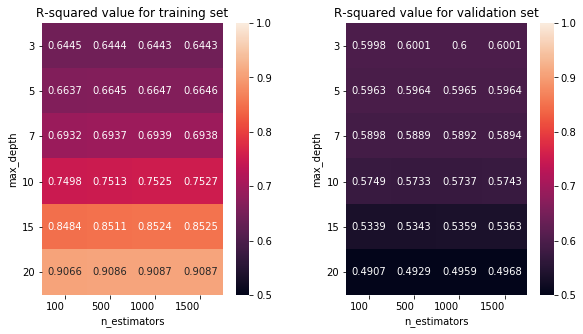

In [229]:
plt.figure(figsize=(10,5))
plt.subplot(121)
ax=sns.heatmap(train_r2_score_list,annot=True,square=True,fmt='.4g',vmin=0.5,vmax=1)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.title('R-squared value for training set')
ax.set_xticklabels(alpha,rotation=0, horizontalalignment='right');
ax.set_yticklabels(max_depth,rotation=0, horizontalalignment='right');
plt.subplot(122)
ax=sns.heatmap(val_r2_score_list,annot=True,square=True,fmt='.4g',vmin=0.5,vmax=1)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.title('R-squared value for validation set')
ax.set_xticklabels(alpha,rotation=0, horizontalalignment='right');
ax.set_yticklabels(max_depth,rotation=0, horizontalalignment='right');

In [230]:
alpha[np.argmax(val_r2_score_list[0])]

500

R-squared value for train and validation set are nearly same for different values of n_estimators for fixed value of max_depth.


Best value of hyperparameters:
n_estimators = 500, max_depth = 3 

<h3>3.6.1.2. min_samples_split Vs max_depth</h3>

In [ ]:
alpha = [100,200,300,400,450,500,550,600,700,800]  #min_samples_split
max_depth = [3,5,7,10,15,20]
train_r2_score_list = []
val_r2_score_list = []

for i in tqdm(max_depth):
    train_a=[]
    val_a=[]
    for j in alpha:
        clf = RandomForestRegressor(min_samples_split=j,n_estimators=500,max_depth=i,random_state=42,n_jobs=-1)
        clf.fit(X_train[top_features],y_train)
        train_a.append(clf.score(X_train[top_features],y_train))
        val_a.append(clf.score(X_val[top_features],y_val))
    train_r2_score_list.append(train_a)
    val_r2_score_list.append(val_a)

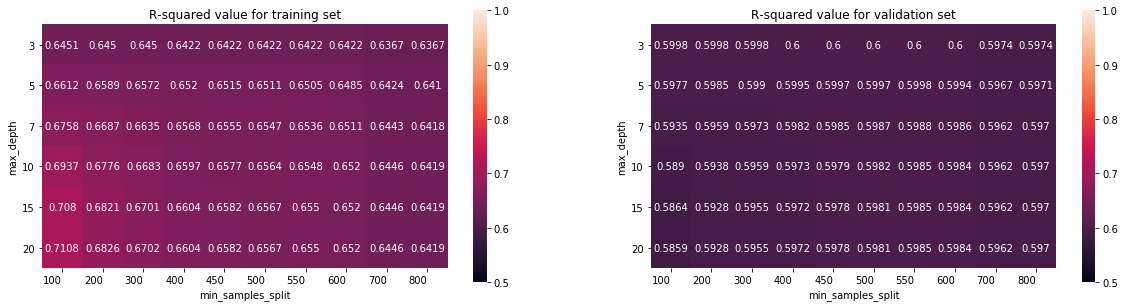

In [55]:
plt.figure(figsize=(20,5))
plt.subplot(121)
ax=sns.heatmap(train_r2_score_list,annot=True,square=True,fmt='.4g',vmin=0.5,vmax=1)
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')
plt.title('R-squared value for training set')
ax.set_xticklabels(alpha,rotation=0, horizontalalignment='right');
ax.set_yticklabels(max_depth,rotation=0, horizontalalignment='right');
plt.subplot(122)
ax=sns.heatmap(val_r2_score_list,annot=True,square=True,fmt='.4g',vmin=0.5,vmax=1)
plt.xlabel('min_samples_split')
plt.ylabel('max_depth')
plt.title('R-squared value for validation set')
ax.set_xticklabels(alpha,rotation=0, horizontalalignment='right');
ax.set_yticklabels(max_depth,rotation=0, horizontalalignment='right');

In [58]:
alpha[np.argmax(val_r2_score_list[0])]

600

Best value of hyperparameters:
max_depth = 3, min_samples_split = 600

<h3>3.6.1.3 RandomSearchCV</h3>

In [59]:
clf = RandomForestRegressor()
params = {'n_estimators':[100,500,1000,1200],'max_depth':[3,5,7,10,15,20],
          'min_samples_split':[100,200,300,400,450,500,550,600,700,800],'min_samples_leaf':[10,20,30,40,50,80]}
random_clf = RandomizedSearchCV(clf,param_distributions=params,verbose=5,n_jobs=-1,
                                return_train_score=True,n_iter=30,scoring='r2',cv=5)
random_clf.fit(X_train[top_features],y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] min_samples_split=700, n_estimators=100, max_depth=15, min_samples_leaf=80 
[CV] min_samples_split=700, n_estimators=100, max_depth=15, min_samples_leaf=80 
[CV] min_samples_split=700, n_estimators=100, max_depth=15, min_samples_leaf=80 
[CV] min_samples_split=700, n_estimators=100, max_depth=15, min_samples_leaf=80 
[CV] min_samples_split=700, n_estimators=100, max_depth=15, min_samples_leaf=80 
[CV] min_samples_split=800, n_estimators=500, max_depth=5, min_samples_leaf=30 
[CV] min_samples_split=800, n_estimators=500, max_depth=5, min_samples_leaf=30 
[CV] min_samples_split=800, n_estimators=500, max_depth=5, min_samples_leaf=30 
[CV]  min_samples_split=700, n_estimators=100, max_depth=15, min_samples_leaf=80, score=0.6650943593853729, total=   3.0s
[CV] min_samples_split=800, n_estimators=500, max_depth=5, min_samples_leaf=30 
[CV]  min_samples_split=700, n_estimators=100, max_depth=15, min_samples_leaf=80, score=0.5

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.2s


[CV]  min_samples_split=800, n_estimators=500, max_depth=5, min_samples_leaf=30, score=0.5685927902896035, total=  12.5s
[CV] min_samples_split=800, n_estimators=500, max_depth=5, min_samples_leaf=80 
[CV]  min_samples_split=800, n_estimators=500, max_depth=5, min_samples_leaf=30, score=0.6288386105990089, total=  12.7s
[CV] min_samples_split=800, n_estimators=500, max_depth=5, min_samples_leaf=80 
[CV]  min_samples_split=800, n_estimators=500, max_depth=5, min_samples_leaf=30, score=0.5500065481246675, total=  12.7s
[CV] min_samples_split=100, n_estimators=500, max_depth=20, min_samples_leaf=40 
[CV]  min_samples_split=800, n_estimators=500, max_depth=5, min_samples_leaf=80, score=0.6094157668444474, total=  12.0s
[CV] min_samples_split=100, n_estimators=500, max_depth=20, min_samples_leaf=40 
[CV]  min_samples_split=800, n_estimators=500, max_depth=5, min_samples_leaf=80, score=0.5411884493533494, total=  12.0s
[CV] min_samples_split=100, n_estimators=500, max_depth=20, min_samples_l

[CV] min_samples_split=550, n_estimators=500, max_depth=10, min_samples_leaf=10 
[CV]  min_samples_split=700, n_estimators=500, max_depth=15, min_samples_leaf=80, score=0.573467172765276, total=  14.9s
[CV] min_samples_split=550, n_estimators=500, max_depth=10, min_samples_leaf=10 
[CV]  min_samples_split=700, n_estimators=500, max_depth=15, min_samples_leaf=80, score=0.628436534936927, total=  15.2s
[CV] min_samples_split=300, n_estimators=1000, max_depth=20, min_samples_leaf=20 
[CV]  min_samples_split=700, n_estimators=500, max_depth=15, min_samples_leaf=80, score=0.5786275606508338, total=  14.6s
[CV] min_samples_split=300, n_estimators=1000, max_depth=20, min_samples_leaf=20 
[CV]  min_samples_split=700, n_estimators=500, max_depth=15, min_samples_leaf=80, score=0.6503112972070072, total=  14.9s
[CV] min_samples_split=300, n_estimators=1000, max_depth=20, min_samples_leaf=20 
[CV]  min_samples_split=550, n_estimators=500, max_depth=10, min_samples_leaf=10, score=0.6835249736283013

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  2.4min


[CV]  min_samples_split=450, n_estimators=500, max_depth=15, min_samples_leaf=80, score=0.578727185221185, total=  19.4s
[CV] min_samples_split=450, n_estimators=500, max_depth=15, min_samples_leaf=80 
[CV]  min_samples_split=450, n_estimators=500, max_depth=15, min_samples_leaf=80, score=0.6324961948787959, total=  19.6s
[CV] min_samples_split=400, n_estimators=100, max_depth=5, min_samples_leaf=30 
[CV]  min_samples_split=400, n_estimators=100, max_depth=5, min_samples_leaf=30, score=0.6868321884534854, total=   4.4s
[CV] min_samples_split=400, n_estimators=100, max_depth=5, min_samples_leaf=30 
[CV]  min_samples_split=400, n_estimators=100, max_depth=5, min_samples_leaf=30, score=0.5881019394786646, total=   4.2s
[CV] min_samples_split=400, n_estimators=100, max_depth=5, min_samples_leaf=30 
[CV]  min_samples_split=300, n_estimators=1000, max_depth=20, min_samples_leaf=20, score=0.5892709719790601, total=  48.5s
[CV] min_samples_split=400, n_estimators=100, max_depth=5, min_samples_

[CV] min_samples_split=200, n_estimators=100, max_depth=10, min_samples_leaf=50 
[CV]  min_samples_split=200, n_estimators=100, max_depth=10, min_samples_leaf=50, score=0.5872607578222595, total=   5.0s
[CV] min_samples_split=400, n_estimators=100, max_depth=5, min_samples_leaf=20 
[CV]  min_samples_split=200, n_estimators=100, max_depth=10, min_samples_leaf=50, score=0.6453126922400043, total=   5.2s
[CV] min_samples_split=400, n_estimators=100, max_depth=5, min_samples_leaf=20 
[CV]  min_samples_split=200, n_estimators=100, max_depth=10, min_samples_leaf=50, score=0.6023366485844445, total=   5.3s
[CV] min_samples_split=400, n_estimators=100, max_depth=5, min_samples_leaf=20 
[CV]  min_samples_split=400, n_estimators=100, max_depth=5, min_samples_leaf=20, score=0.6877744251741995, total=   4.5s
[CV] min_samples_split=400, n_estimators=100, max_depth=5, min_samples_leaf=20 
[CV]  min_samples_split=200, n_estimators=100, max_depth=10, min_samples_leaf=50, score=0.6697687163181423, tota

[CV] min_samples_split=100, n_estimators=1200, max_depth=20, min_samples_leaf=40 
[CV]  min_samples_split=100, n_estimators=1200, max_depth=7, min_samples_leaf=80, score=0.5881237044543665, total= 1.0min
[CV] min_samples_split=100, n_estimators=1200, max_depth=20, min_samples_leaf=40 
[CV]  min_samples_split=100, n_estimators=1200, max_depth=7, min_samples_leaf=80, score=0.651428544474725, total= 1.1min
[CV] min_samples_split=100, n_estimators=1200, max_depth=20, min_samples_leaf=40 
[CV]  min_samples_split=600, n_estimators=1200, max_depth=7, min_samples_leaf=40, score=0.5826057748230602, total=  40.2s
[CV] min_samples_split=100, n_estimators=1200, max_depth=20, min_samples_leaf=40 
[CV]  min_samples_split=600, n_estimators=1200, max_depth=7, min_samples_leaf=40, score=0.6838693700128656, total=  40.7s
[CV] min_samples_split=100, n_estimators=1200, max_depth=20, min_samples_leaf=40 
[CV]  min_samples_split=600, n_estimators=1200, max_depth=7, min_samples_leaf=40, score=0.6405120221485

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  8.3min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=30, n_jobs=-1,
          param_distributions={'min_samples_split': [100, 200, 300, 400, 450, 500, 550, 600, 700, 800], 'n_estimators': [100, 500, 1000, 1200], 'max_depth': [3, 5, 7, 10, 15, 20], 'min_samples_leaf': [10, 20, 30, 40, 50, 80]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='r2', verbose=5)

In [60]:
best_params = random_clf.best_params_
best_params

{'max_depth': 5,
 'min_samples_leaf': 20,
 'min_samples_split': 200,
 'n_estimators': 1200}

In [61]:
clf = RandomForestRegressor(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth'],
                        min_samples_split=best_params['min_samples_leaf'],min_samples_leaf=best_params['min_samples_leaf'],
                        n_jobs=-1,random_state=25)
clf.fit(X_train[top_features],y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=20, min_samples_split=20,
           min_weight_fraction_leaf=0.0, n_estimators=1200, n_jobs=-1,
           oob_score=False, random_state=25, verbose=0, warm_start=False)

In [62]:
#R2 value
print('Train R-squared value:',clf.score(X_train[top_features],y_train))
print('Val R-squared value:',clf.score(X_val[top_features],y_val))

Train R-squared value: 0.660194130528589
Val R-squared value: 0.5975484689565893


<h3>3.6.2. Best Random Forest model</h3>

In [189]:
best_params = {'max_depth': 3, 'min_samples_leaf': 20, 'min_samples_split': 600, 'n_estimators': 500}

In [190]:
clf = RandomForestRegressor(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth'],
                        min_samples_split=best_params['min_samples_leaf'],min_samples_leaf=best_params['min_samples_leaf'],
                        n_jobs=-1,random_state=25)
clf.fit(X_train[top_features],y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=20,
                      min_samples_split=20, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=-1, oob_score=False,
                      random_state=25, verbose=0, warm_start=False)

In [191]:
#R2 value
print('Train R-squared value:',clf.score(X_train[top_features],y_train))
print('Val R-squared value:',clf.score(X_val[top_features],y_val))

Train R-squared value: 0.6421180381686948
Val R-squared value: 0.6005715979287078


In [6]:
algo_val['RF'] =  0.601

<h3>3.7. XGBoost Regressor</h3>

In [383]:
top_features = np.load('top_features.npy')

In [384]:
#Considering top 10 features
top_features = top_features[:8]

<h3>3.7.1. Hyperparameter tuning

<h3>3.7.1.1. n_estimators Vs max_depth</h3>

In [385]:
alpha = [20,50,80,100,500,600,700,800,1000]
max_depth = [1,2,3,4,5,6,7]
train_r2_score_list = []
val_r2_score_list = []

for i in tqdm(max_depth):
    train_a=[]
    val_a=[]
    for j in alpha:
        clf = xgb.XGBRegressor(n_estimators=j,max_depth=i,n_thread=-1)
        clf.fit(X_train[top_features],y_train)
        train_a.append(clf.score(X_train[top_features],y_train))
        val_a.append(clf.score(X_val[top_features],y_val))
    train_r2_score_list.append(train_a)
    val_r2_score_list.append(val_a)

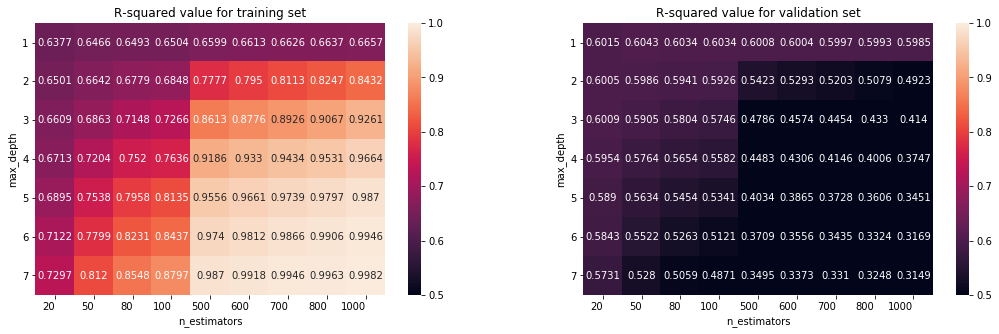

In [386]:
plt.figure(figsize=(18,5))
plt.subplot(121)
ax=sns.heatmap(train_r2_score_list,annot=True,square=True,fmt='.4g',vmin=0.5,vmax=1)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.title('R-squared value for training set')
ax.set_xticklabels(alpha,rotation=0, horizontalalignment='right');
ax.set_yticklabels(max_depth,rotation=0, horizontalalignment='right');
plt.subplot(122)
ax=sns.heatmap(val_r2_score_list,annot=True,square=True,fmt='.4g',vmin=0.5,vmax=1)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.title('R-squared value for validation set')
ax.set_xticklabels(alpha,rotation=0, horizontalalignment='right');
ax.set_yticklabels(max_depth,rotation=0, horizontalalignment='right');

In [387]:
alpha[np.argmax(val_r2_score_list[0])]

50

Best value of hyperparameters: n_estimators = 50, max_depth = 1

<h3>3.7.1.2 RandomSearchCV</h3>

In [395]:
clf = xgb.XGBRegressor()
params = {'n_estimators':[20,50,80,100,500,600],
          'max_depth':[1,2,3,4,5,7],
              'colsample_bytree':[0.1,0.3,0.5,1],'subsample':[0.1,0.3,0.5,1]}
random_clf = RandomizedSearchCV(clf,param_distributions=params,verbose=5,n_jobs=1,
                                return_train_score=True,n_iter=40,scoring='r2',cv=5)
random_clf.fit(X_train[top_features],y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] subsample=0.5, n_estimators=50, max_depth=5, colsample_bytree=0.1 
[CV]  subsample=0.5, n_estimators=50, max_depth=5, colsample_bytree=0.1, score=0.6671697666797527, total=   0.0s
[CV] subsample=0.5, n_estimators=50, max_depth=5, colsample_bytree=0.1 
[CV]  subsample=0.5, n_estimators=50, max_depth=5, colsample_bytree=0.1, score=0.5764573266646948, total=   0.0s
[CV] subsample=0.5, n_estimators=50, max_depth=5, colsample_bytree=0.1 
[CV]  subsample=0.5, n_estimators=50, max_depth=5, colsample_bytree=0.1, score=0.6365597201142732, total=   0.0s
[CV] subsample=0.5, n_estimators=50, max_depth=5, colsample_bytree=0.1 
[CV]  subsample=0.5, n_estimators=50, max_depth=5, colsample_bytree=0.1, score=0.5866669090968255, total=   0.0s
[CV] subsample=0.5, n_estimators=50, max_depth=5, colsample_bytree=0.1 
[CV]  subsample=0.5, n_estimators=50, max_depth=5, colsample_bytree=0.1, score=0.6678964081708235, total=   0.0s
[CV] subsampl

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


[CV]  subsample=1, n_estimators=100, max_depth=7, colsample_bytree=0.1, score=0.6506650255283519, total=   0.0s
[CV] subsample=1, n_estimators=100, max_depth=7, colsample_bytree=0.1 
[CV]  subsample=1, n_estimators=100, max_depth=7, colsample_bytree=0.1, score=0.5748613921236114, total=   0.0s
[CV] subsample=1, n_estimators=100, max_depth=7, colsample_bytree=0.1 
[CV]  subsample=1, n_estimators=100, max_depth=7, colsample_bytree=0.1, score=0.6290704784287051, total=   0.0s
[CV] subsample=1, n_estimators=100, max_depth=7, colsample_bytree=0.1 
[CV]  subsample=1, n_estimators=100, max_depth=7, colsample_bytree=0.1, score=0.577320213028844, total=   0.0s
[CV] subsample=1, n_estimators=100, max_depth=7, colsample_bytree=0.1 
[CV]  subsample=1, n_estimators=100, max_depth=7, colsample_bytree=0.1, score=0.6533166980303813, total=   0.0s
[CV] subsample=0.5, n_estimators=50, max_depth=1, colsample_bytree=0.5 
[CV]  subsample=0.5, n_estimators=50, max_depth=1, colsample_bytree=0.5, score=0.6787

[CV]  subsample=1, n_estimators=600, max_depth=3, colsample_bytree=1, score=0.5653318489192567, total=   0.3s
[CV] subsample=1, n_estimators=600, max_depth=3, colsample_bytree=1 ..
[CV]  subsample=1, n_estimators=600, max_depth=3, colsample_bytree=1, score=0.46191446395224767, total=   0.3s
[CV] subsample=1, n_estimators=600, max_depth=3, colsample_bytree=1 ..
[CV]  subsample=1, n_estimators=600, max_depth=3, colsample_bytree=1, score=0.565654557743172, total=   0.3s
[CV] subsample=1, n_estimators=600, max_depth=3, colsample_bytree=1 ..
[CV]  subsample=1, n_estimators=600, max_depth=3, colsample_bytree=1, score=0.5048440614416996, total=   0.3s
[CV] subsample=1, n_estimators=600, max_depth=3, colsample_bytree=1 ..
[CV]  subsample=1, n_estimators=600, max_depth=3, colsample_bytree=1, score=0.5373056785580403, total=   0.4s
[CV] subsample=1, n_estimators=20, max_depth=3, colsample_bytree=0.1 .
[CV]  subsample=1, n_estimators=20, max_depth=3, colsample_bytree=0.1, score=0.6631190209008425

[CV]  subsample=1, n_estimators=500, max_depth=4, colsample_bytree=0.1, score=0.6404264653421261, total=   0.2s
[CV] subsample=1, n_estimators=500, max_depth=4, colsample_bytree=0.1 
[CV]  subsample=1, n_estimators=500, max_depth=4, colsample_bytree=0.1, score=0.564793270038348, total=   0.2s
[CV] subsample=1, n_estimators=500, max_depth=4, colsample_bytree=0.1 
[CV]  subsample=1, n_estimators=500, max_depth=4, colsample_bytree=0.1, score=0.6198120677696344, total=   0.2s
[CV] subsample=1, n_estimators=500, max_depth=4, colsample_bytree=0.1 
[CV]  subsample=1, n_estimators=500, max_depth=4, colsample_bytree=0.1, score=0.5705265979671948, total=   0.2s
[CV] subsample=1, n_estimators=500, max_depth=4, colsample_bytree=0.1 
[CV]  subsample=1, n_estimators=500, max_depth=4, colsample_bytree=0.1, score=0.636388982436966, total=   0.2s
[CV] subsample=0.1, n_estimators=600, max_depth=4, colsample_bytree=0.1 
[CV]  subsample=0.1, n_estimators=600, max_depth=4, colsample_bytree=0.1, score=0.624

[CV]  subsample=0.5, n_estimators=100, max_depth=1, colsample_bytree=1, score=0.6743605387472426, total=   0.0s
[CV] subsample=0.5, n_estimators=500, max_depth=4, colsample_bytree=0.1 
[CV]  subsample=0.5, n_estimators=500, max_depth=4, colsample_bytree=0.1, score=0.627424004050764, total=   0.2s
[CV] subsample=0.5, n_estimators=500, max_depth=4, colsample_bytree=0.1 
[CV]  subsample=0.5, n_estimators=500, max_depth=4, colsample_bytree=0.1, score=0.5602355948345341, total=   0.2s
[CV] subsample=0.5, n_estimators=500, max_depth=4, colsample_bytree=0.1 
[CV]  subsample=0.5, n_estimators=500, max_depth=4, colsample_bytree=0.1, score=0.6234632993297924, total=   0.2s
[CV] subsample=0.5, n_estimators=500, max_depth=4, colsample_bytree=0.1 
[CV]  subsample=0.5, n_estimators=500, max_depth=4, colsample_bytree=0.1, score=0.5607451716113321, total=   0.2s
[CV] subsample=0.5, n_estimators=500, max_depth=4, colsample_bytree=0.1 
[CV]  subsample=0.5, n_estimators=500, max_depth=4, colsample_bytree

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   24.8s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None, gamma=None,
       gpu_id=None, importance_type='gain', interaction_constraints=None,
       learning_rate=None, max_delta_step=None, max_depth=None,
       min_child_we...pos_weight=None, subsample=None,
       tree_method=None, validate_parameters=False, verbosity=None),
          fit_params=None, iid=True, n_iter=40, n_jobs=1,
          param_distributions={'subsample': [0.1, 0.3, 0.5, 1], 'n_estimators': [20, 50, 80, 100, 500, 600], 'max_depth': [1, 2, 3, 4, 5, 7], 'colsample_bytree': [0.1, 0.3, 0.5, 1]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='r2', verbose=5)

In [396]:
best_params = random_clf.best_params_
best_params

{'colsample_bytree': 0.3, 'max_depth': 2, 'n_estimators': 80, 'subsample': 1}

In [397]:
clf = xgb.XGBRegressor(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth'],
                        colsample_bytree=best_params['colsample_bytree'],subsample=best_params['subsample'],
                        n_threads=-1,random_state=25)
clf.fit(X_train[top_features],y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.300000012, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=80, n_jobs=0, n_threads=-1, num_parallel_tree=1,
       objective='reg:squarederror', random_state=25, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None)

In [398]:
#R2 value
print('Train R-squared value:',clf.score(X_train[top_features],y_train))
print('Val R-squared value:',clf.score(X_val[top_features],y_val))

Train R-squared value: 0.6585969528768676
Val R-squared value: 0.6002739262111645


<h3>3.7.2. Best model for XGBoost

In [411]:
#Best params
best_params={'n_estimators':50,'max_depth':1,'colsample_bytree':1,'subsample':1}

In [412]:
clf = xgb.XGBRegressor(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth'],
                        colsample_bytree=best_params['colsample_bytree'],subsample=best_params['subsample'],
                        n_threads=-1,random_state=25)
clf.fit(X_train[top_features],y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.300000012, max_delta_step=0, max_depth=1,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=50, n_jobs=0, n_threads=-1, num_parallel_tree=1,
       objective='reg:squarederror', random_state=25, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None)

In [413]:
#R2 value
print('Train R-squared value:',clf.score(X_train[top_features],y_train))
print('Val R-squared value:',clf.score(X_val[top_features],y_val))

Train R-squared value: 0.646629961496022
Val R-squared value: 0.6043447412605936


In [7]:
algo_val['XGB'] =  0.604

<h3>3.8. Multi-layer perceptron</h3>

In [34]:
top_features = np.load('top_features.npy')

In [35]:
#Considering top 10 features
top_features = top_features[:8]

In [36]:
def mlp_model(input_shape):    
    
    """
    This function returns the multi-layer perceptron model
    """
    #Input layer
    input_layer = Input(shape=input_shape,name='Input_layer')
    
    #Adding new layers
    dense1 = Dense(512, activation='relu',name='Dense_1')(input_layer)
    dense2 = Dense(128, activation='relu',name='Dense_2')(dense1)
    dense3 = Dense(64, activation='relu',name='Dense_3')(dense2)  
    dense4 = Dense(16, activation='relu',name='Dense_4')(dense3)
    dense5 = Dense(8, activation='relu',name='Dense_5')(dense4)
    
    #Output layer
    output = Dense(1, activation='linear',name='Output_layer')(dense5)
    
    #Model
    model = Model(inputs=input_layer, outputs=output)
    return model

In [37]:
model = mlp_model(input_shape = X_train[top_features].shape[1])

In [38]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 8)]               0         
_________________________________________________________________
Dense_1 (Dense)              (None, 512)               4608      
_________________________________________________________________
Dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
Dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
Dense_4 (Dense)              (None, 16)                1040      
_________________________________________________________________
Dense_5 (Dense)              (None, 8)                 136       
_________________________________________________________________
Output_layer (Dense)         (None, 1)                 9     

In [39]:
#Create folder to save models
if not os.path.isdir('model_save'):
    os.makedirs('model_save')

In [40]:
#Custom R2-squared function for keras
def r_squared(y_true,y_pred):
    """
    This function returns the R-squared value for keras model
    """
    return tf.py_function(r2_score,(y_true,y_pred),tf.double)

In [60]:
# Clear any logs from previous runs
!rm -rf ./logs/

In [61]:
os.environ['PYTHONHASHSEED'] = '0'
tf.keras.backend.clear_session()
## Set the random seed values to regenerate the model.
np.random.seed(0)
random.seed(0)

batch_size = 16
epochs = 100

#MLP model
model = mlp_model(input_shape = X_train[top_features].shape[1])

#Model compile
model.compile(optimizer=Adam(learning_rate=0.1),loss='mean_squared_error', metrics=[r_squared])

#Save intermediate model callback
filepath="model_save/weights-{epoch:02d}-{val_r_squared:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_r_squared', verbose=1, save_best_only=True, mode='max')

#Reduce learning rate by 10% if validation accuracy reduces from previous epoch
reduce_lr = ReduceLROnPlateau(monitor='val_r_squared', factor=0.9, verbose=1, patience=3,min_lr=0.0001)

#Stop training if val_loss does not increase in last 20 epochs
terminate_loss = EarlyStopping(monitor='val_loss',patience=20,verbose=1,mode='min')

#Tensorboard
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)

#Callback list
callback_list = [checkpoint,reduce_lr,terminate_loss,tensorboard_callback]

#Train model
model.fit(X_train[top_features], y_train, epochs=epochs, batch_size=batch_size, 
          validation_data=(X_val[top_features], y_val),callbacks=callback_list)

Train on 3355 samples, validate on 839 samples
Epoch 1/100
3264/3355 [============================>.] - ETA: 0s - loss: 854.8647 - r_squared: -6.4167
Epoch 00001: val_r_squared improved from -inf to 0.15236, saving model to model_save/weights-01-0.1524.hdf5
3355/3355 [==============================] - 1s 311us/sample - loss: 834.2841 - r_squared: -6.2275 - val_loss: 121.7507 - val_r_squared: 0.1524
Epoch 2/100
3344/3355 [============================>.] - ETA: 0s - loss: 80.5723 - r_squared: 0.3681
Epoch 00002: val_r_squared improved from 0.15236 to 0.51482, saving model to model_save/weights-02-0.5148.hdf5
3355/3355 [==============================] - 1s 177us/sample - loss: 80.5819 - r_squared: 0.3687 - val_loss: 73.6649 - val_r_squared: 0.5148
Epoch 3/100
3328/3355 [============================>.] - ETA: 0s - loss: 86.7882 - r_squared: 0.2893
Epoch 00003: val_r_squared did not improve from 0.51482
3355/3355 [==============================] - 1s 170us/sample - loss: 86.7815 - r_squared

Epoch 50/100
3008/3355 [=========================>....] - ETA: 0s - loss: 54.8986 - r_squared: 0.5902
Epoch 00050: val_r_squared did not improve from 0.59472
3355/3355 [==============================] - 1s 168us/sample - loss: 54.6577 - r_squared: 0.5874 - val_loss: 76.6860 - val_r_squared: 0.5001
Epoch 51/100
3008/3355 [=========================>....] - ETA: 0s - loss: 53.7483 - r_squared: 0.5902
Epoch 00051: val_r_squared did not improve from 0.59472
3355/3355 [==============================] - 1s 167us/sample - loss: 53.9519 - r_squared: 0.5861 - val_loss: 62.8155 - val_r_squared: 0.5913
Epoch 00051: early stopping


In [62]:
model.load_weights('model_save/weights-27-0.5947.hdf5')

In [63]:
# Save the trained weights in to .h5 format
model.save_weights("mlp_best_model.h5")

In [64]:
#R2 value
_, train_mlp_r2 = model.evaluate(X_train[top_features],y_train)
_, val_mlp_r2 = model.evaluate(X_val[top_features],y_val)
print('Train R-squared value:',train_mlp_r2)
print('Val R-squared value:',val_mlp_r2)

839/839 [==============================] - 0s 53us/sample - loss: 62.0534 - r_squared: 0.5969
Train R-squared value: 0.62940603
Val R-squared value: 0.5969377


In [8]:
algo_val['MLP'] =  0.597

<h3>3.9. Stacking with k-fold cross validation</h3>

In [36]:
top_features = np.load('top_features.npy')

<h3>3.9.1. ML base models

In [62]:
def meta_model_features(train,train_y,val,model,n_folds):
    
    """
    This function returns the predictions of out-of-fold train set and validation set.
    These are the features of metaregressor model
    
    Arguments:
    train = X_train
    train_y = y_train
    val = X_val
    model = Model to fit
    n_folds = No of folds in cross-validation
    
    """
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=42)
    
    #Change column names
    train.columns = ['f'+str(i) for i in range(len(train.columns))]
    val.columns = train.columns
    
    #Validation set prediction
    val_pred = np.zeros(val.shape[0])
    
    #Out-of-fold prediction for train set
    oof_train = {}
    
    for train_index,val_index in tqdm(kf.split(train)):
        model.fit(train.iloc[train_index],train_y.iloc[train_index])
        for i in val_index:
            oof_train[i] = model.predict(np.array(train.iloc[i]).reshape(1,-1))
        val_pred+=model.predict(val)
    
    oof_train_pred = np.array(list(oof_train.values()))
    val_pred /=n_folds 
    
    return oof_train_pred,val_pred

In [38]:
#Kernel SVR base model
features = top_features[:10]
ksvm_model = SVR(C=5,epsilon=5,gamma=0.1)
ksvm_train, ksvm_val = meta_model_features(X_train[features],y_train,X_val[features],ksvm_model,10)

In [39]:
#k-NN base model
features = top_features[:5]
knn_model = KNeighborsRegressor(n_neighbors=85,n_jobs=-1)
knn_train, knn_val = meta_model_features(X_train[features],y_train,X_val[features],knn_model,10)

In [40]:
#Random Forest base model
features = top_features[:20]
rf_model = RandomForestRegressor(n_estimators=500,max_depth=3,min_samples_split=600,min_samples_leaf=20,n_jobs=-1,
                                 random_state=25)
rf_train, rf_val = meta_model_features(X_train[features],y_train,X_val[features],rf_model,10)

In [41]:
#Random Forest base model
features = top_features[:20]
rf_model2 = RandomForestRegressor(n_estimators=500,max_depth=5,min_samples_split=550,min_samples_leaf=20,n_jobs=-1,
                                 random_state=25)
rf_train2, rf_val2 = meta_model_features(X_train[features],y_train,X_val[features],rf_model2,10)

In [42]:
#XGBoost base model
features = top_features[:8]
xgb_model = xgb.XGBRegressor(n_estimators=50,max_depth=1,colsample_bytree=1,subsample=1,n_thread=-1)
xgb_train, xgb_val = meta_model_features(X_train[features],y_train,X_val[features],xgb_model,10)

In [43]:
#XGBoost base model
features = top_features[:8]
xgb_model2 = xgb.XGBRegressor(n_estimators=20,max_depth=3,colsample_bytree=1,subsample=1,n_thread=-1)
xgb_train2, xgb_val2 = meta_model_features(X_train[features],y_train,X_val[features],xgb_model2,10)

<h3>3.9.2. MLP base models

In [63]:
def meta_model_features_mlp(train,train_y,val,model,batch_size,epochs,n_folds):
    
    """
    This function returns the predictions of out-of-fold train set and validation set for mlp model
    
    Arguments:
    train = X_train
    train_y = y_train
    val = X_val
    model = MLP model
    n_folds = No of folds in cross-validation
    
    """
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=42)
    
    #Model compile
    model.compile(optimizer=Adam(learning_rate=0.1),loss='mean_squared_error', metrics=[r_squared])

    #Reduce learning rate by 10% if validation accuracy reduces from previous epoch
    reduce_lr = ReduceLROnPlateau(monitor='val_r_squared', factor=0.9, verbose=1, patience=3,min_lr=0.0001)

    #Stop training if val_loss does not increase in last 20 epochs
    terminate_loss = EarlyStopping(monitor='val_loss',patience=20,verbose=1,mode='min',restore_best_weights=True)

    #Callback list
    callback_list = [reduce_lr,terminate_loss]

    #Validation set prediction
    val_pred = np.zeros((val.shape[0],1))
    
    #Out-of-fold prediction for train set
    oof_train = {}
    
    iteration = 0
    for train_index,val_index in tqdm(kf.split(train)):
        iteration+=1
        tf.keras.backend.clear_session()
        print('Fold: ',iteration)
        model.fit(train.iloc[train_index], train_y.iloc[train_index], epochs=epochs, batch_size=batch_size, 
                          validation_data=(train.iloc[val_index], train_y.iloc[val_index]),callbacks=callback_list)
        print(120*'*','\n')
        
        for i in val_index:
            oof_train[i] = model.predict(np.array(train.iloc[i]).reshape(1,-1))[0][0]
        val_pred+=model.predict(val)
    
    oof_train_pred = np.array(list(oof_train.values()))
    val_pred /=n_folds 
    
    return oof_train_pred,val_pred

In [45]:
#MLP base model
features = top_features[:8]
mlp_base_model = mlp_model(input_shape = X_train[features].shape[1])
mlp_base_train, mlp_base_val = meta_model_features_mlp(X_train[features],y_train,X_val[features],mlp_base_model,
                                                       batch_size=16,epochs=100,n_folds=10)

Fold:  1
Train on 3019 samples, validate on 336 samples
Epoch 1/100
3019/3019 [==============================] - 3s 1ms/sample - loss: 16142.6255 - r_squared: -179.4524 - val_loss: 101.0717 - val_r_squared: 0.3109
Epoch 2/100
3019/3019 [==============================] - 0s 147us/sample - loss: 88.0943 - r_squared: 0.3026 - val_loss: 84.1351 - val_r_squared: 0.3596
Epoch 3/100
3019/3019 [==============================] - 0s 147us/sample - loss: 92.0427 - r_squared: 0.2436 - val_loss: 71.7938 - val_r_squared: 0.4885
Epoch 4/100
3019/3019 [==============================] - 0s 147us/sample - loss: 88.9015 - r_squared: 0.2869 - val_loss: 129.8392 - val_r_squared: 0.0893
Epoch 5/100
3019/3019 [==============================] - 0s 148us/sample - loss: 84.4379 - r_squared: 0.3491 - val_loss: 66.9061 - val_r_squared: 0.5403
Epoch 6/100
3019/3019 [==============================] - 0s 148us/sample - loss: 82.0664 - r_squared: 0.3323 - val_loss: 75.2251 - val_r_squared: 0.4334
Epoch 7/100
2704/301

Epoch 42/100
3019/3019 [==============================] - 0s 148us/sample - loss: 53.0974 - r_squared: 0.6088 - val_loss: 70.8768 - val_r_squared: 0.4752
Epoch 43/100
3019/3019 [==============================] - 0s 147us/sample - loss: 57.0727 - r_squared: 0.5570 - val_loss: 67.3357 - val_r_squared: 0.5608
Epoch 44/100
2704/3019 [=========================>....] - ETA: 0s - loss: 56.4675 - r_squared: 0.5720
Epoch 00044: ReduceLROnPlateau reducing learning rate to 0.02541865445673466.
3019/3019 [==============================] - 0s 146us/sample - loss: 55.0484 - r_squared: 0.5796 - val_loss: 73.7619 - val_r_squared: 0.5146
Epoch 45/100
3019/3019 [==============================] - 0s 146us/sample - loss: 53.4742 - r_squared: 0.5948 - val_loss: 59.7200 - val_r_squared: 0.6009
Epoch 46/100
3019/3019 [==============================] - 0s 147us/sample - loss: 54.7453 - r_squared: 0.5820 - val_loss: 60.3272 - val_r_squared: 0.5913
Epoch 47/100
2704/3019 [=========================>....] - ETA: 

Epoch 00080: early stopping
************************************************************************************************************************ 

Fold:  2
Train on 3019 samples, validate on 336 samples
Epoch 1/100
3019/3019 [==============================] - 0s 148us/sample - loss: 51.8790 - r_squared: 0.6111 - val_loss: 48.4154 - val_r_squared: 0.6289
Epoch 2/100
3019/3019 [==============================] - 0s 148us/sample - loss: 51.9536 - r_squared: 0.6113 - val_loss: 48.2477 - val_r_squared: 0.6280
Epoch 3/100
3019/3019 [==============================] - 0s 150us/sample - loss: 53.0297 - r_squared: 0.6082 - val_loss: 48.8266 - val_r_squared: 0.6266
Epoch 4/100
3019/3019 [==============================] - 0s 147us/sample - loss: 52.1197 - r_squared: 0.6011 - val_loss: 50.4740 - val_r_squared: 0.6056
Epoch 5/100
3019/3019 [==============================] - 0s 148us/sample - loss: 52.5003 - r_squared: 0.6085 - val_loss: 48.5904 - val_r_squared: 0.6291
Epoch 6/100
3019/3019 [=====

Epoch 3/100
3019/3019 [==============================] - 0s 148us/sample - loss: 51.0101 - r_squared: 0.6292 - val_loss: 44.9481 - val_r_squared: 0.6307
Epoch 4/100
3019/3019 [==============================] - 0s 148us/sample - loss: 50.9791 - r_squared: 0.6120 - val_loss: 44.5635 - val_r_squared: 0.6365
Epoch 5/100
3019/3019 [==============================] - 0s 146us/sample - loss: 50.8441 - r_squared: 0.6284 - val_loss: 44.5260 - val_r_squared: 0.6389
Epoch 6/100
2704/3019 [=========================>....] - ETA: 0s - loss: 50.9587 - r_squared: 0.6087
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0006362684885971248.
3019/3019 [==============================] - 0s 147us/sample - loss: 50.9225 - r_squared: 0.6175 - val_loss: 44.6376 - val_r_squared: 0.6364
Epoch 7/100
3019/3019 [==============================] - 0s 147us/sample - loss: 50.8419 - r_squared: 0.6167 - val_loss: 44.5144 - val_r_squared: 0.6402
Epoch 8/100
3019/3019 [==============================] - 0s 149us/

Epoch 21/100
3019/3019 [==============================] - 0s 145us/sample - loss: 50.4463 - r_squared: 0.6275 - val_loss: 47.2686 - val_r_squared: 0.6304
Epoch 22/100
3019/3019 [==============================] - 0s 147us/sample - loss: 50.5058 - r_squared: 0.6347 - val_loss: 47.2830 - val_r_squared: 0.6300
Epoch 23/100
2720/3019 [==========================>...] - ETA: 0s - loss: 51.0818 - r_squared: 0.6326
Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.00019966779073001816.
3019/3019 [==============================] - 0s 146us/sample - loss: 50.4394 - r_squared: 0.6338 - val_loss: 47.2865 - val_r_squared: 0.6299
Epoch 24/100
3019/3019 [==============================] - 0s 148us/sample - loss: 50.3751 - r_squared: 0.6248 - val_loss: 47.3748 - val_r_squared: 0.6287
Epoch 25/100
3019/3019 [==============================] - 0s 148us/sample - loss: 50.4789 - r_squared: 0.6254 - val_loss: 47.2329 - val_r_squared: 0.6313
Epoch 26/100
2704/3019 [=========================>....] - ET

Epoch 13/100
3020/3020 [==============================] - 0s 146us/sample - loss: 50.0410 - r_squared: 0.6269 - val_loss: 50.6629 - val_r_squared: 0.6274
Epoch 14/100
3020/3020 [==============================] - 0s 145us/sample - loss: 50.0240 - r_squared: 0.6287 - val_loss: 50.5398 - val_r_squared: 0.6295
Epoch 15/100
3020/3020 [==============================] - 0s 146us/sample - loss: 50.0199 - r_squared: 0.6318 - val_loss: 50.4963 - val_r_squared: 0.6307
Epoch 16/100
3020/3020 [==============================] - 0s 146us/sample - loss: 50.0096 - r_squared: 0.6229 - val_loss: 50.4985 - val_r_squared: 0.6306
Epoch 17/100
3020/3020 [==============================] - 0s 147us/sample - loss: 50.0151 - r_squared: 0.6191 - val_loss: 50.5446 - val_r_squared: 0.6296
Epoch 18/100
3020/3020 [==============================] - 0s 148us/sample - loss: 50.0432 - r_squared: 0.6318 - val_loss: 50.5280 - val_r_squared: 0.6299
Epoch 19/100
3020/3020 [==============================] - 0s 149us/sample - 

Epoch 16/100
3020/3020 [==============================] - 0s 147us/sample - loss: 49.5694 - r_squared: 0.6344 - val_loss: 54.6748 - val_r_squared: 0.6397
Epoch 17/100
3020/3020 [==============================] - 0s 146us/sample - loss: 49.5714 - r_squared: 0.6227 - val_loss: 54.4821 - val_r_squared: 0.6402
Epoch 18/100
3020/3020 [==============================] - 0s 146us/sample - loss: 49.5785 - r_squared: 0.6207 - val_loss: 54.5190 - val_r_squared: 0.6401
Epoch 19/100
3020/3020 [==============================] - 0s 148us/sample - loss: 49.5733 - r_squared: 0.6201 - val_loss: 54.6499 - val_r_squared: 0.6398
Epoch 20/100
3020/3020 [==============================] - 0s 148us/sample - loss: 49.5737 - r_squared: 0.6198 - val_loss: 54.5080 - val_r_squared: 0.6401
Epoch 21/100
3020/3020 [==============================] - 0s 149us/sample - loss: 49.5852 - r_squared: 0.6115 - val_loss: 54.5335 - val_r_squared: 0.6400
Epoch 00021: early stopping
************************************************

<h3>3.9.3. Combine predictions from ML and MLP base models

In [46]:
#Data for metaregressor model
X_train_meta = pd.DataFrame(index=X_train.index)
X_train_meta['ksvm'] = ksvm_train.reshape(-1)
X_train_meta['knn'] = knn_train.reshape(-1)
X_train_meta['rf'] = rf_train.reshape(-1)
X_train_meta['rf2'] = rf_train2.reshape(-1)
X_train_meta['xgb'] = xgb_train.reshape(-1)
X_train_meta['xgb2'] = xgb_train2.reshape(-1)
X_train_meta['mlp'] = mlp_base_train.reshape(-1)

In [47]:
X_train_meta.head()

,ksvm,knn,rf,rf2,xgb,xgb2,mlp
1468,112.163083,111.600706,112.596316,112.207761,112.354675,112.006897,112.715401
3654,93.431972,93.714118,92.115970,92.075692,92.915833,92.067558,92.533073
3130,93.483378,93.478118,94.070993,95.007922,94.151459,94.810463,93.555229
257,112.604677,111.625176,112.582949,112.277456,112.118492,112.853111,113.154327
781,94.019908,93.059176,94.393615,93.848291,94.517471,94.535118,94.356728


In [48]:
#Data for metaregressor model
X_val_meta = pd.DataFrame(index=X_val.index)
X_val_meta['ksvm'] = ksvm_val.reshape(-1)
X_val_meta['knn'] = knn_val.reshape(-1)
X_val_meta['rf'] = rf_val.reshape(-1)
X_val_meta['rf2'] = rf_val2.reshape(-1)
X_val_meta['xgb'] = xgb_val.reshape(-1)
X_val_meta['xgb2'] = xgb_val2.reshape(-1)
X_val_meta['mlp'] = mlp_base_val.reshape(-1)

In [49]:
X_val_meta.head()

,ksvm,knn,rf,rf2,xgb,xgb2,mlp
3186,79.165574,77.831788,77.924556,77.924556,78.501804,77.804652,77.626523
1507,79.295461,77.831788,77.924556,77.924556,78.923209,78.594249,77.626523
694,112.474294,111.934247,112.558245,112.262809,112.436611,112.933675,113.036668
2898,103.205462,103.762341,103.507235,103.507235,104.312027,105.772540,102.904949
1356,93.906322,93.773671,94.326349,93.909956,94.434011,94.280260,94.381016


In [50]:
print('Considering Kernel SVM:')
print('Train R-squared value:',r2_score(y_train,X_train_meta['ksvm']))
print('Val R-squared value:',r2_score(y_val,X_val_meta['ksvm']))
print('\n')
print('Considering k-NN:')
print('Train R-squared value:',r2_score(y_train,X_train_meta['knn']))
print('Val R-squared value:',r2_score(y_val,X_val_meta['knn']))
print('\n')
print('Considering Random Forest 1:')
print('Train R-squared value:',r2_score(y_train,X_train_meta['rf']))
print('Val R-squared value:',r2_score(y_val,X_val_meta['rf']))
print('\n')
print('Considering Random Forest 2:')
print('Train R-squared value:',r2_score(y_train,X_train_meta['rf2']))
print('Val R-squared value:',r2_score(y_val,X_val_meta['rf2']))
print('\n')
print('Considering XGBoost 1:')
print('Train R-squared value:',r2_score(y_train,X_train_meta['xgb']))
print('Val R-squared value:',r2_score(y_val,X_val_meta['xgb']))
print('\n')
print('Considering XGBoost 2:')
print('Train R-squared value:',r2_score(y_train,X_train_meta['xgb2']))
print('Val R-squared value:',r2_score(y_val,X_val_meta['xgb2']))
print('\n')
print('Considering MLP:')
print('Train R-squared value:',r2_score(y_train,X_train_meta['mlp']))
print('Val R-squared value:',r2_score(y_val,X_val_meta['mlp']))
print('\n')
print('Considering average of all models:')
print('Train R-squared value:',r2_score(y_train,X_train_meta.mean(axis=1)))
print('Val R-squared value:',r2_score(y_val,X_val_meta.mean(axis=1)))

Considering Kernel SVM:
Train R-squared value: 0.6371581189873471
Val R-squared value: 0.5992880632429223


Considering k-NN:
Train R-squared value: 0.6265085766831371
Val R-squared value: 0.5950172866350205


Considering Random Forest 1:
Train R-squared value: 0.6328667142274769
Val R-squared value: 0.5986821201354031


Considering Random Forest 2:
Train R-squared value: 0.6385872435945568
Val R-squared value: 0.5997899542151177


Considering XGBoost 1:
Train R-squared value: 0.6384809101084518
Val R-squared value: 0.604068846997043


Considering XGBoost 2:
Train R-squared value: 0.6359257625608732
Val R-squared value: 0.6001857292114914


Considering MLP:
Train R-squared value: 0.6447160590213787
Val R-squared value: 0.6014268177134573


Considering average of all models:
Train R-squared value: 0.6400223919720539
Val R-squared value: 0.6030920421785891


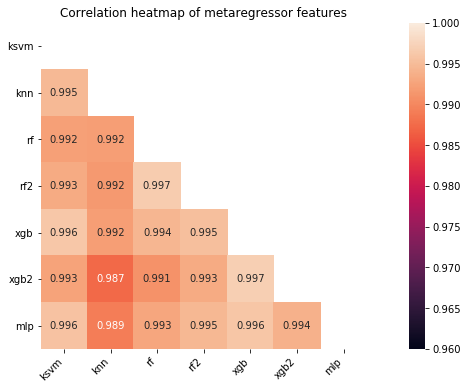

In [51]:
#Corelation between features of metaregressor model
corr = X_train_meta.corr()
plt.figure(figsize=(15,6))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr,dtype=np.bool))

ax=sns.heatmap(corr,annot=True,square=True,fmt='.3g',mask=mask,vmin=0.96,vmax=1)
plt.title('Correlation heatmap of metaregressor features')
ax.set_xticklabels(X_train_meta.columns,rotation=45, horizontalalignment='right');
ax.set_yticklabels(X_train_meta.columns,rotation=0, horizontalalignment='right');

Predictions from base models are highly correlated with each other. Thus the predictions from all base models do not vary significantly from each other

<h3>3.9.4. XGBoost for Metaregressor model</h3>

<h3>3.9.1. Hyperparameter tuning

<h3>3.9.1.1. n_estimators Vs max_depth</h3>

In [52]:
alpha = [20,50,80,90,100,120,130,150,200]
max_depth = [1,2,3,4,5,6,7]
train_r2_score_list = []
val_r2_score_list = []

for i in tqdm(max_depth):
    train_a=[]
    val_a=[]
    for j in alpha:
        clf = xgb.XGBRegressor(n_estimators=j,max_depth=i,n_thread=-1)
        clf.fit(X_train_meta,y_train)
        train_a.append(clf.score(X_train_meta,y_train))
        val_a.append(clf.score(X_val_meta,y_val))
    train_r2_score_list.append(train_a)
    val_r2_score_list.append(val_a)

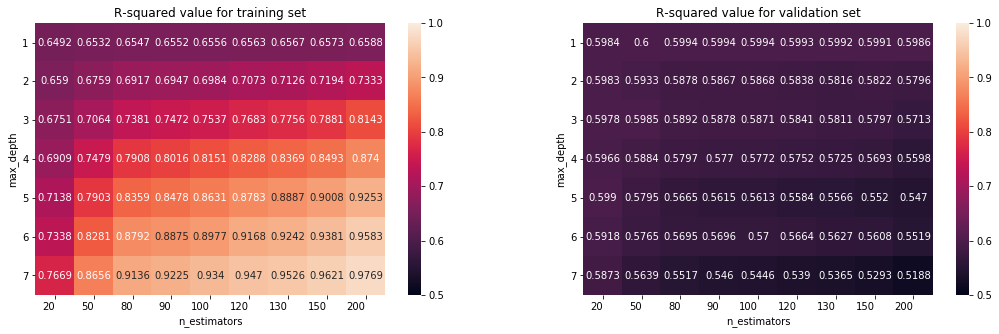

In [53]:
plt.figure(figsize=(18,5))
plt.subplot(121)
ax=sns.heatmap(train_r2_score_list,annot=True,square=True,fmt='.4g',vmin=0.5,vmax=1)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.title('R-squared value for training set')
ax.set_xticklabels(alpha,rotation=0, horizontalalignment='right');
ax.set_yticklabels(max_depth,rotation=0, horizontalalignment='right');
plt.subplot(122)
ax=sns.heatmap(val_r2_score_list,annot=True,square=True,fmt='.4g',vmin=0.5,vmax=1)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.title('R-squared value for validation set')
ax.set_xticklabels(alpha,rotation=0, horizontalalignment='right');
ax.set_yticklabels(max_depth,rotation=0, horizontalalignment='right');

In [54]:
alpha[np.argmax(val_r2_score_list[0])]

50

Best value of hyperparameters: n_estimators = 50, max_depth = 1

<h3>3.9.1.2 RandomSearchCV</h3>

In [55]:
clf = xgb.XGBRegressor()
params = {'n_estimators':[20,50,80,90,100,120,130,150,200],
          'max_depth':[1,2,3,4,5,7],
              'colsample_bytree':[0.1,0.3,0.5,1],'subsample':[0.1,0.3,0.5,1]}
random_clf = RandomizedSearchCV(clf,param_distributions=params,verbose=5,n_jobs=1,
                                return_train_score=True,n_iter=40,scoring='r2',cv=5)
random_clf.fit(X_train_meta,y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] max_depth=7, colsample_bytree=0.1, n_estimators=150, subsample=0.3 
[CV]  max_depth=7, colsample_bytree=0.1, n_estimators=150, subsample=0.3, score=(train=0.833, test=0.587), total=   0.1s
[CV] max_depth=7, colsample_bytree=0.1, n_estimators=150, subsample=0.3 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  max_depth=7, colsample_bytree=0.1, n_estimators=150, subsample=0.3, score=(train=0.851, test=0.444), total=   0.1s
[CV] max_depth=7, colsample_bytree=0.1, n_estimators=150, subsample=0.3 
[CV]  max_depth=7, colsample_bytree=0.1, n_estimators=150, subsample=0.3, score=(train=0.834, test=0.522), total=   0.1s
[CV] max_depth=7, colsample_bytree=0.1, n_estimators=150, subsample=0.3 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


[CV]  max_depth=7, colsample_bytree=0.1, n_estimators=150, subsample=0.3, score=(train=0.844, test=0.489), total=   0.1s
[CV] max_depth=7, colsample_bytree=0.1, n_estimators=150, subsample=0.3 
[CV]  max_depth=7, colsample_bytree=0.1, n_estimators=150, subsample=0.3, score=(train=0.844, test=0.450), total=   0.1s
[CV] max_depth=5, colsample_bytree=1, n_estimators=80, subsample=0.5 .


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s


[CV]  max_depth=5, colsample_bytree=1, n_estimators=80, subsample=0.5, score=(train=0.827, test=0.592), total=   0.1s
[CV] max_depth=5, colsample_bytree=1, n_estimators=80, subsample=0.5 .
[CV]  max_depth=5, colsample_bytree=1, n_estimators=80, subsample=0.5, score=(train=0.838, test=0.501), total=   0.1s
[CV] max_depth=5, colsample_bytree=1, n_estimators=80, subsample=0.5 .
[CV]  max_depth=5, colsample_bytree=1, n_estimators=80, subsample=0.5, score=(train=0.829, test=0.566), total=   0.1s
[CV] max_depth=5, colsample_bytree=1, n_estimators=80, subsample=0.5 .
[CV]  max_depth=5, colsample_bytree=1, n_estimators=80, subsample=0.5, score=(train=0.829, test=0.510), total=   0.1s
[CV] max_depth=5, colsample_bytree=1, n_estimators=80, subsample=0.5 .
[CV]  max_depth=5, colsample_bytree=1, n_estimators=80, subsample=0.5, score=(train=0.832, test=0.541), total=   0.1s
[CV] max_depth=2, colsample_bytree=0.5, n_estimators=50, subsample=1 .
[CV]  max_depth=2, colsample_bytree=0.5, n_estimators=5

[CV]  max_depth=7, colsample_bytree=0.1, n_estimators=80, subsample=0.3, score=(train=0.798, test=0.487), total=   0.1s
[CV] max_depth=7, colsample_bytree=0.1, n_estimators=80, subsample=0.3 
[CV]  max_depth=7, colsample_bytree=0.1, n_estimators=80, subsample=0.3, score=(train=0.778, test=0.566), total=   0.1s
[CV] max_depth=7, colsample_bytree=0.1, n_estimators=80, subsample=0.3 
[CV]  max_depth=7, colsample_bytree=0.1, n_estimators=80, subsample=0.3, score=(train=0.787, test=0.539), total=   0.1s
[CV] max_depth=7, colsample_bytree=0.1, n_estimators=80, subsample=0.3 
[CV]  max_depth=7, colsample_bytree=0.1, n_estimators=80, subsample=0.3, score=(train=0.783, test=0.562), total=   0.1s
[CV] max_depth=1, colsample_bytree=0.1, n_estimators=20, subsample=0.5 
[CV]  max_depth=1, colsample_bytree=0.1, n_estimators=20, subsample=0.5, score=(train=0.631, test=0.679), total=   0.0s
[CV] max_depth=1, colsample_bytree=0.1, n_estimators=20, subsample=0.5 
[CV]  max_depth=1, colsample_bytree=0.1,

[CV]  max_depth=2, colsample_bytree=0.3, n_estimators=90, subsample=1, score=(train=0.695, test=0.638), total=   0.0s
[CV] max_depth=2, colsample_bytree=0.3, n_estimators=90, subsample=1 .
[CV]  max_depth=2, colsample_bytree=0.3, n_estimators=90, subsample=1, score=(train=0.706, test=0.601), total=   0.0s
[CV] max_depth=2, colsample_bytree=0.3, n_estimators=90, subsample=1 .
[CV]  max_depth=2, colsample_bytree=0.3, n_estimators=90, subsample=1, score=(train=0.695, test=0.643), total=   0.0s
[CV] max_depth=2, colsample_bytree=0.5, n_estimators=130, subsample=0.5 
[CV]  max_depth=2, colsample_bytree=0.5, n_estimators=130, subsample=0.5, score=(train=0.688, test=0.662), total=   0.1s
[CV] max_depth=2, colsample_bytree=0.5, n_estimators=130, subsample=0.5 
[CV]  max_depth=2, colsample_bytree=0.5, n_estimators=130, subsample=0.5, score=(train=0.714, test=0.574), total=   0.1s
[CV] max_depth=2, colsample_bytree=0.5, n_estimators=130, subsample=0.5 
[CV]  max_depth=2, colsample_bytree=0.5, n_

[CV]  max_depth=2, colsample_bytree=0.5, n_estimators=90, subsample=0.1, score=(train=0.621, test=0.644), total=   0.0s
[CV] max_depth=2, colsample_bytree=0.5, n_estimators=90, subsample=0.1 
[CV]  max_depth=2, colsample_bytree=0.5, n_estimators=90, subsample=0.1, score=(train=0.656, test=0.554), total=   0.0s
[CV] max_depth=2, colsample_bytree=0.5, n_estimators=90, subsample=0.1 
[CV]  max_depth=2, colsample_bytree=0.5, n_estimators=90, subsample=0.1, score=(train=0.639, test=0.590), total=   0.0s
[CV] max_depth=2, colsample_bytree=0.5, n_estimators=90, subsample=0.1 
[CV]  max_depth=2, colsample_bytree=0.5, n_estimators=90, subsample=0.1, score=(train=0.645, test=0.545), total=   0.0s
[CV] max_depth=2, colsample_bytree=0.5, n_estimators=90, subsample=0.1 
[CV]  max_depth=2, colsample_bytree=0.5, n_estimators=90, subsample=0.1, score=(train=0.644, test=0.601), total=   0.0s
[CV] max_depth=3, colsample_bytree=1, n_estimators=150, subsample=0.5 
[CV]  max_depth=3, colsample_bytree=1, n_

[CV]  max_depth=3, colsample_bytree=0.1, n_estimators=200, subsample=0.3, score=(train=0.720, test=0.621), total=   0.1s
[CV] max_depth=3, colsample_bytree=0.1, n_estimators=200, subsample=0.3 
[CV]  max_depth=3, colsample_bytree=0.1, n_estimators=200, subsample=0.3, score=(train=0.737, test=0.526), total=   0.1s
[CV] max_depth=3, colsample_bytree=0.1, n_estimators=200, subsample=0.3 
[CV]  max_depth=3, colsample_bytree=0.1, n_estimators=200, subsample=0.3, score=(train=0.727, test=0.602), total=   0.1s
[CV] max_depth=3, colsample_bytree=0.1, n_estimators=200, subsample=0.3 
[CV]  max_depth=3, colsample_bytree=0.1, n_estimators=200, subsample=0.3, score=(train=0.739, test=0.549), total=   0.1s
[CV] max_depth=3, colsample_bytree=0.1, n_estimators=200, subsample=0.3 
[CV]  max_depth=3, colsample_bytree=0.1, n_estimators=200, subsample=0.3, score=(train=0.730, test=0.586), total=   0.1s
[CV] max_depth=7, colsample_bytree=0.1, n_estimators=120, subsample=1 
[CV]  max_depth=7, colsample_byt

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   16.4s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_...
                                          tree_method=None,
                                          validate_parameters=False,
                                          verbosity=None),
  

In [56]:
best_params = random_clf.best_params_
best_params

{'colsample_bytree': 0.1, 'max_depth': 1, 'n_estimators': 20, 'subsample': 0.5}

In [57]:
clf = xgb.XGBRegressor(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth'],
                        colsample_bytree=best_params['colsample_bytree'],subsample=best_params['subsample'],
                        n_threads=-1,random_state=25)
clf.fit(X_train_meta,y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=1,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=20, n_jobs=0, n_threads=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=25, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.5, tree_method=None,
             validate_parameters=False, verbosity=None)

In [58]:
#R2 value
print('Train R-squared value:',clf.score(X_train_meta,y_train))
print('Val R-squared value:',clf.score(X_val_meta,y_val))

Train R-squared value: 0.6409991815251765
Val R-squared value: 0.5994900562463628


<h3>3.9.2. Best model for XGBoost

In [68]:
#Best params
best_params={'n_estimators':50,'max_depth':1,'colsample_bytree':1,'subsample':1}

In [69]:
clf = xgb.XGBRegressor(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth'],
                        colsample_bytree=best_params['colsample_bytree'],subsample=best_params['subsample'],
                        n_threads=-1,random_state=25)
clf.fit(X_train_meta,y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=1,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=0, n_threads=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=25, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [70]:
#R2 value
print('Train R-squared value:',clf.score(X_train_meta,y_train))
print('Val R-squared value:',clf.score(X_val_meta,y_val))

Train R-squared value: 0.6531748486310505
Val R-squared value: 0.6000070479953579


In [9]:
algo_val['Stack_kfold'] =  0.6

<h3>3.10. Stacking using StackingCVRegressor

In [119]:
top_features = np.load('top_features.npy')

In [120]:
#Kernel SVR base model
ksvm_model = SVR(C=5,epsilon=5,gamma=0.1)

#k-NN base model
knn_model = KNeighborsRegressor(n_neighbors=85,n_jobs=-1)

#Random Forest base model
rf_model = RandomForestRegressor(n_estimators=500,min_samples_split=600,min_samples_leaf=20,n_jobs=-1,
                                 random_state=25)

#XGBoost base model
xgb_model = xgb.XGBRegressor(n_estimators=50,colsample_bytree=1,subsample=1,n_thread=-1)

#Meta model
xgb_meta = xgb.XGBRegressor(n_estimators=50,colsample_bytree=1,subsample=1,n_thread=-1)

In [121]:
stack = StackingCVRegressor(regressors=(ksvm_model,knn_model,rf_model,xgb_model),
                           meta_regressor=xgb_meta,cv=10,use_features_in_secondary=True,store_train_meta_features=True,
                            shuffle=True,random_state=42,verbose=1,n_jobs=1)

In [122]:
params = {'randomforestregressor__max_depth': [2, 3], 'xgbregressor__max_depth': [1, 2, 3],
          'meta_regressor__max_depth':[1, 2, 3]}

grid = GridSearchCV(estimator=stack,param_grid=params,cv=5,return_train_score=True,scoring='r2',verbose=1)

features = top_features[:10]

train = X_train[features].copy()
train.columns = ['f'+str(i) for i in range(len(train.columns))]

grid.fit(train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_j

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Us

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Us

GridSearchCV(cv=5, error_score=nan,
             estimator=StackingCVRegressor(cv=10,
                                           meta_regressor=XGBRegressor(base_score=None,
                                                                       booster=None,
                                                                       colsample_bylevel=None,
                                                                       colsample_bynode=None,
                                                                       colsample_bytree=1,
                                                                       gamma=None,
                                                                       gpu_id=None,
                                                                       importance_type='gain',
                                                                       interaction_constraints=None,
                                                                       learning_rate=None,
       

In [123]:
grid.best_params_

{'meta_regressor__max_depth': 1,
 'randomforestregressor__max_depth': 2,
 'xgbregressor__max_depth': 3}

In [124]:
#Kernel SVR base model
ksvm_model = SVR(C=5,epsilon=5,gamma=0.1)

#k-NN base model
knn_model = KNeighborsRegressor(n_neighbors=85,n_jobs=-1)

#Random Forest base model
rf_model = RandomForestRegressor(n_estimators=500,max_depth=2,min_samples_split=600,min_samples_leaf=20,n_jobs=-1,
                                 random_state=25)

#XGBoost base model
xgb_model = xgb.XGBRegressor(n_estimators=50,max_depth=3,colsample_bytree=1,subsample=1,n_thread=-1)

#Meta model
xgb_meta = xgb.XGBRegressor(n_estimators=50,max_depth=1,colsample_bytree=1,subsample=1,n_thread=-1)

In [125]:
features = top_features[:10]

stack = StackingCVRegressor(regressors=(ksvm_model,knn_model,rf_model,xgb_model),
                           meta_regressor=xgb_meta,cv=10,use_features_in_secondary=True,store_train_meta_features=True,
                            shuffle=True,random_state=42,verbose=1,n_jobs=1)
stack.fit(X_train[features],y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


StackingCVRegressor(cv=10,
                    meta_regressor=XGBRegressor(base_score=None, booster=None,
                                                colsample_bylevel=None,
                                                colsample_bynode=None,
                                                colsample_bytree=1, gamma=None,
                                                gpu_id=None,
                                                importance_type='gain',
                                                interaction_constraints=None,
                                                learning_rate=None,
                                                max_delta_step=None,
                                                max_depth=1,
                                                min_child_weight=None,
                                                missing=nan,
                                                monotone_constraints=None,
                                                n_estim

In [126]:
train = X_train[features].copy()
train.columns = ['f'+str(i) for i in range(len(train.columns))]
val = X_val[features].copy()
val.columns = ['f'+str(i) for i in range(len(train.columns))]

In [127]:
y_train_pred = stack.predict(train)
y_val_pred = stack.predict(val)

In [128]:
#R2 value
print('Train R-squared value:',r2_score(y_train,y_train_pred))
print('Val R-squared value:',r2_score(y_val,y_val_pred))

Train R-squared value: 0.6582732809635805
Val R-squared value: 0.5996324382021752


In [10]:
algo_val['Stack_CVReg'] =  0.6

<h3>3.11. Stacking with Bootstrap Aggregation or Bagging Ensemble

In [41]:
top_features = np.load('top_features.npy')

<h3>3.11.1. ML base models

In [106]:
def meta_model_features_bagging(train,train_y,model_list,n_splits,n_folds):
    
    """
    This function trains the base models and returns the predictions of out-of-fold train set.
    Model is trained on sample of train data
    These are the features of metaregressor model
    
    Arguments:
    train = X_train
    train_y = y_train
    model_list = List of models to fit
    n_splits = No of models to train
    n_folds = No of folds in cross-validation for each model
    
    """
    
    #Change column names
    train.columns = ['f'+str(i) for i in range(len(train.columns))]
    
    #Predictions for train and validation set (Features of metamodel)
    train_pred_final = np.zeros((train.shape[0],n_splits))
    
    #Create folder to save models
    if not os.path.isdir('ml_models'):
        os.makedirs('ml_models')

    for i in tqdm(range(n_splits)):
        index = [j for j in range(len(train))]
        
        #Sample 90% of train data
        train_index = resample(index,n_samples = int(0.9*len(train)),replace=True)
        
        #Out of sample data
        oof_index = [k for k in index if k not in train_index]
        
        model = random.choice(model_list)
        print('Split:',i+1,'\n')
        print(model)
        
        #n-fold cross-validation of train.iloc[train_index] i.e.train2
        kf = KFold(n_splits=n_folds,shuffle=True,random_state=42)

        #Out of sample data prediction
        oof_pred = np.zeros(len(oof_index))
    
        #Out-of-fold prediction for train2
        oof_train = {}
        
        train2 = train.iloc[train_index]
        train2_y = train_y.iloc[train_index]
        train_r2_score = []
        oof_r2_score = []
        fold = 1
        for train2_index,val2_index in kf.split(train2):
            model.fit(train2.iloc[train2_index],train2_y.iloc[train2_index])
            filename = 'ml_model_'+str(i+1)+'_fold_'+str(fold)+'.pkl'
            joblib.dump(model,'ml_models/'+filename)
            train_r2_score.append(r2_score(train2_y.iloc[train2_index],model.predict(train2.iloc[train2_index])))
            fold+=1
            for l in val2_index:
                oof_train[l] = model.predict(np.array(train2.iloc[l]).reshape(1,-1))
            
            oof_r2_score.append(r2_score(train_y.iloc[oof_index],model.predict(train.iloc[oof_index])))
            oof_pred+=model.predict(train.iloc[oof_index])
            
        print('[CV] Avg Train R-squared value: {}; Avg OOF R-squared value: {}\n'.format(np.round(np.mean(train_r2_score),3),
                                                                        np.round(np.mean(oof_r2_score),3)))
        
        oof_train_pred = np.array(list(oof_train.values()))
        oof_pred /=n_folds
        
        #Combine oof_train_pred and oof_pred to get predictions for train data
        a = {p:q for p,q in zip(train_index,oof_train_pred)}
        b = {r:s for r,s in zip(oof_index,oof_pred.reshape(-1))}
        a.update(b)
        train_pred_final[:,i] = np.array(list(a.values()))
        
    return train_pred_final

In [107]:
#Linear SVM models
model1 = LinearSVR(loss='squared_epsilon_insensitive',C=0.5,epsilon=0.5)
model2 = LinearSVR(loss='squared_epsilon_insensitive',C=0.5,epsilon=10)
model3 = LinearSVR(loss='squared_epsilon_insensitive',C=10,epsilon=0.01)

#Kernel SVM models
model4 = SVR(C=5,epsilon=5,gamma=0.1)
model5 = SVR(C=10,epsilon=5,gamma=0.1)
model6 = SVR(C=25,epsilon=5,gamma=0.1)

#k-NN models
model7 = KNeighborsRegressor(n_neighbors=75,n_jobs=-1)
model8 = KNeighborsRegressor(n_neighbors=85,n_jobs=-1)
model9 = KNeighborsRegressor(n_neighbors=95,n_jobs=-1)

#Random Forest models 
model10 = RandomForestRegressor(n_estimators=500,max_depth=3,min_samples_split=600,min_samples_leaf=20,n_jobs=-1)
model11 = RandomForestRegressor(n_estimators=500,max_depth=3,min_samples_split=500,min_samples_leaf=40,n_jobs=-1)
model12 = RandomForestRegressor(n_estimators=500,max_depth=5,min_samples_split=550,min_samples_leaf=20,n_jobs=-1)
model13 = RandomForestRegressor(n_estimators=1200,max_depth=5,min_samples_split=200,min_samples_leaf=20,n_jobs=-1)
model14 = RandomForestRegressor(n_estimators=1000,max_depth=4,min_samples_split=400,min_samples_leaf=60,n_jobs=-1)
model15 = RandomForestRegressor(n_estimators=600,max_depth=2,min_samples_split=700,min_samples_leaf=80,n_jobs=-1)

#XGBoost models
model16 =  xgb.XGBRegressor(n_estimators=50,max_depth=1,colsample_bytree=1,subsample=1,n_jobs=-1)
model17 =  xgb.XGBRegressor(n_estimators=80,max_depth=2,colsample_bytree=0.3,subsample=1,n_jobs=-1)
model18 =  xgb.XGBRegressor(n_estimators=50,max_depth=1,colsample_bytree=0.3,subsample=1,n_jobs=-1)
model19 =  xgb.XGBRegressor(n_estimators=20,max_depth=2,colsample_bytree=1,subsample=1,n_jobs=-1)
model20 =  xgb.XGBRegressor(n_estimators=20,max_depth=3,colsample_bytree=1,subsample=1,n_jobs=-1)
model21 =  xgb.XGBRegressor(n_estimators=80,max_depth=1,colsample_bytree=1,subsample=1,n_jobs=-1)
model22 =  xgb.XGBRegressor(n_estimators=50,max_depth=1,colsample_bytree=0.2,subsample=0.8,n_jobs=-1)
model23 =  xgb.XGBRegressor(n_estimators=50,max_depth=1,colsample_bytree=0.4,subsample=0.6,n_jobs=-1)
model24 =  xgb.XGBRegressor(n_estimators=50,max_depth=1,colsample_bytree=0.6,subsample=0.4,n_jobs=-1)
model25 =  xgb.XGBRegressor(n_estimators=20,max_depth=3,colsample_bytree=0.6,subsample=0.4,n_jobs=-1)

model_list = [model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,
              model11,model12,model13,model14,model15,model16,model17,model18,model19,model20,
              model21,model22,model23,model24,model25]
n_splits = 50
n_folds = 10
features = top_features[:15]

train_pred = meta_model_features_bagging(X_train[features],y_train,model_list,n_splits,n_folds)

Split: 1 

SVR(C=25, cache_size=200, coef0=0.0, degree=3, epsilon=5, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
[CV] Avg Train R-squared value: 0.654; Avg OOF R-squared value: 0.63

Split: 2 

SVR(C=5, cache_size=200, coef0=0.0, degree=3, epsilon=5, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
[CV] Avg Train R-squared value: 0.654; Avg OOF R-squared value: 0.639

Split: 3 

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=20,
                      min_samples_split=550, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
[CV] Avg Train R-squared value: 0.663; Avg OOF R

[CV] Avg Train R-squared value: 0.658; Avg OOF R-squared value: 0.634

Split: 20 

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=85, p=2,
                    weights='uniform')
[CV] Avg Train R-squared value: 0.651; Avg OOF R-squared value: 0.623

Split: 21 

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.6, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=1,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=-1, num_parallel_tree=None,
             objective='reg:squarederror', random_state=None, reg_alpha=None,
             reg_lambda=None, scale_pos_weight=None, subsample=0.4,
             tree_method=None, validate_parameters=False, verbosity=None)
[CV] 

[CV] Avg Train R-squared value: 0.675; Avg OOF R-squared value: 0.619

Split: 38 

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.2, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=1,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.8, tree_method=None,
             validate_parameters=False, verbosity=None)
[CV] Avg Train R-squared value: 0.632; Avg OOF R-squared value: 0.64

Split: 39 

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.2, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
         

In [108]:
np.save('bagging_train_pred_rem.npy',train_pred)

In [376]:
train_pred = np.load('bagging_train_pred_rem.npy',allow_pickle=True)

In [377]:
features = top_features[:15]
X_pred = X_val[features]
X_pred.columns = ['f'+str(i) for i in range(len(X_pred.columns))]

In [378]:
n_splits = 50
n_folds = 10
pred = np.zeros((X_pred.shape[0],n_splits))
pred.shape

(839, 50)

In [379]:
#Make predictions for validation data
for i in tqdm(range(n_splits)):
    a = np.zeros((pred.shape[0],n_folds))
    for j in range(n_folds):
        m = joblib.load('ml_models/ml_model_'+str(i+1)+'_fold_'+str(j+1)+'.pkl')
        a[:,j] = m.predict(X_pred)
    pred[:,i] = np.mean(a,axis=1)

In [380]:
val_pred = pred

In [381]:
#R-squared value for base models
for i in range(n_splits):
    a = r2_score(y_train,train_pred[:,i])
    b = r2_score(y_val,val_pred[:,i])
    print('Split {}:\nTrain R-squared value: {}\tVal R-squared value: {}\n'.format(i+1,a,b))
#Considering mean of all models
print('Considering mean of all models:')
a = r2_score(y_train,np.mean(train_pred,axis=1))
b = r2_score(y_val,np.mean(val_pred,axis=1))
print('Train R-squared value: {}\tVal R-squared value: {}\n'.format(a,b))

Split 1:
Train R-squared value: 0.6389240947512336	Val R-squared value: 0.5965019461666512

Split 2:
Train R-squared value: 0.638441416739006	Val R-squared value: 0.5962211156270951

Split 3:
Train R-squared value: 0.6333796720713636	Val R-squared value: 0.5949599558537746

Split 4:
Train R-squared value: 0.631498519165534	Val R-squared value: 0.591655372714541

Split 5:
Train R-squared value: 0.6418078827045984	Val R-squared value: 0.6033304330587053

Split 6:
Train R-squared value: 0.645336489488449	Val R-squared value: 0.5952176684897598

Split 7:
Train R-squared value: 0.6321935123239842	Val R-squared value: 0.5967523951885605

Split 8:
Train R-squared value: 0.633667768245849	Val R-squared value: 0.5984974414842686

Split 9:
Train R-squared value: 0.6385815867845888	Val R-squared value: 0.5942447695552403

Split 10:
Train R-squared value: 0.6436714809599697	Val R-squared value: 0.5889613190638314

Split 11:
Train R-squared value: 0.6155752848000279	Val R-squared value: 0.576306385

In [382]:
#Get indices whose validation R-squared value is less than threshold
threshold = 0.595
drop_indices = []
for i in range(n_splits):
    b = r2_score(y_val,val_pred[:,i])
    if b<threshold:
        drop_indices.append(i)

In [383]:
drop_indices

[2,
 3,
 8,
 9,
 10,
 12,
 14,
 15,
 18,
 19,
 21,
 22,
 25,
 27,
 29,
 31,
 33,
 35,
 37,
 38,
 39,
 40,
 46,
 49]

In [384]:
#Model numbers to drop
np.save('ensemble_drop_base_models.npy',np.array(drop_indices)+1)

In [385]:
#Remove base models whose val R-squared value is less than threshold
train_pred2 = np.delete(train_pred,drop_indices,axis=1)
val_pred2 = np.delete(val_pred,drop_indices,axis=1)

In [386]:
#R-squared value for base models
n_splits = train_pred2.shape[1]
for i in range(n_splits):
    a = r2_score(y_train,train_pred2[:,i])
    b = r2_score(y_val,val_pred2[:,i])
    print('Split {}:\nTrain R-squared value: {}\tVal R-squared value: {}\n'.format(i+1,a,b))
#Considering mean of all models
print('Considering mean of all models:')
a = r2_score(y_train,np.mean(train_pred2,axis=1))
b = r2_score(y_val,np.mean(val_pred2,axis=1))
print('Train R-squared value: {}\tVal R-squared value: {}\n'.format(a,b))

Split 1:
Train R-squared value: 0.6389240947512336	Val R-squared value: 0.5965019461666512

Split 2:
Train R-squared value: 0.638441416739006	Val R-squared value: 0.5962211156270951

Split 3:
Train R-squared value: 0.6418078827045984	Val R-squared value: 0.6033304330587053

Split 4:
Train R-squared value: 0.645336489488449	Val R-squared value: 0.5952176684897598

Split 5:
Train R-squared value: 0.6321935123239842	Val R-squared value: 0.5967523951885605

Split 6:
Train R-squared value: 0.633667768245849	Val R-squared value: 0.5984974414842686

Split 7:
Train R-squared value: 0.6391912807902587	Val R-squared value: 0.5956749974971306

Split 8:
Train R-squared value: 0.642728279470351	Val R-squared value: 0.5965624585829639

Split 9:
Train R-squared value: 0.6383985263970657	Val R-squared value: 0.5984251149184636

Split 10:
Train R-squared value: 0.6341378187149233	Val R-squared value: 0.5972820441064128

Split 11:
Train R-squared value: 0.6388857484611914	Val R-squared value: 0.59849545

<h3>3.11.2. ML base models

In [51]:
def meta_model_features_bagging_mlp(train,train_y,model,n_splits,n_folds,epochs,batch_size):
    
    """
    This function trains MLP base models and returns the predictions of out-of-fold train set.
    Model is trained on sample of train data
    These are the features of metaregressor model
    
    Arguments:
    train = X_train
    train_y = y_train
    model = MLP model
    n_splits = No of models to train
    n_folds = No of folds in cross-validation for each model
    
    """
    #Create folder to save models
    if not os.path.isdir('mlp_models'):
        os.makedirs('mlp_models')

    #Change column names
    train.columns = ['f'+str(i) for i in range(len(train.columns))]
    
    #Predictions for train and validation set (Features of metaregressor model)
    train_pred_final = np.zeros((train.shape[0],n_splits))
    
    #Model compile
    model.compile(optimizer=Adam(learning_rate=0.1),loss='mean_squared_error', metrics=[r_squared])

    #Callbacks
    #Reduce learning rate by 10% if validation accuracy reduces from previous epoch
    reduce_lr = ReduceLROnPlateau(monitor='val_r_squared', factor=0.9, verbose=1, patience=3,min_lr=0.0001)
    #Stop training if val_loss does not increase in last 20 epochs
    terminate_loss = EarlyStopping(monitor='val_loss',patience=20,verbose=1,mode='min',restore_best_weights=True)
    #Callback list
    callback_list = [reduce_lr,terminate_loss]
    
    for i in tqdm(range(n_splits)):
        index = [j for j in range(len(train))]
        
        #Sample 90% of train data
        train_index = resample(index,n_samples = int(0.9*len(train)),replace=True)
        
        #Out of sample data
        oof_index = [k for k in index if k not in train_index]
        
        print('Split:',i+1,'\n')
        
        #n-fold cross-validation of train.iloc[train_index] i.e.train2
        kf = KFold(n_splits=n_folds,shuffle=True,random_state=42)

        #Out of sample data prediction
        oof_pred = np.zeros((len(oof_index),1))
    
        #Out-of-fold prediction for train2
        oof_train = {}
        
        train2 = train.iloc[train_index]
        train2_y = train_y.iloc[train_index]
        train_r2_score = []
        oof_r2_score = []
        iteration = 0
        for train2_index,val2_index in kf.split(train2):
            iteration+=1
            tf.keras.backend.clear_session()
            print('Split: {}, Fold: {}'.format(i+1,iteration))
            model.fit(train2.iloc[train2_index], train2_y.iloc[train2_index], epochs=epochs, batch_size=batch_size, 
                          validation_data=(train2.iloc[val2_index], train2_y.iloc[val2_index]),callbacks=callback_list)
            
            filename = 'mlp_model_'+str(i+1)+'_fold_'+str(iteration)+'.h5'
            model.save_weights('mlp_models/'+filename)
            print(120*'*','\n')
        
            train_r2_score.append(r2_score(train2_y.iloc[train2_index],model.predict(train2.iloc[train2_index])))
    
            for l in val2_index:
                oof_train[l] = model.predict(np.array(train2.iloc[l]).reshape(1,-1))[0][0]
            
            oof_r2_score.append(r2_score(train_y.iloc[oof_index],model.predict(train.iloc[oof_index])))
            oof_pred+=model.predict(train.iloc[oof_index])
            
        print('[CV] Avg Train R-squared value: {}; Avg OOF R-squared value: {}\n'.format(np.round(np.mean(train_r2_score),3),
                                                                        np.round(np.mean(oof_r2_score),3)))
        
        oof_train_pred = np.array(list(oof_train.values()))
        oof_pred /=n_folds
        
        #Combine oof_train_pred and oof_pred to get predictions for train data
        a = {p:q for p,q in zip(train_index,oof_train_pred)}
        b = {r:s for r,s in zip(oof_index,oof_pred.reshape(-1))}
        a.update(b)
        train_pred_final[:,i] = np.array(list(a.values()))

    return train_pred_final

In [52]:
#MLP base model for bagging ensemble
features = top_features[:8]
mlp_base_model = mlp_model(input_shape = X_train[features].shape[1])
mlp_base_train = meta_model_features_bagging_mlp(X_train[features],y_train,mlp_base_model,n_splits=10,n_folds=10,
                                                 epochs=100,batch_size=16)

Split: 1 

Split: 1, Fold: 1
Train on 2717 samples, validate on 302 samples
Epoch 1/100
2717/2717 [==============================] - 4s 1ms/sample - loss: 826.6619 - r_squared: -6.1784 - val_loss: 60.9742 - val_r_squared: 0.5879
Epoch 2/100
2717/2717 [==============================] - 0s 145us/sample - loss: 73.9878 - r_squared: 0.4330 - val_loss: 58.3968 - val_r_squared: 0.6100
Epoch 3/100
2717/2717 [==============================] - 0s 144us/sample - loss: 83.2936 - r_squared: 0.3702 - val_loss: 58.4226 - val_r_squared: 0.6129
Epoch 4/100
2717/2717 [==============================] - 0s 142us/sample - loss: 98.1195 - r_squared: 0.2112 - val_loss: 69.9004 - val_r_squared: 0.4700
Epoch 5/100
2717/2717 [==============================] - 0s 144us/sample - loss: 89.4868 - r_squared: 0.3106 - val_loss: 56.7200 - val_r_squared: 0.5960
Epoch 6/100
2717/2717 [==============================] - 0s 145us/sample - loss: 101.7678 - r_squared: 0.1792 - val_loss: 72.5192 - val_r_squared: 0.5148
Epoch

Epoch 15/100
2717/2717 [==============================] - 0s 146us/sample - loss: 54.6992 - r_squared: 0.5968 - val_loss: 62.3751 - val_r_squared: 0.5881
Epoch 16/100
2384/2717 [=========================>....] - ETA: 0s - loss: 55.6988 - r_squared: 0.6075
Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.034867842122912406.
2717/2717 [==============================] - 0s 145us/sample - loss: 53.8427 - r_squared: 0.6050 - val_loss: 78.4633 - val_r_squared: 0.4740
Epoch 17/100
2717/2717 [==============================] - 0s 146us/sample - loss: 54.9509 - r_squared: 0.5858 - val_loss: 60.2085 - val_r_squared: 0.5938
Epoch 18/100
2717/2717 [==============================] - 0s 146us/sample - loss: 53.4207 - r_squared: 0.6129 - val_loss: 63.4261 - val_r_squared: 0.5802
Epoch 19/100
2704/2717 [============================>.] - ETA: 0s - loss: 54.2058 - r_squared: 0.5983
Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.03138105757534504.
2717/2717 [=========================

2352/2717 [========================>.....] - ETA: 0s - loss: 49.2444 - r_squared: 0.6530
Epoch 00039: ReduceLROnPlateau reducing learning rate to 0.0030903148697689177.
2717/2717 [==============================] - 0s 146us/sample - loss: 51.7070 - r_squared: 0.6365 - val_loss: 40.8873 - val_r_squared: 0.6623
Epoch 40/100
2717/2717 [==============================] - 0s 146us/sample - loss: 51.3557 - r_squared: 0.6424 - val_loss: 41.2152 - val_r_squared: 0.6737
Epoch 00040: early stopping
************************************************************************************************************************ 

Split: 1, Fold: 4
Train on 2717 samples, validate on 302 samples
Epoch 1/100
2717/2717 [==============================] - 0s 148us/sample - loss: 50.7124 - r_squared: 0.6327 - val_loss: 47.4725 - val_r_squared: 0.6414
Epoch 2/100
2717/2717 [==============================] - 0s 144us/sample - loss: 50.2837 - r_squared: 0.6382 - val_loss: 47.3186 - val_r_squared: 0.6427
Epoch 3/100
27

Epoch 9/100
2717/2717 [==============================] - 0s 145us/sample - loss: 50.8767 - r_squared: 0.6381 - val_loss: 39.3070 - val_r_squared: 0.6777
Epoch 10/100
2717/2717 [==============================] - 0s 146us/sample - loss: 50.5870 - r_squared: 0.6409 - val_loss: 40.0891 - val_r_squared: 0.6668
Epoch 11/100
2717/2717 [==============================] - 0s 147us/sample - loss: 50.7813 - r_squared: 0.6339 - val_loss: 40.9147 - val_r_squared: 0.6581
Epoch 12/100
2717/2717 [==============================] - 0s 141us/sample - loss: 51.1726 - r_squared: 0.6378 - val_loss: 39.8981 - val_r_squared: 0.6690
Epoch 13/100
2717/2717 [==============================] - 0s 145us/sample - loss: 50.8912 - r_squared: 0.6419 - val_loss: 39.6324 - val_r_squared: 0.6721
Epoch 14/100
2352/2717 [========================>.....] - ETA: 0s - loss: 49.9454 - r_squared: 0.6410
Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.0011972513515502215.
2717/2717 [==============================] - 0s 1

Epoch 15/100
2717/2717 [==============================] - 0s 148us/sample - loss: 48.6379 - r_squared: 0.6484 - val_loss: 55.4247 - val_r_squared: 0.6076
Epoch 16/100
2717/2717 [==============================] - 0s 146us/sample - loss: 48.6059 - r_squared: 0.6514 - val_loss: 55.4361 - val_r_squared: 0.6067
Epoch 17/100
2717/2717 [==============================] - 0s 146us/sample - loss: 48.6239 - r_squared: 0.6429 - val_loss: 55.4278 - val_r_squared: 0.6086
Epoch 18/100
2717/2717 [==============================] - 0s 146us/sample - loss: 48.6192 - r_squared: 0.6442 - val_loss: 55.5648 - val_r_squared: 0.6101
Epoch 19/100
2560/2717 [===========================>..] - ETA: 0s - loss: 48.7370 - r_squared: 0.6520
Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.0001617309040739201.
2717/2717 [==============================] - 0s 156us/sample - loss: 48.5875 - r_squared: 0.6517 - val_loss: 55.4241 - val_r_squared: 0.6084
Epoch 20/100
2717/2717 [==============================] - 0s 

Epoch 15/100
2718/2718 [==============================] - 0s 143us/sample - loss: 48.7231 - r_squared: 0.6388 - val_loss: 54.2731 - val_r_squared: 0.6555
Epoch 16/100
2718/2718 [==============================] - 0s 146us/sample - loss: 48.7099 - r_squared: 0.6445 - val_loss: 54.3513 - val_r_squared: 0.6560
Epoch 17/100
2718/2718 [==============================] - 0s 146us/sample - loss: 48.7256 - r_squared: 0.6470 - val_loss: 54.3443 - val_r_squared: 0.6560
Epoch 18/100
2718/2718 [==============================] - 0s 143us/sample - loss: 48.7090 - r_squared: 0.6524 - val_loss: 54.3548 - val_r_squared: 0.6560
Epoch 19/100
2718/2718 [==============================] - 0s 143us/sample - loss: 48.6932 - r_squared: 0.6343 - val_loss: 54.4282 - val_r_squared: 0.6562
Epoch 20/100
2718/2718 [==============================] - 0s 146us/sample - loss: 48.7516 - r_squared: 0.6465 - val_loss: 54.3199 - val_r_squared: 0.6558
Epoch 21/100
2718/2718 [==============================] - 0s 147us/sample - 

Epoch 13/100
2717/2717 [==============================] - 0s 143us/sample - loss: 50.1387 - r_squared: 0.6194 - val_loss: 58.2976 - val_r_squared: 0.5403
Epoch 14/100
2717/2717 [==============================] - 0s 147us/sample - loss: 50.1105 - r_squared: 0.6164 - val_loss: 57.8584 - val_r_squared: 0.5436
Epoch 15/100
2717/2717 [==============================] - 0s 146us/sample - loss: 50.1434 - r_squared: 0.6197 - val_loss: 58.6315 - val_r_squared: 0.5379
Epoch 16/100
2717/2717 [==============================] - 0s 146us/sample - loss: 50.1424 - r_squared: 0.6140 - val_loss: 58.3774 - val_r_squared: 0.5398
Epoch 17/100
2717/2717 [==============================] - 0s 145us/sample - loss: 50.1099 - r_squared: 0.6188 - val_loss: 58.2386 - val_r_squared: 0.5409
Epoch 18/100
2717/2717 [==============================] - 0s 146us/sample - loss: 50.1481 - r_squared: 0.6188 - val_loss: 58.5315 - val_r_squared: 0.5387
Epoch 19/100
2717/2717 [==============================] - 0s 145us/sample - 

Epoch 30/100
2717/2717 [==============================] - 0s 145us/sample - loss: 52.5819 - r_squared: 0.6095 - val_loss: 36.1794 - val_r_squared: 0.6846
Epoch 31/100
2717/2717 [==============================] - 0s 144us/sample - loss: 52.5778 - r_squared: 0.6075 - val_loss: 36.1780 - val_r_squared: 0.6846
Epoch 32/100
2717/2717 [==============================] - 0s 144us/sample - loss: 52.5785 - r_squared: 0.5994 - val_loss: 36.4874 - val_r_squared: 0.6801
Epoch 33/100
2717/2717 [==============================] - 0s 144us/sample - loss: 52.5726 - r_squared: 0.5989 - val_loss: 36.3927 - val_r_squared: 0.6814
Epoch 34/100
2717/2717 [==============================] - 0s 146us/sample - loss: 52.5850 - r_squared: 0.6074 - val_loss: 36.3369 - val_r_squared: 0.6822
Epoch 35/100
2717/2717 [==============================] - 0s 144us/sample - loss: 52.5756 - r_squared: 0.5940 - val_loss: 36.2357 - val_r_squared: 0.6837
Epoch 36/100
2717/2717 [==============================] - 0s 145us/sample - 

Epoch 14/100
2717/2717 [==============================] - 0s 148us/sample - loss: 52.0163 - r_squared: 0.6028 - val_loss: 41.2796 - val_r_squared: 0.6588
Epoch 15/100
2717/2717 [==============================] - 0s 142us/sample - loss: 51.9899 - r_squared: 0.6060 - val_loss: 41.1388 - val_r_squared: 0.6613
Epoch 16/100
2717/2717 [==============================] - 0s 144us/sample - loss: 52.0330 - r_squared: 0.6109 - val_loss: 41.1600 - val_r_squared: 0.6607
Epoch 17/100
2717/2717 [==============================] - 0s 147us/sample - loss: 52.0219 - r_squared: 0.5996 - val_loss: 41.2213 - val_r_squared: 0.6596
Epoch 18/100
2717/2717 [==============================] - 0s 144us/sample - loss: 51.9912 - r_squared: 0.5926 - val_loss: 41.1671 - val_r_squared: 0.6607
Epoch 19/100
2717/2717 [==============================] - 0s 143us/sample - loss: 51.9718 - r_squared: 0.6073 - val_loss: 41.3009 - val_r_squared: 0.6585
Epoch 20/100
2717/2717 [==============================] - 0s 145us/sample - 

Epoch 44/100
2717/2717 [==============================] - 0s 144us/sample - loss: 52.4552 - r_squared: 0.6029 - val_loss: 37.0672 - val_r_squared: 0.7021
Epoch 45/100
2717/2717 [==============================] - 0s 143us/sample - loss: 52.4474 - r_squared: 0.5962 - val_loss: 36.9910 - val_r_squared: 0.7029
Epoch 46/100
2717/2717 [==============================] - 0s 147us/sample - loss: 52.4404 - r_squared: 0.6011 - val_loss: 37.0954 - val_r_squared: 0.7018
Epoch 47/100
2717/2717 [==============================] - 0s 146us/sample - loss: 52.4550 - r_squared: 0.6033 - val_loss: 37.1327 - val_r_squared: 0.7014
Epoch 48/100
2717/2717 [==============================] - 0s 146us/sample - loss: 52.4377 - r_squared: 0.6076 - val_loss: 37.0221 - val_r_squared: 0.7026
Epoch 49/100
2717/2717 [==============================] - 0s 146us/sample - loss: 52.4350 - r_squared: 0.5952 - val_loss: 37.3081 - val_r_squared: 0.6996
Epoch 50/100
2717/2717 [==============================] - 0s 145us/sample - 

Epoch 4/100
2718/2718 [==============================] - 0s 142us/sample - loss: 50.1639 - r_squared: 0.6224 - val_loss: 57.4987 - val_r_squared: 0.5492
Epoch 5/100
2718/2718 [==============================] - 0s 147us/sample - loss: 50.1832 - r_squared: 0.6125 - val_loss: 57.5372 - val_r_squared: 0.5476
Epoch 6/100
2718/2718 [==============================] - 0s 146us/sample - loss: 50.1628 - r_squared: 0.6179 - val_loss: 57.5743 - val_r_squared: 0.5467
Epoch 7/100
2718/2718 [==============================] - 0s 140us/sample - loss: 50.1669 - r_squared: 0.6050 - val_loss: 57.5332 - val_r_squared: 0.5481
Epoch 8/100
2718/2718 [==============================] - 0s 146us/sample - loss: 50.1578 - r_squared: 0.6158 - val_loss: 57.5327 - val_r_squared: 0.5483
Epoch 9/100
2718/2718 [==============================] - 0s 146us/sample - loss: 50.1367 - r_squared: 0.6263 - val_loss: 57.5243 - val_r_squared: 0.5493
Epoch 10/100
2718/2718 [==============================] - 0s 144us/sample - loss: 

2717/2717 [==============================] - 0s 146us/sample - loss: 55.2129 - r_squared: 0.5918 - val_loss: 49.6310 - val_r_squared: 0.6218
Epoch 61/100
2717/2717 [==============================] - 0s 146us/sample - loss: 55.2084 - r_squared: 0.5984 - val_loss: 49.6049 - val_r_squared: 0.6222
Epoch 62/100
2717/2717 [==============================] - 0s 146us/sample - loss: 55.1871 - r_squared: 0.6019 - val_loss: 49.6378 - val_r_squared: 0.6215
Epoch 63/100
2717/2717 [==============================] - 0s 150us/sample - loss: 55.1913 - r_squared: 0.5983 - val_loss: 49.6517 - val_r_squared: 0.6212
Epoch 64/100
2717/2717 [==============================] - 0s 147us/sample - loss: 55.2008 - r_squared: 0.5952 - val_loss: 49.6371 - val_r_squared: 0.6215
Epoch 65/100
2717/2717 [==============================] - 0s 148us/sample - loss: 55.2124 - r_squared: 0.5968 - val_loss: 49.6451 - val_r_squared: 0.6213
Epoch 66/100
2717/2717 [==============================] - 0s 147us/sample - loss: 55.1721

Epoch 10/100
2717/2717 [==============================] - 0s 145us/sample - loss: 53.8565 - r_squared: 0.6078 - val_loss: 60.7165 - val_r_squared: 0.5096
Epoch 11/100
2717/2717 [==============================] - 0s 148us/sample - loss: 53.8774 - r_squared: 0.6059 - val_loss: 60.7448 - val_r_squared: 0.5101
Epoch 12/100
2717/2717 [==============================] - 0s 144us/sample - loss: 53.8861 - r_squared: 0.6024 - val_loss: 60.7222 - val_r_squared: 0.5087
Epoch 13/100
2717/2717 [==============================] - 0s 146us/sample - loss: 53.8695 - r_squared: 0.6111 - val_loss: 60.7543 - val_r_squared: 0.5099
Epoch 14/100
2717/2717 [==============================] - 0s 147us/sample - loss: 53.9157 - r_squared: 0.5982 - val_loss: 60.7347 - val_r_squared: 0.5087
Epoch 15/100
2717/2717 [==============================] - 0s 144us/sample - loss: 53.8953 - r_squared: 0.5974 - val_loss: 60.7345 - val_r_squared: 0.5086
Epoch 16/100
2717/2717 [==============================] - 0s 146us/sample - 

Epoch 5/100
2717/2717 [==============================] - 0s 145us/sample - loss: 54.9805 - r_squared: 0.5958 - val_loss: 50.5794 - val_r_squared: 0.5682
Epoch 6/100
2717/2717 [==============================] - 0s 145us/sample - loss: 54.9811 - r_squared: 0.6051 - val_loss: 50.6488 - val_r_squared: 0.5671
Epoch 7/100
2717/2717 [==============================] - 0s 147us/sample - loss: 54.9581 - r_squared: 0.5921 - val_loss: 50.6630 - val_r_squared: 0.5668
Epoch 8/100
2717/2717 [==============================] - 0s 146us/sample - loss: 54.9376 - r_squared: 0.6051 - val_loss: 50.7583 - val_r_squared: 0.5655
Epoch 9/100
2717/2717 [==============================] - 0s 144us/sample - loss: 54.9519 - r_squared: 0.5971 - val_loss: 50.6833 - val_r_squared: 0.5666
Epoch 10/100
2717/2717 [==============================] - 0s 145us/sample - loss: 54.9436 - r_squared: 0.5960 - val_loss: 50.5827 - val_r_squared: 0.5682
Epoch 11/100
2717/2717 [==============================] - 0s 145us/sample - loss:

2717/2717 [==============================] - 0s 148us/sample - loss: 53.3085 - r_squared: 0.6055 - val_loss: 41.4853 - val_r_squared: 0.6453
Epoch 59/100
2717/2717 [==============================] - 0s 149us/sample - loss: 53.3044 - r_squared: 0.6074 - val_loss: 41.4766 - val_r_squared: 0.6450
Epoch 60/100
2717/2717 [==============================] - 0s 145us/sample - loss: 53.2698 - r_squared: 0.6015 - val_loss: 41.4895 - val_r_squared: 0.6455
Epoch 61/100
2717/2717 [==============================] - 0s 146us/sample - loss: 53.3065 - r_squared: 0.6148 - val_loss: 41.5046 - val_r_squared: 0.6444
Epoch 62/100
2717/2717 [==============================] - 0s 147us/sample - loss: 53.2857 - r_squared: 0.6038 - val_loss: 41.4891 - val_r_squared: 0.6452
Epoch 63/100
2717/2717 [==============================] - 0s 146us/sample - loss: 53.3219 - r_squared: 0.6086 - val_loss: 41.5060 - val_r_squared: 0.6443
Epoch 64/100
2717/2717 [==============================] - 0s 146us/sample - loss: 53.3039

2717/2717 [==============================] - 0s 148us/sample - loss: 50.7612 - r_squared: 0.6249 - val_loss: 64.1278 - val_r_squared: 0.5957
Epoch 64/100
2717/2717 [==============================] - 0s 148us/sample - loss: 50.7924 - r_squared: 0.6210 - val_loss: 64.1637 - val_r_squared: 0.5958
Epoch 00064: early stopping
************************************************************************************************************************ 

Split: 4, Fold: 3
Train on 2717 samples, validate on 302 samples
Epoch 1/100
2717/2717 [==============================] - 0s 148us/sample - loss: 52.5104 - r_squared: 0.6123 - val_loss: 48.4216 - val_r_squared: 0.6533
Epoch 2/100
2717/2717 [==============================] - 0s 149us/sample - loss: 52.5158 - r_squared: 0.6124 - val_loss: 48.4311 - val_r_squared: 0.6546
Epoch 3/100
2717/2717 [==============================] - 0s 149us/sample - loss: 52.4689 - r_squared: 0.6066 - val_loss: 48.4402 - val_r_squared: 0.6526
Epoch 4/100
2717/2717 [=======

Epoch 00025: early stopping
************************************************************************************************************************ 

Split: 4, Fold: 5
Train on 2717 samples, validate on 302 samples
Epoch 1/100
2717/2717 [==============================] - 0s 150us/sample - loss: 51.4808 - r_squared: 0.6129 - val_loss: 57.3597 - val_r_squared: 0.6025
Epoch 2/100
2717/2717 [==============================] - 0s 147us/sample - loss: 51.4499 - r_squared: 0.6044 - val_loss: 57.6139 - val_r_squared: 0.5983
Epoch 3/100
2717/2717 [==============================] - 0s 146us/sample - loss: 51.4662 - r_squared: 0.6150 - val_loss: 57.3640 - val_r_squared: 0.6026
Epoch 4/100
2717/2717 [==============================] - 0s 147us/sample - loss: 51.4971 - r_squared: 0.6090 - val_loss: 57.5553 - val_r_squared: 0.5992
Epoch 5/100
2717/2717 [==============================] - 0s 144us/sample - loss: 51.4894 - r_squared: 0.5907 - val_loss: 57.4335 - val_r_squared: 0.6013
Epoch 6/100
2717/27

Epoch 6/100
2717/2717 [==============================] - 0s 148us/sample - loss: 53.7082 - r_squared: 0.5951 - val_loss: 37.0618 - val_r_squared: 0.6573
Epoch 7/100
2717/2717 [==============================] - 0s 145us/sample - loss: 53.7509 - r_squared: 0.6047 - val_loss: 37.1044 - val_r_squared: 0.6562
Epoch 8/100
2717/2717 [==============================] - 0s 146us/sample - loss: 53.7496 - r_squared: 0.6095 - val_loss: 37.2877 - val_r_squared: 0.6519
Epoch 9/100
2717/2717 [==============================] - 0s 146us/sample - loss: 53.7477 - r_squared: 0.6128 - val_loss: 37.2890 - val_r_squared: 0.6521
Epoch 10/100
2717/2717 [==============================] - 0s 145us/sample - loss: 53.7075 - r_squared: 0.6075 - val_loss: 37.5029 - val_r_squared: 0.6477
Epoch 11/100
2717/2717 [==============================] - 0s 147us/sample - loss: 53.7078 - r_squared: 0.6150 - val_loss: 37.2507 - val_r_squared: 0.6530
Epoch 12/100
2717/2717 [==============================] - 0s 147us/sample - loss

2717/2717 [==============================] - 0s 147us/sample - loss: 52.4333 - r_squared: 0.6236 - val_loss: 58.1968 - val_r_squared: 0.5287
Epoch 61/100
2717/2717 [==============================] - 0s 147us/sample - loss: 52.4123 - r_squared: 0.6221 - val_loss: 58.2681 - val_r_squared: 0.5270
Epoch 62/100
2717/2717 [==============================] - 0s 146us/sample - loss: 52.4207 - r_squared: 0.6170 - val_loss: 58.2012 - val_r_squared: 0.5284
Epoch 63/100
2717/2717 [==============================] - 0s 147us/sample - loss: 52.4097 - r_squared: 0.6221 - val_loss: 58.1684 - val_r_squared: 0.5293
Epoch 64/100
2717/2717 [==============================] - 0s 148us/sample - loss: 52.4060 - r_squared: 0.6229 - val_loss: 58.3572 - val_r_squared: 0.5252
Epoch 65/100
2717/2717 [==============================] - 0s 147us/sample - loss: 52.4037 - r_squared: 0.6143 - val_loss: 58.1217 - val_r_squared: 0.5305
Epoch 66/100
2717/2717 [==============================] - 0s 146us/sample - loss: 52.4123

2717/2717 [==============================] - 0s 145us/sample - loss: 53.6377 - r_squared: 0.6238 - val_loss: 46.1182 - val_r_squared: 0.6207
Epoch 12/100
2717/2717 [==============================] - 0s 146us/sample - loss: 53.6722 - r_squared: 0.6217 - val_loss: 46.0585 - val_r_squared: 0.6208
Epoch 13/100
2717/2717 [==============================] - 0s 146us/sample - loss: 53.6490 - r_squared: 0.6229 - val_loss: 46.2311 - val_r_squared: 0.6204
Epoch 14/100
2717/2717 [==============================] - 0s 142us/sample - loss: 53.6555 - r_squared: 0.6043 - val_loss: 46.1329 - val_r_squared: 0.6207
Epoch 15/100
2717/2717 [==============================] - 0s 148us/sample - loss: 53.6224 - r_squared: 0.6135 - val_loss: 46.2315 - val_r_squared: 0.6204
Epoch 16/100
2717/2717 [==============================] - 0s 148us/sample - loss: 53.6319 - r_squared: 0.6216 - val_loss: 46.3403 - val_r_squared: 0.6200
Epoch 17/100
2717/2717 [==============================] - 0s 142us/sample - loss: 53.6623

2717/2717 [==============================] - 0s 147us/sample - loss: 53.2933 - r_squared: 0.6197 - val_loss: 49.2036 - val_r_squared: 0.6534
Epoch 24/100
2717/2717 [==============================] - 0s 145us/sample - loss: 53.2527 - r_squared: 0.6143 - val_loss: 49.3851 - val_r_squared: 0.6516
Epoch 25/100
2717/2717 [==============================] - 0s 144us/sample - loss: 53.2656 - r_squared: 0.6048 - val_loss: 48.9938 - val_r_squared: 0.6556
Epoch 26/100
2717/2717 [==============================] - 0s 148us/sample - loss: 53.2852 - r_squared: 0.6161 - val_loss: 49.0655 - val_r_squared: 0.6548
Epoch 27/100
2717/2717 [==============================] - 0s 145us/sample - loss: 53.2796 - r_squared: 0.6176 - val_loss: 49.1464 - val_r_squared: 0.6540
Epoch 28/100
2717/2717 [==============================] - 0s 145us/sample - loss: 53.2237 - r_squared: 0.6065 - val_loss: 49.4918 - val_r_squared: 0.6504
Epoch 29/100
2717/2717 [==============================] - 0s 146us/sample - loss: 53.2941

2717/2717 [==============================] - 0s 142us/sample - loss: 52.9104 - r_squared: 0.6105 - val_loss: 52.5034 - val_r_squared: 0.6751
Epoch 2/100
2717/2717 [==============================] - 0s 144us/sample - loss: 52.8741 - r_squared: 0.6121 - val_loss: 52.5175 - val_r_squared: 0.6752
Epoch 3/100
2717/2717 [==============================] - 0s 147us/sample - loss: 52.8826 - r_squared: 0.6204 - val_loss: 52.5442 - val_r_squared: 0.6759
Epoch 4/100
2717/2717 [==============================] - 0s 144us/sample - loss: 52.9156 - r_squared: 0.6124 - val_loss: 52.5249 - val_r_squared: 0.6750
Epoch 5/100
2717/2717 [==============================] - 0s 144us/sample - loss: 52.8555 - r_squared: 0.6133 - val_loss: 52.5454 - val_r_squared: 0.6747
Epoch 6/100
2717/2717 [==============================] - 0s 147us/sample - loss: 52.8537 - r_squared: 0.6092 - val_loss: 52.5638 - val_r_squared: 0.6754
Epoch 7/100
2717/2717 [==============================] - 0s 148us/sample - loss: 52.8819 - r_s

Epoch 7/100
2717/2717 [==============================] - 0s 144us/sample - loss: 52.2273 - r_squared: 0.6232 - val_loss: 58.4051 - val_r_squared: 0.6287
Epoch 8/100
2717/2717 [==============================] - 0s 145us/sample - loss: 52.2348 - r_squared: 0.6236 - val_loss: 58.3981 - val_r_squared: 0.6286
Epoch 9/100
2717/2717 [==============================] - 0s 144us/sample - loss: 52.2079 - r_squared: 0.6199 - val_loss: 58.4547 - val_r_squared: 0.6286
Epoch 10/100
2717/2717 [==============================] - 0s 147us/sample - loss: 52.2006 - r_squared: 0.6214 - val_loss: 58.5398 - val_r_squared: 0.6286
Epoch 11/100
2717/2717 [==============================] - 0s 148us/sample - loss: 52.1739 - r_squared: 0.6237 - val_loss: 58.4086 - val_r_squared: 0.6281
Epoch 12/100
2717/2717 [==============================] - 0s 146us/sample - loss: 52.2572 - r_squared: 0.6247 - val_loss: 58.3815 - val_r_squared: 0.6281
Epoch 13/100
2717/2717 [==============================] - 0s 146us/sample - los

2717/2717 [==============================] - 0s 145us/sample - loss: 50.7352 - r_squared: 0.6159 - val_loss: 50.2947 - val_r_squared: 0.5992
Epoch 19/100
2717/2717 [==============================] - 0s 149us/sample - loss: 50.7512 - r_squared: 0.6193 - val_loss: 50.2707 - val_r_squared: 0.5998
Epoch 20/100
2717/2717 [==============================] - 0s 143us/sample - loss: 50.7292 - r_squared: 0.6121 - val_loss: 50.4988 - val_r_squared: 0.5950
Epoch 21/100
2717/2717 [==============================] - 0s 145us/sample - loss: 50.7448 - r_squared: 0.6233 - val_loss: 50.4295 - val_r_squared: 0.5961
Epoch 22/100
2717/2717 [==============================] - 0s 146us/sample - loss: 50.7587 - r_squared: 0.6061 - val_loss: 50.3693 - val_r_squared: 0.5974
Epoch 23/100
2717/2717 [==============================] - 0s 143us/sample - loss: 50.7625 - r_squared: 0.6167 - val_loss: 50.4973 - val_r_squared: 0.5951
Epoch 24/100
2717/2717 [==============================] - 0s 145us/sample - loss: 50.7577

Epoch 7/100
2717/2717 [==============================] - 0s 147us/sample - loss: 49.9566 - r_squared: 0.6098 - val_loss: 57.5533 - val_r_squared: 0.6291
Epoch 8/100
2717/2717 [==============================] - 0s 146us/sample - loss: 49.9489 - r_squared: 0.6217 - val_loss: 57.5561 - val_r_squared: 0.6296
Epoch 9/100
2717/2717 [==============================] - 0s 146us/sample - loss: 49.9295 - r_squared: 0.6124 - val_loss: 57.5722 - val_r_squared: 0.6281
Epoch 10/100
2717/2717 [==============================] - 0s 145us/sample - loss: 49.9790 - r_squared: 0.6262 - val_loss: 57.5660 - val_r_squared: 0.6290
Epoch 11/100
2717/2717 [==============================] - 0s 147us/sample - loss: 49.9650 - r_squared: 0.6109 - val_loss: 57.5614 - val_r_squared: 0.6292
Epoch 12/100
2717/2717 [==============================] - 0s 143us/sample - loss: 49.9477 - r_squared: 0.6178 - val_loss: 57.5648 - val_r_squared: 0.6297
Epoch 13/100
2717/2717 [==============================] - 0s 144us/sample - los

Epoch 14/100
2717/2717 [==============================] - 0s 148us/sample - loss: 49.7819 - r_squared: 0.6190 - val_loss: 59.1214 - val_r_squared: 0.5889
Epoch 15/100
2717/2717 [==============================] - 0s 147us/sample - loss: 49.7902 - r_squared: 0.6207 - val_loss: 58.9019 - val_r_squared: 0.5896
Epoch 16/100
2717/2717 [==============================] - 0s 144us/sample - loss: 49.7767 - r_squared: 0.6249 - val_loss: 59.2363 - val_r_squared: 0.5884
Epoch 17/100
2717/2717 [==============================] - 0s 145us/sample - loss: 49.8074 - r_squared: 0.6284 - val_loss: 59.0195 - val_r_squared: 0.5893
Epoch 18/100
2717/2717 [==============================] - 0s 145us/sample - loss: 49.7822 - r_squared: 0.6229 - val_loss: 59.3233 - val_r_squared: 0.5880
Epoch 19/100
2717/2717 [==============================] - 0s 147us/sample - loss: 49.7966 - r_squared: 0.6138 - val_loss: 58.9697 - val_r_squared: 0.5894
Epoch 20/100
2717/2717 [==============================] - 0s 143us/sample - 

Epoch 7/100
2718/2718 [==============================] - 0s 145us/sample - loss: 49.4617 - r_squared: 0.6132 - val_loss: 61.8876 - val_r_squared: 0.5578
Epoch 8/100
2718/2718 [==============================] - 0s 145us/sample - loss: 49.4781 - r_squared: 0.6278 - val_loss: 61.9615 - val_r_squared: 0.5574
Epoch 9/100
2718/2718 [==============================] - 0s 144us/sample - loss: 49.5077 - r_squared: 0.6279 - val_loss: 61.7868 - val_r_squared: 0.5581
Epoch 10/100
2718/2718 [==============================] - 0s 142us/sample - loss: 49.4698 - r_squared: 0.6207 - val_loss: 61.6811 - val_r_squared: 0.5585
Epoch 11/100
2718/2718 [==============================] - 0s 144us/sample - loss: 49.4942 - r_squared: 0.6221 - val_loss: 61.6337 - val_r_squared: 0.5585
Epoch 12/100
2718/2718 [==============================] - 0s 148us/sample - loss: 49.4520 - r_squared: 0.6292 - val_loss: 61.9585 - val_r_squared: 0.5574
Epoch 13/100
2718/2718 [==============================] - 0s 145us/sample - los

2717/2717 [==============================] - 0s 146us/sample - loss: 51.6370 - r_squared: 0.6202 - val_loss: 66.7437 - val_r_squared: 0.5845
Epoch 3/100
2717/2717 [==============================] - 0s 147us/sample - loss: 51.5795 - r_squared: 0.6151 - val_loss: 66.5444 - val_r_squared: 0.5850
Epoch 4/100
2717/2717 [==============================] - 0s 145us/sample - loss: 51.6361 - r_squared: 0.6107 - val_loss: 66.9825 - val_r_squared: 0.5837
Epoch 5/100
2717/2717 [==============================] - 0s 146us/sample - loss: 51.6074 - r_squared: 0.6064 - val_loss: 66.9454 - val_r_squared: 0.5839
Epoch 6/100
2717/2717 [==============================] - 0s 147us/sample - loss: 51.5897 - r_squared: 0.6128 - val_loss: 66.7530 - val_r_squared: 0.5846
Epoch 7/100
2717/2717 [==============================] - 0s 146us/sample - loss: 51.6155 - r_squared: 0.6204 - val_loss: 66.9019 - val_r_squared: 0.5841
Epoch 8/100
2717/2717 [==============================] - 0s 147us/sample - loss: 51.5817 - r_s

2717/2717 [==============================] - 0s 147us/sample - loss: 53.1577 - r_squared: 0.6074 - val_loss: 52.5663 - val_r_squared: 0.5812
Epoch 31/100
2717/2717 [==============================] - 0s 148us/sample - loss: 53.1484 - r_squared: 0.6087 - val_loss: 52.5564 - val_r_squared: 0.5807
Epoch 32/100
2717/2717 [==============================] - 0s 146us/sample - loss: 53.1299 - r_squared: 0.6069 - val_loss: 52.6181 - val_r_squared: 0.5777
Epoch 33/100
2717/2717 [==============================] - 0s 145us/sample - loss: 53.1246 - r_squared: 0.6122 - val_loss: 52.5605 - val_r_squared: 0.5818
Epoch 34/100
2717/2717 [==============================] - 0s 146us/sample - loss: 53.1827 - r_squared: 0.6105 - val_loss: 52.5977 - val_r_squared: 0.5783
Epoch 35/100
2717/2717 [==============================] - 0s 145us/sample - loss: 53.1587 - r_squared: 0.6020 - val_loss: 52.5848 - val_r_squared: 0.5791
Epoch 36/100
2717/2717 [==============================] - 0s 145us/sample - loss: 53.1325

2717/2717 [==============================] - 0s 146us/sample - loss: 53.5545 - r_squared: 0.6121 - val_loss: 48.7102 - val_r_squared: 0.5810
Epoch 11/100
2717/2717 [==============================] - 0s 147us/sample - loss: 53.5974 - r_squared: 0.6120 - val_loss: 48.8023 - val_r_squared: 0.5822
Epoch 12/100
2717/2717 [==============================] - 0s 147us/sample - loss: 53.5651 - r_squared: 0.6066 - val_loss: 48.7930 - val_r_squared: 0.5820
Epoch 13/100
2717/2717 [==============================] - 0s 145us/sample - loss: 53.5343 - r_squared: 0.6080 - val_loss: 48.7848 - val_r_squared: 0.5821
Epoch 14/100
2717/2717 [==============================] - 0s 145us/sample - loss: 53.5384 - r_squared: 0.6006 - val_loss: 48.8849 - val_r_squared: 0.5823
Epoch 15/100
2717/2717 [==============================] - 0s 144us/sample - loss: 53.5103 - r_squared: 0.6103 - val_loss: 48.7129 - val_r_squared: 0.5806
Epoch 16/100
2717/2717 [==============================] - 0s 144us/sample - loss: 53.5500

Epoch 8/100
2717/2717 [==============================] - 0s 143us/sample - loss: 52.7585 - r_squared: 0.6016 - val_loss: 56.1071 - val_r_squared: 0.6139
Epoch 9/100
2717/2717 [==============================] - 0s 145us/sample - loss: 52.7397 - r_squared: 0.6150 - val_loss: 56.0509 - val_r_squared: 0.6124
Epoch 10/100
2717/2717 [==============================] - 0s 146us/sample - loss: 52.7583 - r_squared: 0.6133 - val_loss: 56.0480 - val_r_squared: 0.6115
Epoch 11/100
2717/2717 [==============================] - 0s 143us/sample - loss: 52.7176 - r_squared: 0.6104 - val_loss: 56.0615 - val_r_squared: 0.6127
Epoch 12/100
2717/2717 [==============================] - 0s 144us/sample - loss: 52.7246 - r_squared: 0.6095 - val_loss: 56.0452 - val_r_squared: 0.6110
Epoch 13/100
2717/2717 [==============================] - 0s 145us/sample - loss: 52.7330 - r_squared: 0.6098 - val_loss: 56.1003 - val_r_squared: 0.6136
Epoch 14/100
2717/2717 [==============================] - 0s 145us/sample - lo

Epoch 14/100
2718/2718 [==============================] - 0s 145us/sample - loss: 55.8986 - r_squared: 0.5910 - val_loss: 27.3472 - val_r_squared: 0.7187
Epoch 15/100
2718/2718 [==============================] - 0s 147us/sample - loss: 55.9339 - r_squared: 0.6071 - val_loss: 27.5614 - val_r_squared: 0.7159
Epoch 16/100
2718/2718 [==============================] - 0s 147us/sample - loss: 55.9509 - r_squared: 0.5983 - val_loss: 27.1533 - val_r_squared: 0.7214
Epoch 17/100
2718/2718 [==============================] - 0s 145us/sample - loss: 55.9150 - r_squared: 0.5989 - val_loss: 27.4730 - val_r_squared: 0.7170
Epoch 18/100
2718/2718 [==============================] - 0s 147us/sample - loss: 55.9083 - r_squared: 0.5988 - val_loss: 27.7931 - val_r_squared: 0.7128
Epoch 19/100
2718/2718 [==============================] - 0s 146us/sample - loss: 55.9102 - r_squared: 0.5986 - val_loss: 27.6765 - val_r_squared: 0.7143
Epoch 20/100
2718/2718 [==============================] - 0s 148us/sample - 

2717/2717 [==============================] - 0s 146us/sample - loss: 48.8335 - r_squared: 0.6372 - val_loss: 59.1039 - val_r_squared: 0.5874
Epoch 30/100
2717/2717 [==============================] - 0s 146us/sample - loss: 48.8399 - r_squared: 0.6377 - val_loss: 59.0172 - val_r_squared: 0.5870
Epoch 31/100
2717/2717 [==============================] - 0s 148us/sample - loss: 48.8390 - r_squared: 0.6412 - val_loss: 59.1306 - val_r_squared: 0.5874
Epoch 32/100
2717/2717 [==============================] - 0s 145us/sample - loss: 48.8501 - r_squared: 0.6401 - val_loss: 59.1195 - val_r_squared: 0.5873
Epoch 33/100
2717/2717 [==============================] - 0s 145us/sample - loss: 48.8474 - r_squared: 0.6385 - val_loss: 59.2130 - val_r_squared: 0.5873
Epoch 34/100
2717/2717 [==============================] - 0s 148us/sample - loss: 48.8484 - r_squared: 0.6262 - val_loss: 59.2363 - val_r_squared: 0.5873
Epoch 35/100
2717/2717 [==============================] - 0s 146us/sample - loss: 48.8129

Epoch 15/100
2717/2717 [==============================] - 0s 150us/sample - loss: 51.1276 - r_squared: 0.6257 - val_loss: 38.4229 - val_r_squared: 0.7015
Epoch 16/100
2717/2717 [==============================] - 0s 153us/sample - loss: 51.1239 - r_squared: 0.6168 - val_loss: 38.4093 - val_r_squared: 0.7018
Epoch 17/100
2717/2717 [==============================] - 0s 152us/sample - loss: 51.1456 - r_squared: 0.6227 - val_loss: 38.4465 - val_r_squared: 0.7009
Epoch 18/100
2717/2717 [==============================] - 0s 154us/sample - loss: 51.1029 - r_squared: 0.6310 - val_loss: 38.3897 - val_r_squared: 0.7024
Epoch 19/100
2717/2717 [==============================] - 0s 152us/sample - loss: 51.1754 - r_squared: 0.6214 - val_loss: 38.3953 - val_r_squared: 0.7022
Epoch 20/100
2717/2717 [==============================] - 0s 153us/sample - loss: 51.1543 - r_squared: 0.6215 - val_loss: 38.4182 - val_r_squared: 0.7013
Epoch 21/100
2717/2717 [==============================] - 0s 147us/sample - 

2717/2717 [==============================] - 0s 147us/sample - loss: 48.9865 - r_squared: 0.6389 - val_loss: 56.9743 - val_r_squared: 0.5956
Epoch 25/100
2717/2717 [==============================] - 0s 149us/sample - loss: 48.9884 - r_squared: 0.6315 - val_loss: 57.2616 - val_r_squared: 0.5957
Epoch 26/100
2717/2717 [==============================] - 0s 145us/sample - loss: 48.9788 - r_squared: 0.6441 - val_loss: 57.3637 - val_r_squared: 0.5954
Epoch 27/100
2717/2717 [==============================] - 0s 146us/sample - loss: 49.0171 - r_squared: 0.6275 - val_loss: 57.2395 - val_r_squared: 0.5957
Epoch 28/100
2717/2717 [==============================] - 0s 147us/sample - loss: 48.9670 - r_squared: 0.6400 - val_loss: 56.9808 - val_r_squared: 0.5956
Epoch 29/100
2717/2717 [==============================] - 0s 146us/sample - loss: 48.9770 - r_squared: 0.6353 - val_loss: 57.0644 - val_r_squared: 0.5958
Epoch 30/100
2717/2717 [==============================] - 0s 149us/sample - loss: 48.9748

Epoch 22/100
2717/2717 [==============================] - 0s 147us/sample - loss: 50.9259 - r_squared: 0.6332 - val_loss: 39.4846 - val_r_squared: 0.7062
Epoch 23/100
2717/2717 [==============================] - 0s 144us/sample - loss: 50.9479 - r_squared: 0.6308 - val_loss: 39.3664 - val_r_squared: 0.7075
Epoch 24/100
2717/2717 [==============================] - 0s 146us/sample - loss: 50.9397 - r_squared: 0.6239 - val_loss: 39.2555 - val_r_squared: 0.7092
Epoch 25/100
2717/2717 [==============================] - 0s 147us/sample - loss: 50.9786 - r_squared: 0.6301 - val_loss: 39.2922 - val_r_squared: 0.7085
Epoch 26/100
2717/2717 [==============================] - 0s 146us/sample - loss: 50.9479 - r_squared: 0.6348 - val_loss: 39.3459 - val_r_squared: 0.7078
Epoch 27/100
2717/2717 [==============================] - 0s 148us/sample - loss: 50.9415 - r_squared: 0.6359 - val_loss: 39.4912 - val_r_squared: 0.7061
Epoch 28/100
2717/2717 [==============================] - 0s 148us/sample - 

2717/2717 [==============================] - 0s 147us/sample - loss: 60.2793 - r_squared: 0.5869 - val_loss: 64.8476 - val_r_squared: 0.5851
Epoch 31/100
2717/2717 [==============================] - 0s 146us/sample - loss: 60.2506 - r_squared: 0.5787 - val_loss: 64.8548 - val_r_squared: 0.5850
Epoch 00031: early stopping
************************************************************************************************************************ 

Split: 9, Fold: 2
Train on 2717 samples, validate on 302 samples
Epoch 1/100
2717/2717 [==============================] - 0s 149us/sample - loss: 58.4967 - r_squared: 0.5958 - val_loss: 80.9256 - val_r_squared: 0.5444
Epoch 2/100
2717/2717 [==============================] - 0s 147us/sample - loss: 58.4889 - r_squared: 0.5959 - val_loss: 80.9374 - val_r_squared: 0.5444
Epoch 3/100
2717/2717 [==============================] - 0s 143us/sample - loss: 58.4744 - r_squared: 0.6033 - val_loss: 81.0563 - val_r_squared: 0.5439
Epoch 4/100
2717/2717 [=======

Epoch 4/100
2717/2717 [==============================] - 0s 147us/sample - loss: 61.8060 - r_squared: 0.5841 - val_loss: 50.3167 - val_r_squared: 0.5921
Epoch 5/100
2717/2717 [==============================] - 0s 144us/sample - loss: 61.8207 - r_squared: 0.5936 - val_loss: 50.6906 - val_r_squared: 0.5870
Epoch 6/100
2717/2717 [==============================] - 0s 143us/sample - loss: 61.8455 - r_squared: 0.5831 - val_loss: 50.4178 - val_r_squared: 0.5907
Epoch 7/100
2717/2717 [==============================] - 0s 148us/sample - loss: 61.8325 - r_squared: 0.5879 - val_loss: 50.3979 - val_r_squared: 0.5910
Epoch 8/100
2717/2717 [==============================] - 0s 145us/sample - loss: 61.8224 - r_squared: 0.5760 - val_loss: 50.5516 - val_r_squared: 0.5889
Epoch 9/100
2717/2717 [==============================] - 0s 145us/sample - loss: 61.8083 - r_squared: 0.5907 - val_loss: 50.3924 - val_r_squared: 0.5911
Epoch 10/100
2717/2717 [==============================] - 0s 147us/sample - loss: 

Epoch 00024: early stopping
************************************************************************************************************************ 

Split: 9, Fold: 7
Train on 2717 samples, validate on 302 samples
Epoch 1/100
2717/2717 [==============================] - 0s 149us/sample - loss: 60.9361 - r_squared: 0.5902 - val_loss: 58.2751 - val_r_squared: 0.6096
Epoch 2/100
2717/2717 [==============================] - 0s 149us/sample - loss: 60.8913 - r_squared: 0.5867 - val_loss: 58.3609 - val_r_squared: 0.6106
Epoch 3/100
2717/2717 [==============================] - 0s 146us/sample - loss: 60.9207 - r_squared: 0.5795 - val_loss: 58.3247 - val_r_squared: 0.6101
Epoch 4/100
2717/2717 [==============================] - 0s 148us/sample - loss: 60.8934 - r_squared: 0.5861 - val_loss: 58.3596 - val_r_squared: 0.6105
Epoch 5/100
2717/2717 [==============================] - 0s 148us/sample - loss: 60.9057 - r_squared: 0.5981 - val_loss: 58.4835 - val_r_squared: 0.6108
Epoch 6/100
2717/27

2717/2717 [==============================] - 0s 145us/sample - loss: 52.3339 - r_squared: 0.6107 - val_loss: 53.7371 - val_r_squared: 0.5479
Epoch 5/100
2717/2717 [==============================] - 0s 144us/sample - loss: 52.2969 - r_squared: 0.6147 - val_loss: 53.6595 - val_r_squared: 0.5498
Epoch 6/100
2717/2717 [==============================] - 0s 146us/sample - loss: 52.2921 - r_squared: 0.6201 - val_loss: 53.6464 - val_r_squared: 0.5502
Epoch 7/100
2717/2717 [==============================] - 0s 146us/sample - loss: 52.2879 - r_squared: 0.6261 - val_loss: 53.6625 - val_r_squared: 0.5497
Epoch 8/100
2717/2717 [==============================] - 0s 146us/sample - loss: 52.2735 - r_squared: 0.6212 - val_loss: 53.6477 - val_r_squared: 0.5510
Epoch 9/100
2717/2717 [==============================] - 0s 146us/sample - loss: 52.2815 - r_squared: 0.6249 - val_loss: 53.6299 - val_r_squared: 0.5505
Epoch 10/100
2717/2717 [==============================] - 0s 145us/sample - loss: 52.2982 - r_

2717/2717 [==============================] - 0s 149us/sample - loss: 53.4281 - r_squared: 0.6117 - val_loss: 43.1925 - val_r_squared: 0.6535
Epoch 10/100
2717/2717 [==============================] - 0s 144us/sample - loss: 53.4147 - r_squared: 0.6047 - val_loss: 43.0590 - val_r_squared: 0.6561
Epoch 11/100
2717/2717 [==============================] - 0s 145us/sample - loss: 53.4176 - r_squared: 0.6130 - val_loss: 43.1943 - val_r_squared: 0.6535
Epoch 12/100
2717/2717 [==============================] - 0s 147us/sample - loss: 53.4409 - r_squared: 0.6144 - val_loss: 43.1805 - val_r_squared: 0.6540
Epoch 13/100
2717/2717 [==============================] - 0s 146us/sample - loss: 53.4367 - r_squared: 0.6062 - val_loss: 43.3225 - val_r_squared: 0.6516
Epoch 14/100
2717/2717 [==============================] - 0s 145us/sample - loss: 53.4567 - r_squared: 0.6133 - val_loss: 43.2041 - val_r_squared: 0.6535
Epoch 15/100
2717/2717 [==============================] - 0s 145us/sample - loss: 53.3894

Epoch 12/100
2717/2717 [==============================] - 0s 145us/sample - loss: 53.3577 - r_squared: 0.6102 - val_loss: 43.7918 - val_r_squared: 0.6747
Epoch 13/100
2717/2717 [==============================] - 0s 146us/sample - loss: 53.4110 - r_squared: 0.6066 - val_loss: 43.6770 - val_r_squared: 0.6759
Epoch 14/100
2717/2717 [==============================] - 0s 145us/sample - loss: 53.3944 - r_squared: 0.6050 - val_loss: 43.5192 - val_r_squared: 0.6776
Epoch 15/100
2717/2717 [==============================] - 0s 147us/sample - loss: 53.3821 - r_squared: 0.6091 - val_loss: 43.5966 - val_r_squared: 0.6768
Epoch 16/100
2717/2717 [==============================] - 0s 145us/sample - loss: 53.3990 - r_squared: 0.6147 - val_loss: 43.3126 - val_r_squared: 0.6799
Epoch 17/100
2717/2717 [==============================] - 0s 144us/sample - loss: 53.3668 - r_squared: 0.6208 - val_loss: 43.5091 - val_r_squared: 0.6777
Epoch 18/100
2717/2717 [==============================] - 0s 145us/sample - 

Epoch 12/100
2717/2717 [==============================] - 0s 146us/sample - loss: 51.9089 - r_squared: 0.6119 - val_loss: 56.6891 - val_r_squared: 0.5827
Epoch 13/100
2717/2717 [==============================] - 0s 146us/sample - loss: 51.9326 - r_squared: 0.6101 - val_loss: 56.6135 - val_r_squared: 0.5827
Epoch 14/100
2717/2717 [==============================] - 0s 145us/sample - loss: 51.9127 - r_squared: 0.6203 - val_loss: 56.5907 - val_r_squared: 0.5826
Epoch 15/100
2717/2717 [==============================] - 0s 145us/sample - loss: 51.9310 - r_squared: 0.6083 - val_loss: 56.5791 - val_r_squared: 0.5826
Epoch 16/100
2717/2717 [==============================] - 0s 144us/sample - loss: 51.9176 - r_squared: 0.6171 - val_loss: 56.5088 - val_r_squared: 0.5823
Epoch 17/100
2717/2717 [==============================] - 0s 145us/sample - loss: 51.9139 - r_squared: 0.6268 - val_loss: 56.6230 - val_r_squared: 0.5826
Epoch 18/100
2717/2717 [==============================] - 0s 147us/sample - 

In [53]:
np.save('bagging_train_pred_mlp.npy',mlp_base_train)

In [387]:
mlp_base_train = np.load('bagging_train_pred_mlp.npy',allow_pickle=True)

In [388]:
features = top_features[:8]
X_pred = X_val[features]
X_pred.columns = ['f'+str(i) for i in range(len(X_pred.columns))]

In [389]:
n_splits = 10
n_folds = 10
pred = np.zeros((X_pred.shape[0],n_splits))
pred.shape

(839, 10)

In [390]:
#Make predictions on validation data
for i in tqdm(range(n_splits)):
    a = np.zeros((pred.shape[0],n_folds))
    for j in range(n_folds):
        mlp_base_model.load_weights('mlp_models/mlp_model_'+str(i+1)+'_fold_'+str(j+1)+'.h5')
        a[:,j] = mlp_base_model.predict(X_pred).reshape(-1)
    pred[:,i] = np.mean(a,axis=1)

In [391]:
mlp_base_val = pred

In [392]:
#R-squared value for base models
for i in range(mlp_base_train.shape[1]):
    a = r2_score(y_train,mlp_base_train[:,i])
    b = r2_score(y_val,mlp_base_val[:,i])
    print('Split {}:\nTrain R-squared value: {}\tVal R-squared value: {}\n'.format(i+1,a,b))
#Considering mean of all MLP models
print('Considering mean of all MLP models:')
a = r2_score(y_train,np.mean(mlp_base_train,axis=1))
b = r2_score(y_val,np.mean(mlp_base_val,axis=1))
print('Train R-squared value: {}\tVal R-squared value: {}\n'.format(a,b))

Split 1:
Train R-squared value: 0.638205013191405	Val R-squared value: 0.5991643153064884

Split 2:
Train R-squared value: 0.6385112625594883	Val R-squared value: 0.5984043125616015

Split 3:
Train R-squared value: 0.6393409109035001	Val R-squared value: 0.6006592564906259

Split 4:
Train R-squared value: 0.6394878916582932	Val R-squared value: 0.6004837517522266

Split 5:
Train R-squared value: 0.6407428961976789	Val R-squared value: 0.600492154287092

Split 6:
Train R-squared value: 0.6408138834100466	Val R-squared value: 0.5999664955809205

Split 7:
Train R-squared value: 0.6406103456998428	Val R-squared value: 0.5998112000440387

Split 8:
Train R-squared value: 0.6409456508093563	Val R-squared value: 0.5998318616518865

Split 9:
Train R-squared value: 0.6407750601473046	Val R-squared value: 0.6002151114129751

Split 10:
Train R-squared value: 0.6412312880018229	Val R-squared value: 0.5994121327861548

Considering mean of all MLP models:
Train R-squared value: 0.6408794413658985	Val

<h3>3.11.3. Combine predictions from ML and MLP base models

In [393]:
#Combine predictions from mlp models and other models
stack_train = pd.DataFrame(train_pred2,columns=['f'+str(i) for i in range(train_pred2.shape[1])])
for i in range(mlp_base_train.shape[1]):
    stack_train['m{}'.format(i)] = mlp_base_train[:,i]

stack_val = pd.DataFrame(val_pred2,columns=['f'+str(i) for i in range(train_pred2.shape[1])])
for i in range(mlp_base_train.shape[1]):
    stack_val['m{}'.format(i)] = mlp_base_val[:,i]

In [394]:
stack_train.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,m0,m1,m2,m3,m4,m5,m6,m7,m8,m9
0,112.495250,112.553647,112.396538,112.433846,112.368808,112.970387,112.908370,111.671616,111.976980,112.850051,...,113.288391,112.605377,112.652245,112.332211,112.548164,112.429596,112.740921,112.745879,112.721466,112.331118
1,92.024163,92.604957,93.163757,92.490974,91.895945,91.829072,93.228472,92.834126,92.350161,92.048416,...,92.830635,93.089653,93.260071,93.640358,93.078072,93.252472,93.467973,93.072778,93.268364,93.193677
2,93.347329,93.520285,93.792862,92.924438,93.525743,93.877956,93.123750,93.257682,93.891947,94.040466,...,93.258521,93.310989,93.446008,93.863068,93.526212,93.387773,93.785468,93.294472,93.748543,93.632980
3,112.984363,113.078681,111.394003,111.774676,112.462904,112.963035,113.438936,113.069885,111.813753,112.709253,...,113.845882,113.208542,113.127579,112.836937,113.008011,112.876147,113.203030,113.328767,113.435600,112.647720
4,93.776279,93.976611,94.496214,94.447805,94.192242,94.468585,93.673377,95.094919,94.173973,94.934494,...,94.719421,94.435593,94.513108,95.259041,94.515617,94.679340,95.214498,94.815178,95.079203,94.812799


In [395]:
stack_val.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,m0,m1,m2,m3,m4,m5,m6,m7,m8,m9
0,78.728772,78.701572,78.186863,79.060423,78.199372,78.447272,79.145645,77.864787,78.974537,77.966747,...,78.030633,78.315344,78.035390,77.915420,78.085102,78.053532,78.044592,77.558867,77.770715,77.528405
1,79.021322,79.008673,79.234543,78.876856,78.199372,78.447272,79.420290,78.712378,78.538196,78.804960,...,78.160571,78.315344,78.035390,77.915420,78.085102,78.053532,78.044592,77.558867,77.770715,77.528405
2,111.974014,111.058396,112.735181,112.510333,112.368808,112.970333,111.635808,111.608205,110.753767,112.850051,...,113.603288,112.639229,112.833458,112.622528,112.783381,112.682642,112.988460,113.125584,113.175933,112.686885
3,103.458982,102.633568,105.077785,105.007563,103.786066,103.692368,103.251032,111.879571,103.244469,104.910401,...,102.977483,102.391030,103.073865,103.439272,103.334229,103.226456,103.081635,103.060948,103.593873,103.332727
4,93.770925,93.961166,94.496214,94.022009,94.176595,94.372262,93.540365,93.556556,94.176321,94.917004,...,94.363336,94.247232,94.254162,94.766949,94.463539,94.365926,94.867728,94.399882,94.756303,94.491323


<h3>3.11.4. XGBoost for Metaregressor model</h3>

<h3>3.11.4.1. Hyperparameter tuning

<h3>3.11.4.1.1. n_estimators Vs max_depth</h3>

In [396]:
alpha = [10,15,18,20,25,30,40,50,60,80,100]
max_depth = [1,2,3,4,5,6,7]
train_r2_score_list = []
val_r2_score_list = []

for i in tqdm(max_depth):
    train_a=[]
    val_a=[]
    for j in alpha:
        clf = xgb.XGBRegressor(n_estimators=j,max_depth=i,n_thread=-1)
        clf.fit(stack_train,y_train)
        train_a.append(clf.score(stack_train,y_train))
        val_a.append(clf.score(stack_val,y_val))
    train_r2_score_list.append(train_a)
    val_r2_score_list.append(val_a)

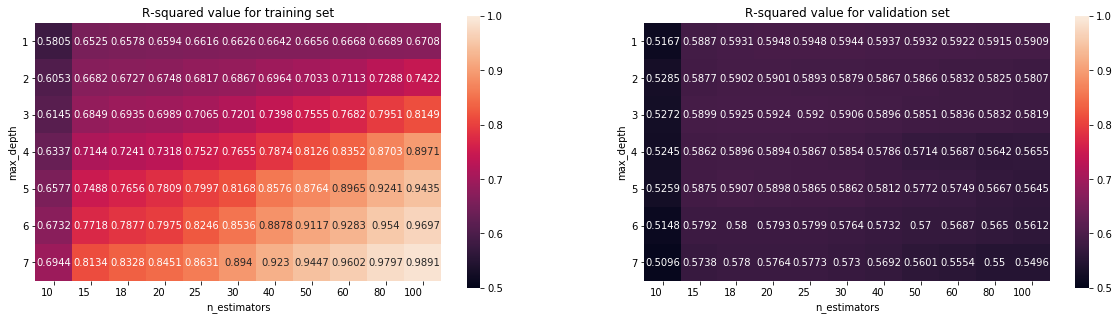

In [397]:
plt.figure(figsize=(20,5))
plt.subplot(121)
ax=sns.heatmap(train_r2_score_list,annot=True,square=True,fmt='.4g',vmin=0.5,vmax=1)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.title('R-squared value for training set')
ax.set_xticklabels(alpha,rotation=0, horizontalalignment='right');
ax.set_yticklabels(max_depth,rotation=0, horizontalalignment='right');
plt.subplot(122)
ax=sns.heatmap(val_r2_score_list,annot=True,square=True,fmt='.4g',vmin=0.5,vmax=1)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.title('R-squared value for validation set')
ax.set_xticklabels(alpha,rotation=0, horizontalalignment='right');
ax.set_yticklabels(max_depth,rotation=0, horizontalalignment='right');

Best value of hyperparameters: n_estimators = 20, max_depth = 1

<h3>3.11.4.1.2 RandomSearchCV</h3>

In [398]:
clf = xgb.XGBRegressor()
params = {'n_estimators':[10,15,18,20,25,30,40,50,60,80,100],
          'max_depth':[1,2,3,4,5,7],
              'colsample_bytree':[0.1,0.3,0.5,1],'subsample':[0.1,0.3,0.5,1]}
random_clf = RandomizedSearchCV(clf,param_distributions=params,verbose=5,n_jobs=1,
                                return_train_score=True,n_iter=40,scoring='r2',cv=5)
random_clf.fit(stack_train,y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] max_depth=3, subsample=0.1, n_estimators=60, colsample_bytree=1 .
[CV]  max_depth=3, subsample=0.1, n_estimators=60, colsample_bytree=1, score=(train=0.624, test=0.543), total=   0.2s
[CV] max_depth=3, subsample=0.1, n_estimators=60, colsample_bytree=1 .


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  max_depth=3, subsample=0.1, n_estimators=60, colsample_bytree=1, score=(train=0.675, test=0.496), total=   0.2s
[CV] max_depth=3, subsample=0.1, n_estimators=60, colsample_bytree=1 .
[CV]  max_depth=3, subsample=0.1, n_estimators=60, colsample_bytree=1, score=(train=0.636, test=0.522), total=   0.2s
[CV] max_depth=3, subsample=0.1, n_estimators=60, colsample_bytree=1 .


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


[CV]  max_depth=3, subsample=0.1, n_estimators=60, colsample_bytree=1, score=(train=0.662, test=0.513), total=   0.2s
[CV] max_depth=3, subsample=0.1, n_estimators=60, colsample_bytree=1 .
[CV]  max_depth=3, subsample=0.1, n_estimators=60, colsample_bytree=1, score=(train=0.610, test=0.512), total=   0.2s
[CV] max_depth=4, subsample=1, n_estimators=25, colsample_bytree=0.3 .


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s


[CV]  max_depth=4, subsample=1, n_estimators=25, colsample_bytree=0.3, score=(train=0.733, test=0.673), total=   0.1s
[CV] max_depth=4, subsample=1, n_estimators=25, colsample_bytree=0.3 .
[CV]  max_depth=4, subsample=1, n_estimators=25, colsample_bytree=0.3, score=(train=0.750, test=0.581), total=   0.1s
[CV] max_depth=4, subsample=1, n_estimators=25, colsample_bytree=0.3 .
[CV]  max_depth=4, subsample=1, n_estimators=25, colsample_bytree=0.3, score=(train=0.739, test=0.630), total=   0.1s
[CV] max_depth=4, subsample=1, n_estimators=25, colsample_bytree=0.3 .
[CV]  max_depth=4, subsample=1, n_estimators=25, colsample_bytree=0.3, score=(train=0.745, test=0.593), total=   0.1s
[CV] max_depth=4, subsample=1, n_estimators=25, colsample_bytree=0.3 .
[CV]  max_depth=4, subsample=1, n_estimators=25, colsample_bytree=0.3, score=(train=0.739, test=0.642), total=   0.1s
[CV] max_depth=2, subsample=0.5, n_estimators=20, colsample_bytree=0.5 
[CV]  max_depth=2, subsample=0.5, n_estimators=20, col

[CV]  max_depth=2, subsample=1, n_estimators=80, colsample_bytree=0.5, score=(train=0.727, test=0.656), total=   0.2s
[CV] max_depth=3, subsample=1, n_estimators=40, colsample_bytree=0.5 .
[CV]  max_depth=3, subsample=1, n_estimators=40, colsample_bytree=0.5, score=(train=0.730, test=0.672), total=   0.2s
[CV] max_depth=3, subsample=1, n_estimators=40, colsample_bytree=0.5 .
[CV]  max_depth=3, subsample=1, n_estimators=40, colsample_bytree=0.5, score=(train=0.755, test=0.575), total=   0.2s
[CV] max_depth=3, subsample=1, n_estimators=40, colsample_bytree=0.5 .
[CV]  max_depth=3, subsample=1, n_estimators=40, colsample_bytree=0.5, score=(train=0.750, test=0.643), total=   0.2s
[CV] max_depth=3, subsample=1, n_estimators=40, colsample_bytree=0.5 .
[CV]  max_depth=3, subsample=1, n_estimators=40, colsample_bytree=0.5, score=(train=0.746, test=0.597), total=   0.2s
[CV] max_depth=3, subsample=1, n_estimators=40, colsample_bytree=0.5 .
[CV]  max_depth=3, subsample=1, n_estimators=40, colsam

[CV]  max_depth=4, subsample=0.5, n_estimators=15, colsample_bytree=1, score=(train=0.702, test=0.637), total=   0.1s
[CV] max_depth=4, subsample=0.5, n_estimators=15, colsample_bytree=1 .
[CV]  max_depth=4, subsample=0.5, n_estimators=15, colsample_bytree=1, score=(train=0.706, test=0.589), total=   0.1s
[CV] max_depth=4, subsample=0.5, n_estimators=15, colsample_bytree=1 .
[CV]  max_depth=4, subsample=0.5, n_estimators=15, colsample_bytree=1, score=(train=0.694, test=0.656), total=   0.1s
[CV] max_depth=3, subsample=0.5, n_estimators=30, colsample_bytree=1 .
[CV]  max_depth=3, subsample=0.5, n_estimators=30, colsample_bytree=1, score=(train=0.708, test=0.665), total=   0.2s
[CV] max_depth=3, subsample=0.5, n_estimators=30, colsample_bytree=1 .
[CV]  max_depth=3, subsample=0.5, n_estimators=30, colsample_bytree=1, score=(train=0.727, test=0.568), total=   0.2s
[CV] max_depth=3, subsample=0.5, n_estimators=30, colsample_bytree=1 .
[CV]  max_depth=3, subsample=0.5, n_estimators=30, cols

[CV]  max_depth=4, subsample=0.5, n_estimators=100, colsample_bytree=0.5, score=(train=0.884, test=0.507), total=   0.4s
[CV] max_depth=4, subsample=0.5, n_estimators=100, colsample_bytree=0.5 
[CV]  max_depth=4, subsample=0.5, n_estimators=100, colsample_bytree=0.5, score=(train=0.876, test=0.604), total=   0.4s
[CV] max_depth=4, subsample=0.5, n_estimators=100, colsample_bytree=0.5 
[CV]  max_depth=4, subsample=0.5, n_estimators=100, colsample_bytree=0.5, score=(train=0.878, test=0.525), total=   0.4s
[CV] max_depth=4, subsample=0.5, n_estimators=100, colsample_bytree=0.5 
[CV]  max_depth=4, subsample=0.5, n_estimators=100, colsample_bytree=0.5, score=(train=0.874, test=0.602), total=   0.4s
[CV] max_depth=4, subsample=1, n_estimators=40, colsample_bytree=1 ...
[CV]  max_depth=4, subsample=1, n_estimators=40, colsample_bytree=1, score=(train=0.805, test=0.658), total=   0.3s
[CV] max_depth=4, subsample=1, n_estimators=40, colsample_bytree=1 ...
[CV]  max_depth=4, subsample=1, n_estim

[CV]  max_depth=1, subsample=0.3, n_estimators=10, colsample_bytree=1, score=(train=0.584, test=0.508), total=   0.0s
[CV] max_depth=1, subsample=0.3, n_estimators=10, colsample_bytree=1 .
[CV]  max_depth=1, subsample=0.3, n_estimators=10, colsample_bytree=1, score=(train=0.568, test=0.561), total=   0.0s
[CV] max_depth=1, subsample=0.3, n_estimators=10, colsample_bytree=1 .
[CV]  max_depth=1, subsample=0.3, n_estimators=10, colsample_bytree=1, score=(train=0.582, test=0.521), total=   0.0s
[CV] max_depth=1, subsample=0.3, n_estimators=10, colsample_bytree=1 .
[CV]  max_depth=1, subsample=0.3, n_estimators=10, colsample_bytree=1, score=(train=0.568, test=0.616), total=   0.0s
[CV] max_depth=4, subsample=0.3, n_estimators=18, colsample_bytree=0.5 
[CV]  max_depth=4, subsample=0.3, n_estimators=18, colsample_bytree=0.5, score=(train=0.688, test=0.655), total=   0.1s
[CV] max_depth=4, subsample=0.3, n_estimators=18, colsample_bytree=0.5 
[CV]  max_depth=4, subsample=0.3, n_estimators=18, 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   28.2s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_...
                                          tree_method=None,
                                          validate_parameters=False,
                                          verbosity=None),
  

In [399]:
best_params = random_clf.best_params_
best_params

{'colsample_bytree': 0.5, 'max_depth': 2, 'n_estimators': 25, 'subsample': 1}

In [400]:
clf = xgb.XGBRegressor(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth'],
                        colsample_bytree=best_params['colsample_bytree'],subsample=best_params['subsample'],
                        n_threads=-1,random_state=25)
clf.fit(stack_train,y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=25, n_jobs=0, n_threads=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=25, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [401]:
#R2 value
print('Train R-squared value:',clf.score(stack_train,y_train))
print('Val R-squared value:',clf.score(stack_val,y_val))

Train R-squared value: 0.6789066582597825
Val R-squared value: 0.5912436892283606


<h3>3.11.4.2. Best model for XGBoost

In [402]:
#Best params
best_params={'n_estimators':20,'max_depth':1,'colsample_bytree':0.1,'subsample':1}

In [403]:
clf = xgb.XGBRegressor(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth'],
                        colsample_bytree=best_params['colsample_bytree'],subsample=best_params['subsample'],
                        n_threads=-1,random_state=25)
clf.fit(stack_train,y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=1,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=20, n_jobs=0, n_threads=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=25, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [405]:
#Save meta model
joblib.dump(clf,'ensemble_meta_model.pkl')

['ensemble_meta_model.pkl']

In [404]:
#R2 value
print('Train R-squared value:',clf.score(stack_train,y_train))
print('Val R-squared value:',clf.score(stack_val,y_val))

Train R-squared value: 0.6507980995960747
Val R-squared value: 0.5956534139833989


In [11]:
algo_val['Stack_Bag'] =  0.596

<h2>4. Summary</h2>

Text(0.5, 1.0, 'R-squared value for different algorithms')

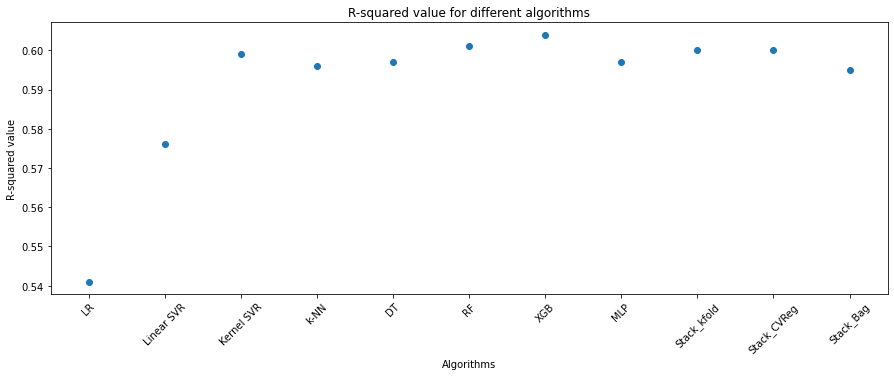

In [14]:
plt.figure(figsize=(15,5))
plt.scatter(algo_val.keys(), algo_val.values())
plt.xticks(rotation=45)
plt.xlabel('Algorithms')
plt.ylabel('R-squared value')
plt.title('R-squared value for different algorithms')

In [15]:
from tabulate import tabulate
summary=[['Linear Regression','reg=ElasticNet,\nalpha=0.05,\nl1_ratio=0.001',algo_val['LR']],
         ['Linear\nSuport Vector\nRegression','reg=L2,\nC=0.5,\nepsilon=0.5',algo_val['Linear SVR']],
         ['Kernel\nSuport Vector\nRegression','C=5,\nepsilon=5,\ngamma=0.1',algo_val['Kernel SVR']],
         ['k-Nearest\nNeighbours','k=85',algo_val['k-NN']],
         ['Decision Tree','max_depth=5,\nmin_samples_split=700,\nmin_samples_leaf=40',algo_val['DT']],
         ['Random Forest','n_estimators=500,\nmax_depth=3,\nmin_samples_split=600,\nmin_samples_leaf=20',algo_val['RF']],
         ['XGBoost','n_estimators=50,\nmax_depth=1,\ncolsample_bytree=1,\nsubsample=1',algo_val['XGB']],
         ['MLP','NA',algo_val['MLP']],
         ['Stacking\nwith\nk-fold\nCross\nValidation','NA',algo_val['Stack_kfold']],
         ['Stacking\nusing\nStackingCVRegressor','NA',algo_val['Stack_CVReg']],
         ['Stacking\nwith\nBagging\nEnsemble','NA',algo_val['Stack_Bag']]]
            
headers = ['Model','Hyperparameters','Val R-squared']
print(tabulate(summary, headers, tablefmt="grid"))

+---------------------+------------------------+-----------------+
| Model               | Hyperparameters        |   Val R-squared |
+=====================+========================+=================+
| Linear Regression   | reg=ElasticNet,        |           0.541 |
|                     | alpha=0.05,            |                 |
|                     | l1_ratio=0.001         |                 |
+---------------------+------------------------+-----------------+
| Linear              | reg=L2,                |           0.576 |
| Suport Vector       | C=0.5,                 |                 |
| Regression          | epsilon=0.5            |                 |
+---------------------+------------------------+-----------------+
| Kernel              | C=5,                   |           0.599 |
| Suport Vector       | epsilon=5,             |                 |
| Regression          | gamma=0.1              |                 |
+---------------------+------------------------+--------------

XGBoost algorithm performs best with validation R-squared value of 0.604. The val R-squared for linear regression and linear SVM are much lower than other models. Hence these models are ignored while making prediction for test data.

<h2>5. Prediction on test data</h2>

<h3>5.1. Data Preparation

In [73]:
test = pd.read_csv('test.csv')
test.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,...,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,...,0,0,1,0,0,0,0,0,0,0
2,3,az,v,as,f,d,a,j,j,0,...,0,0,0,1,0,0,0,0,0,0
3,4,az,l,n,f,d,z,l,n,0,...,0,0,0,1,0,0,0,0,0,0
4,5,w,s,as,c,d,y,i,m,0,...,1,0,0,0,0,0,0,0,0,0


In [74]:
categ_mapping = [x0_labels,x1_labels,x2_labels,x3_labels,x5_labels,x6_labels,x8_labels]
norm_features = [scale_features, scale_features_min, scale_features_max]
X_test = preprocess(test,categ_mapping,feature_engg,num_features,norm_features)

In [75]:
X_test.head()

,ID,X0,X1,X2,X3,X5,X6,X8,X10,X12,...,X314_X315_X322,X314_X315_X326,X314_X315_X340,X314_X315_X342,X314_X315_X345,X314_X315_X359,X314_X315_X361,X314_X315_X368,X314_X315_X373,X314_X315_X376
0,0.000119,0.282051,0.227273,0.259259,0.166667,0.0,0.454545,0.333333,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0.000238,0.153846,0.136364,0.111111,0.333333,0.0,0.090909,0.750000,0,0,...,0,0,0,0,0,0,1,1,0,0
2,0.000356,0.282051,0.227273,0.037037,0.166667,0.0,0.000000,0.000000,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.000475,0.282051,0.090909,0.259259,0.166667,0.0,0.363636,0.125000,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0.000594,0.307692,0.181818,0.037037,0.000000,0.0,0.272727,0.541667,0,0,...,1,1,1,1,1,1,2,1,1,1


In [76]:
top_features = np.load('top_features.npy')

<h3>5.2 Predictions

<h3>5.2.1. Kernel SVM

In [128]:
features = top_features[:10]

In [129]:
#Best params
best_params={'C':5,'epsilon':5,'gamma':0.1}

In [130]:
clf = SVR(C=best_params['C'],epsilon=best_params['epsilon'],gamma=best_params['gamma'])
clf.fit(X_train[features],y_train)

SVR(C=5, cache_size=200, coef0=0.0, degree=3, epsilon=5, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [131]:
pred_ksvm = clf.predict(X_test[features])

In [132]:
pred = pd.DataFrame()
pred['ID'] = test.ID
pred['y'] = pred_ksvm
pred.to_csv('3_ksvm.csv', index=False)

<h3>5.2.2. KNN

In [128]:
features = top_features[:5]

In [295]:
clf = KNeighborsRegressor(n_neighbors=85,n_jobs=-1)
clf.fit(X_train[top_features],y_train)    

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=85, p=2,
          weights='uniform')

In [131]:
pred_knn = clf.predict(X_test[features])

In [132]:
pred = pd.DataFrame()
pred['ID'] = test.ID
pred['y'] = pred_knn
pred.to_csv('3_knn.csv', index=False)

<h3>5.2.3. Decision Tree

In [134]:
features = top_features[:10]

In [135]:
best_params = {'max_depth': 5, 'min_samples_leaf': 40, 'min_samples_split': 700}

In [136]:
clf = DecisionTreeRegressor(max_depth=best_params['max_depth'],
                        min_samples_split=best_params['min_samples_split'],min_samples_leaf=best_params['min_samples_leaf'],
                        random_state=25)
clf.fit(X_train[features],y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=40, min_samples_split=700,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=25, splitter='best')

In [137]:
pred_dt = clf.predict(X_test[features])

In [138]:
pred = pd.DataFrame()
pred['ID'] = test.ID
pred['y'] = pred_dt
pred.to_csv('3_dt.csv', index=False)

<h3>5.2.4. Random Forest

In [139]:
features = top_features[:20]

In [140]:
best_params = {'max_depth': 3, 'min_samples_leaf': 20, 'min_samples_split': 600, 'n_estimators': 500}

In [141]:
clf = RandomForestRegressor(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth'],
                        min_samples_split=best_params['min_samples_leaf'],min_samples_leaf=best_params['min_samples_leaf'],
                        n_jobs=-1,random_state=25)
clf.fit(X_train[features],y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=20,
                      min_samples_split=20, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=-1, oob_score=False,
                      random_state=25, verbose=0, warm_start=False)

In [142]:
pred_rf = clf.predict(X_test[features])

In [143]:
pred = pd.DataFrame()
pred['ID'] = test.ID
pred['y'] = pred_rf
pred.to_csv('3_rf.csv', index=False)

<h3>5.2.5. XGBoost

In [145]:
features = top_features[:8]

In [146]:
#Best params
best_params={'n_estimators':50,'max_depth':1,'colsample_bytree':1,'subsample':1}

In [147]:
clf = xgb.XGBRegressor(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth'],
                        colsample_bytree=best_params['colsample_bytree'],subsample=best_params['subsample'],
                        n_threads=-1,random_state=25)
clf.fit(X_train[features],y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=1,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=0, n_threads=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=25, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [148]:
pred_xgb = clf.predict(X_test[features])

In [149]:
pred = pd.DataFrame()
pred['ID'] = test.ID
pred['y'] = pred_xgb
pred.to_csv('3_xgb.csv', index=False)

<h3>5.2.6. MLP

In [165]:
features = top_features[:8]

In [166]:
model = mlp_model(input_shape=len(features))
model.compile(optimizer=Adam(learning_rate=0.1),loss='mean_squared_error', metrics=[r_squared])
model.load_weights('model_save/weights-27-0.5947.hdf5')

In [167]:
pred_mlp = model.predict(X_test[features])

In [168]:
pred = pd.DataFrame()
pred['ID'] = test.ID
pred['y'] = pred_mlp
pred.to_csv('3_mlp.csv', index=False)

<h3>5.2.7. Stacking with k-fold Cross Validation

In [64]:
#Kernel SVR base model
features = top_features[:10]
ksvm_model = SVR(C=5,epsilon=5,gamma=0.1)
ksvm_train, ksvm_test = meta_model_features(X_train[features],y_train,X_test[features],ksvm_model,10)

In [65]:
#k-NN base model
features = top_features[:5]
knn_model = KNeighborsRegressor(n_neighbors=85,n_jobs=-1)
knn_train, knn_test = meta_model_features(X_train[features],y_train,X_test[features],knn_model,10)

In [66]:
#Random Forest base model
features = top_features[:20]
rf_model = RandomForestRegressor(n_estimators=500,max_depth=3,min_samples_split=600,min_samples_leaf=20,n_jobs=-1,
                                 random_state=25)
rf_train, rf_test = meta_model_features(X_train[features],y_train,X_test[features],rf_model,10)

In [67]:
#Random Forest base model
features = top_features[:20]
rf_model2 = RandomForestRegressor(n_estimators=500,max_depth=5,min_samples_split=550,min_samples_leaf=20,n_jobs=-1,
                                 random_state=25)
rf_train2, rf_test2 = meta_model_features(X_train[features],y_train,X_test[features],rf_model2,10)

In [68]:
#XGBoost base model
features = top_features[:8]
xgb_model = xgb.XGBRegressor(n_estimators=50,max_depth=1,colsample_bytree=1,subsample=1,n_thread=-1)
xgb_train, xgb_test = meta_model_features(X_train[features],y_train,X_test[features],xgb_model,10)

In [69]:
#XGBoost base model
features = top_features[:8]
xgb_model2 = xgb.XGBRegressor(n_estimators=20,max_depth=3,colsample_bytree=1,subsample=1,n_thread=-1)
xgb_train2, xgb_test2 = meta_model_features(X_train[features],y_train,X_test[features],xgb_model2,10)

In [70]:
#MLP base model
features = top_features[:8]
mlp_base_model = mlp_model(input_shape = X_train[features].shape[1])
mlp_base_train, mlp_base_test = meta_model_features_mlp(X_train[features],y_train,X_test[features],mlp_base_model,
                                                       batch_size=16,epochs=100,n_folds=10)

Fold:  1
Train on 3019 samples, validate on 336 samples
Epoch 1/100
3019/3019 [==============================] - 1s 329us/sample - loss: 19450.8861 - r_squared: -173.7448 - val_loss: 62.7863 - val_r_squared: 0.5874
Epoch 2/100
3019/3019 [==============================] - 1s 178us/sample - loss: 67.8413 - r_squared: 0.4544 - val_loss: 61.2211 - val_r_squared: 0.5969
Epoch 3/100
3019/3019 [==============================] - 1s 179us/sample - loss: 82.7204 - r_squared: 0.3064 - val_loss: 68.4756 - val_r_squared: 0.5033
Epoch 4/100
3019/3019 [==============================] - 1s 178us/sample - loss: 92.2338 - r_squared: 0.2586 - val_loss: 106.2721 - val_r_squared: 0.2653
Epoch 5/100
3019/3019 [==============================] - 1s 177us/sample - loss: 62.7772 - r_squared: 0.5219 - val_loss: 88.9414 - val_r_squared: 0.3031
Epoch 6/100
3019/3019 [==============================] - 1s 175us/sample - loss: 70.4819 - r_squared: 0.4520 - val_loss: 63.7269 - val_r_squared: 0.5837
Epoch 7/100
3019/30

Epoch 42/100
3019/3019 [==============================] - 1s 175us/sample - loss: 54.9903 - r_squared: 0.5741 - val_loss: 61.0140 - val_r_squared: 0.5923
Epoch 43/100
2944/3019 [============================>.] - ETA: 0s - loss: 56.7184 - r_squared: 0.5751
Epoch 00043: ReduceLROnPlateau reducing learning rate to 0.028242950141429902.
3019/3019 [==============================] - 1s 175us/sample - loss: 56.6748 - r_squared: 0.5739 - val_loss: 60.9615 - val_r_squared: 0.5844
Epoch 44/100
3019/3019 [==============================] - 1s 178us/sample - loss: 54.9041 - r_squared: 0.5776 - val_loss: 70.9175 - val_r_squared: 0.5365
Epoch 45/100
3019/3019 [==============================] - 1s 177us/sample - loss: 53.5537 - r_squared: 0.5992 - val_loss: 68.2068 - val_r_squared: 0.5552
Epoch 46/100
2864/3019 [===========================>..] - ETA: 0s - loss: 55.2053 - r_squared: 0.5810
Epoch 00046: ReduceLROnPlateau reducing learning rate to 0.02541865445673466.
3019/3019 [=========================

3019/3019 [==============================] - 1s 174us/sample - loss: 51.4233 - r_squared: 0.6089 - val_loss: 60.0436 - val_r_squared: 0.5978
Epoch 82/100
2960/3019 [============================>.] - ETA: 0s - loss: 51.9929 - r_squared: 0.6136
Epoch 00082: ReduceLROnPlateau reducing learning rate to 0.007178978528827429.
3019/3019 [==============================] - 1s 173us/sample - loss: 51.7294 - r_squared: 0.6122 - val_loss: 61.7265 - val_r_squared: 0.5942
Epoch 83/100
3019/3019 [==============================] - 1s 172us/sample - loss: 50.9876 - r_squared: 0.6191 - val_loss: 60.2215 - val_r_squared: 0.6021
Epoch 84/100
3019/3019 [==============================] - 1s 173us/sample - loss: 51.1243 - r_squared: 0.6099 - val_loss: 62.3060 - val_r_squared: 0.5926
Epoch 85/100
2976/3019 [============================>.] - ETA: 0s - loss: 51.0090 - r_squared: 0.6202
Epoch 00085: ReduceLROnPlateau reducing learning rate to 0.006461080675944686.
Restoring model weights from the end of the best

Epoch 11/100
3019/3019 [==============================] - 1s 175us/sample - loss: 50.5966 - r_squared: 0.6073 - val_loss: 55.4440 - val_r_squared: 0.6285
Epoch 12/100
3019/3019 [==============================] - 1s 177us/sample - loss: 50.8388 - r_squared: 0.6128 - val_loss: 56.1764 - val_r_squared: 0.6273
Epoch 13/100
2944/3019 [============================>.] - ETA: 0s - loss: 49.9135 - r_squared: 0.6134
Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0020275555551052095.
3019/3019 [==============================] - 1s 176us/sample - loss: 50.3993 - r_squared: 0.6112 - val_loss: 56.5971 - val_r_squared: 0.6248
Epoch 14/100
3019/3019 [==============================] - 1s 176us/sample - loss: 50.8194 - r_squared: 0.6115 - val_loss: 55.0664 - val_r_squared: 0.6287
Epoch 15/100
3019/3019 [==============================] - 1s 179us/sample - loss: 50.4480 - r_squared: 0.6186 - val_loss: 55.0000 - val_r_squared: 0.6236
Epoch 16/100
2912/3019 [===========================>..] - ETA

Fold:  5
Train on 3019 samples, validate on 336 samples
Epoch 1/100
3019/3019 [==============================] - 1s 180us/sample - loss: 51.1384 - r_squared: 0.6151 - val_loss: 48.3185 - val_r_squared: 0.6234
Epoch 2/100
3019/3019 [==============================] - 1s 175us/sample - loss: 51.1511 - r_squared: 0.6160 - val_loss: 48.2682 - val_r_squared: 0.6238
Epoch 3/100
3019/3019 [==============================] - 1s 176us/sample - loss: 51.2954 - r_squared: 0.6154 - val_loss: 48.2402 - val_r_squared: 0.6236
Epoch 4/100
3019/3019 [==============================] - 1s 176us/sample - loss: 51.1844 - r_squared: 0.6192 - val_loss: 48.3082 - val_r_squared: 0.6227
Epoch 5/100
3019/3019 [==============================] - 1s 173us/sample - loss: 51.1933 - r_squared: 0.6252 - val_loss: 48.3286 - val_r_squared: 0.6223
Epoch 6/100
3019/3019 [==============================] - 1s 174us/sample - loss: 51.1793 - r_squared: 0.6256 - val_loss: 48.2629 - val_r_squared: 0.6237
Epoch 7/100
3019/3019 [===

Epoch 19/100
3020/3020 [==============================] - 1s 173us/sample - loss: 51.5925 - r_squared: 0.6135 - val_loss: 43.9323 - val_r_squared: 0.6143
Epoch 20/100
3020/3020 [==============================] - 1s 177us/sample - loss: 51.5981 - r_squared: 0.6220 - val_loss: 43.8101 - val_r_squared: 0.6162
Epoch 21/100
2880/3020 [===========================>..] - ETA: 0s - loss: 50.2054 - r_squared: 0.6158
Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.0002465034427586943.
3020/3020 [==============================] - 1s 179us/sample - loss: 51.5642 - r_squared: 0.6102 - val_loss: 43.6491 - val_r_squared: 0.6193
Epoch 22/100
3020/3020 [==============================] - 1s 173us/sample - loss: 51.5995 - r_squared: 0.6086 - val_loss: 43.7716 - val_r_squared: 0.6171
Epoch 23/100
3020/3020 [==============================] - 1s 172us/sample - loss: 51.5890 - r_squared: 0.6144 - val_loss: 43.6437 - val_r_squared: 0.6196
Epoch 24/100
2992/3020 [============================>.] - ETA

3020/3020 [==============================] - 1s 173us/sample - loss: 50.7367 - r_squared: 0.6217 - val_loss: 51.0209 - val_r_squared: 0.6260
Epoch 2/100
3020/3020 [==============================] - 1s 178us/sample - loss: 50.7010 - r_squared: 0.6260 - val_loss: 50.9724 - val_r_squared: 0.6273
Epoch 3/100
3020/3020 [==============================] - 1s 175us/sample - loss: 50.6946 - r_squared: 0.6145 - val_loss: 51.0803 - val_r_squared: 0.6250
Epoch 4/100
3020/3020 [==============================] - 1s 176us/sample - loss: 50.7143 - r_squared: 0.6254 - val_loss: 50.9906 - val_r_squared: 0.6269
Epoch 5/100
3020/3020 [==============================] - 1s 175us/sample - loss: 50.7352 - r_squared: 0.6065 - val_loss: 51.0223 - val_r_squared: 0.6262
Epoch 6/100
3020/3020 [==============================] - 1s 179us/sample - loss: 50.7113 - r_squared: 0.6190 - val_loss: 50.9795 - val_r_squared: 0.6275
Epoch 7/100
3020/3020 [==============================] - 1s 179us/sample - loss: 50.7424 - r_s

Epoch 5/100
3020/3020 [==============================] - 0s 151us/sample - loss: 50.2093 - r_squared: 0.6185 - val_loss: 55.7035 - val_r_squared: 0.6313
Epoch 6/100
3020/3020 [==============================] - 0s 153us/sample - loss: 50.2110 - r_squared: 0.6249 - val_loss: 55.6817 - val_r_squared: 0.6313
Epoch 7/100
3020/3020 [==============================] - 0s 151us/sample - loss: 50.1908 - r_squared: 0.6203 - val_loss: 55.6782 - val_r_squared: 0.6313
Epoch 8/100
3020/3020 [==============================] - 0s 157us/sample - loss: 50.2213 - r_squared: 0.6263 - val_loss: 55.6741 - val_r_squared: 0.6313
Epoch 9/100
3020/3020 [==============================] - 0s 152us/sample - loss: 50.2077 - r_squared: 0.6208 - val_loss: 55.6468 - val_r_squared: 0.6313
Epoch 10/100
3020/3020 [==============================] - 0s 138us/sample - loss: 50.1990 - r_squared: 0.6167 - val_loss: 55.6242 - val_r_squared: 0.6313
Epoch 11/100
3020/3020 [==============================] - 0s 141us/sample - loss:

In [71]:
#Data for metaregressor model
X_train_meta = pd.DataFrame(index=X_train.index)
X_train_meta['ksvm'] = ksvm_train.reshape(-1)
X_train_meta['knn'] = knn_train.reshape(-1)
X_train_meta['rf'] = rf_train.reshape(-1)
X_train_meta['rf2'] = rf_train2.reshape(-1)
X_train_meta['xgb'] = xgb_train.reshape(-1)
X_train_meta['xgb2'] = xgb_train2.reshape(-1)
X_train_meta['mlp'] = mlp_base_train.reshape(-1)

In [72]:
X_train_meta.head()

,ksvm,knn,rf,rf2,xgb,xgb2,mlp
1468,112.163083,111.600706,112.596316,112.207761,112.354675,112.006897,112.790199
3654,93.431972,93.714118,92.115970,92.075692,92.915833,92.067558,93.727036
3130,93.483378,93.478118,94.070993,95.007922,94.151459,94.810463,93.344482
257,112.604677,111.625176,112.582949,112.277456,112.118492,112.853111,112.993004
781,94.019908,93.059176,94.393615,93.848291,94.517471,94.535118,94.326843


In [73]:
#Data for metaregressor model
X_test_meta = pd.DataFrame(index=X_test.index)
X_test_meta['ksvm'] = ksvm_test.reshape(-1)
X_test_meta['knn'] = knn_test.reshape(-1)
X_test_meta['rf'] = rf_test.reshape(-1)
X_test_meta['rf2'] = rf_test2.reshape(-1)
X_test_meta['xgb'] = xgb_test.reshape(-1)
X_test_meta['xgb2'] = xgb_test2.reshape(-1)
X_test_meta['mlp'] = mlp_base_test.reshape(-1)

In [74]:
X_test_meta.head()

,ksvm,knn,rf,rf2,xgb,xgb2,mlp
0,83.260091,77.831788,78.753572,78.753572,99.231070,91.383671,77.858652
1,94.222772,93.773671,94.461776,94.385926,114.647266,109.611495,94.924603
2,79.815791,77.831788,77.924556,77.924556,84.068574,77.775558,77.858652
3,83.259482,77.831788,78.753572,78.753572,82.767741,79.558404,77.858652
4,112.590961,111.934247,112.558245,112.275801,116.069727,115.051260,113.239570


In [75]:
pred = pd.DataFrame()
pred['ID'] = test.ID
pred['y'] = X_test_meta.mean(axis=1)
pred.to_csv('3_stack_kfold_avg.csv', index=False)

In [77]:
#Best params
best_params={'n_estimators':50,'max_depth':1,'colsample_bytree':1,'subsample':1}

In [78]:
clf = xgb.XGBRegressor(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth'],
                        colsample_bytree=best_params['colsample_bytree'],subsample=best_params['subsample'],
                        n_threads=-1,random_state=25)
clf.fit(X_train_meta,y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=1,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=50, n_jobs=0, n_threads=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=25, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [81]:
pred_stack_kfold = clf.predict(X_test_meta)

In [82]:
pred = pd.DataFrame()
pred['ID'] = test.ID
pred['y'] = pred_stack_kfold
pred.to_csv('3_stack_kfold.csv', index=False)

<h3>5.2.8. Stacking using StackingCVRegressor

In [129]:
#Kernel SVR base model
ksvm_model = SVR(C=5,epsilon=5,gamma=0.1)

#k-NN base model
knn_model = KNeighborsRegressor(n_neighbors=85,n_jobs=-1)

#Random Forest base model
rf_model = RandomForestRegressor(n_estimators=500,max_depth=2,min_samples_split=600,min_samples_leaf=20,n_jobs=-1,
                                 random_state=25)

#XGBoost base model
xgb_model = xgb.XGBRegressor(n_estimators=50,max_depth=3,colsample_bytree=1,subsample=1,n_thread=-1)

#Meta model
xgb_meta = xgb.XGBRegressor(n_estimators=50,max_depth=1,colsample_bytree=1,subsample=1,n_thread=-1)

In [130]:
features = top_features[:10]

stack = StackingCVRegressor(regressors=(ksvm_model,knn_model,rf_model,xgb_model),
                           meta_regressor=xgb_meta,cv=10,use_features_in_secondary=True,store_train_meta_features=True,
                            shuffle=True,random_state=42,verbose=1,n_jobs=1)
stack.fit(X_train[features],y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


StackingCVRegressor(cv=10,
                    meta_regressor=XGBRegressor(base_score=None, booster=None,
                                                colsample_bylevel=None,
                                                colsample_bynode=None,
                                                colsample_bytree=1, gamma=None,
                                                gpu_id=None,
                                                importance_type='gain',
                                                interaction_constraints=None,
                                                learning_rate=None,
                                                max_delta_step=None,
                                                max_depth=1,
                                                min_child_weight=None,
                                                missing=nan,
                                                monotone_constraints=None,
                                                n_estim

In [132]:
stack_test = X_test[features].copy()
stack_test.columns = ['f'+str(i) for i in range(len(features))]

In [133]:
pred_stack_cvreg = stack.predict(stack_test)

In [134]:
pred = pd.DataFrame()
pred['ID'] = test.ID
pred['y'] = pred_stack_cvreg
pred.to_csv('3_stack_cvreg.csv', index=False)

<h3>5.2.9. Stacking with Bootstrap Aggregation or Bagging Ensemble

In [406]:
top_features = np.load('top_features.npy')

In [407]:
features = top_features[:15]

In [408]:
X_pred = X_test[features]
X_pred.columns = ['f'+str(i) for i in range(len(X_pred.columns))]

In [409]:
drop_models = np.load('ensemble_drop_base_models.npy')

In [410]:
drop_models

array([ 3,  4,  9, 10, 11, 13, 15, 16, 19, 20, 22, 23, 26, 28, 30, 32, 34,
       36, 38, 39, 40, 41, 47, 50])

In [411]:
n_folds = 10
n_splits = 50
pred = np.zeros((X_pred.shape[0],n_splits-len(drop_models)))
pred.shape

(4209, 26)

In [412]:
ml_models = [i+1 for i in range(50) if i+1 not in drop_models]

In [413]:
for i,ml in enumerate(tqdm(ml_models)):
    a = np.zeros((pred.shape[0],n_folds))
    for j in range(n_folds):
        m = joblib.load('ml_models/ml_model_'+str(ml)+'_fold_'+str(j+1)+'.pkl')
        a[:,j] = m.predict(X_pred)
    pred[:,i] = np.mean(a,axis=1)

In [414]:
test_pred = pred

In [415]:
features = top_features[:8]
X_pred = X_test[features]
X_pred.columns = ['f'+str(i) for i in range(len(X_pred.columns))]

In [416]:
n_splits = 10
n_folds = 10
pred = np.zeros((X_pred.shape[0],n_splits))
pred.shape

(4209, 10)

In [417]:
for i in tqdm(range(n_splits)):
    a = np.zeros((pred.shape[0],n_folds))
    for j in range(n_folds):
        mlp_base_model.load_weights('mlp_models/mlp_model_'+str(i+1)+'_fold_'+str(j+1)+'.h5')
        a[:,j] = mlp_base_model.predict(X_pred).reshape(-1)
    pred[:,i] = np.mean(a,axis=1)

In [418]:
mlp_base_test = pred

In [419]:
#Combine predictions from mlp models and other models
stack_test = pd.DataFrame(test_pred,columns=['f'+str(i) for i in range(test_pred.shape[1])])
for i in range(mlp_base_test.shape[1]):
    stack_test['m{}'.format(i)] = mlp_base_test[:,i]

In [420]:
stack_test.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,m0,m1,m2,m3,m4,m5,m6,m7,m8,m9
0,81.435698,85.347737,79.225771,81.471724,87.385182,84.575268,82.484193,83.453196,81.431165,94.121373,...,78.557773,79.378123,81.306205,77.992628,78.181097,78.059530,78.044592,77.561935,78.587241,79.245551
1,93.720400,94.330831,94.536825,94.283298,94.177840,94.386466,93.854752,104.209762,94.095258,103.984049,...,95.193905,94.948481,94.892329,95.362042,95.325663,95.111541,95.676551,95.170759,95.518029,95.347250
2,79.405605,79.785636,79.225771,77.057663,78.199372,78.447272,80.124482,81.720293,78.482789,79.776656,...,78.274352,78.405395,78.104493,77.914197,78.083432,78.051814,78.042944,77.557317,77.769341,77.527165
3,81.435481,85.346924,79.225771,81.471724,87.385182,84.575268,82.483498,80.838938,81.431089,86.026025,...,78.557655,79.377258,81.300922,77.992619,78.176754,78.058243,78.044592,77.559881,78.578368,79.235562
4,113.027331,113.057471,112.578649,114.224223,112.368808,112.963035,113.531096,112.584917,111.825446,113.821748,...,113.992950,112.966500,113.100768,112.872060,113.082090,112.993452,113.333108,113.451942,113.486897,112.992671


In [421]:
models_rem = ['f'+str(i) for i in range(26)]
stack_test[models_rem].head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f16,f17,f18,f19,f20,f21,f22,f23,f24,f25
0,81.435698,85.347737,79.225771,81.471724,87.385182,84.575268,82.484193,83.453196,81.431165,94.121373,...,95.350092,95.928208,84.772896,81.798532,83.950951,81.260618,81.926165,85.426393,81.549511,88.113837
1,93.720400,94.330831,94.536825,94.283298,94.177840,94.386466,93.854752,104.209762,94.095258,103.984049,...,105.316573,108.202610,93.136902,93.396883,94.419320,95.033165,97.549001,94.748920,94.628417,98.431239
2,79.405605,79.785636,79.225771,77.057663,78.199372,78.447272,80.124482,81.720293,78.482789,79.776656,...,89.839400,78.737425,83.637518,78.736224,78.116910,78.669086,81.926165,79.418505,79.291794,81.892446
3,81.435481,85.346924,79.225771,81.471724,87.385182,84.575268,82.483498,80.838938,81.431089,86.026025,...,91.916817,82.775420,84.772896,81.798623,83.950951,81.260325,81.926165,85.425968,81.548937,88.113837
4,113.027331,113.057471,112.578649,114.224223,112.368808,112.963035,113.531096,112.584917,111.825446,113.821748,...,120.115561,111.964539,111.535943,112.618741,112.761682,113.153969,115.123986,112.531389,113.362267,116.182431


In [422]:
models_mlp = ['m'+str(i) for i in range(10)]
stack_test[models_mlp].head()

,m0,m1,m2,m3,m4,m5,m6,m7,m8,m9
0,78.557773,79.378123,81.306205,77.992628,78.181097,78.059530,78.044592,77.561935,78.587241,79.245551
1,95.193905,94.948481,94.892329,95.362042,95.325663,95.111541,95.676551,95.170759,95.518029,95.347250
2,78.274352,78.405395,78.104493,77.914197,78.083432,78.051814,78.042944,77.557317,77.769341,77.527165
3,78.557655,79.377258,81.300922,77.992619,78.176754,78.058243,78.044592,77.559881,78.578368,79.235562
4,113.992950,112.966500,113.100768,112.872060,113.082090,112.993452,113.333108,113.451942,113.486897,112.992671


In [423]:
pred = pd.DataFrame()
pred['ID'] = test.ID
pred['y'] = stack_test[models_rem].mean(axis=1)
pred.to_csv('3_stack_bag_rem_avg5.csv', index=False)

In [424]:
pred = pd.DataFrame()
pred['ID'] = test.ID
pred['y'] = stack_test[models_mlp].mean(axis=1)
pred.to_csv('3_stack_bag_mlp_avg5.csv', index=False)

In [425]:
pred = pd.DataFrame()
pred['ID'] = test.ID
pred['y'] = stack_test.mean(axis=1)
pred.to_csv('3_stack_bag_total_avg5.csv', index=False)

In [426]:
meta_model = joblib.load('ensemble_meta_model.pkl')

In [427]:
pred_stack_bag = meta_model.predict(stack_test)

In [428]:
pred = pd.DataFrame()
pred['ID'] = test.ID
pred['y'] = pred_stack_bag
pred.to_csv('3_stack_bag5.csv', index=False)